In [1]:
# ==========================================================
# 🧠 BLOQUE 0 — Configuración e importaciones
# ==========================================================
import pandas as pd
import numpy as np
import requests
import ta  # pip install ta
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
import ta
from math import atan, degrees
import itertools
from joblib import Parallel, delayed
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go



BASE_URL = "https://api.binance.com"
SYMBOLS = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]
INTERVAL = "4h"
LIMIT = 1000


# Procesamiento de Datos

In [61]:
# ==========================================================
# 🧠 BLOQUE 1 — Descarga de velas (Binance API extendida)
# ==========================================================

def get_binance_4h_data(symbol: str, limit=1000):
    """
    Descarga datos OHLCV de Binance y los retorna como DataFrame.
    Si limit > 1000, realiza múltiples llamadas paginadas automáticamente.
    """
    url = f"{BASE_URL}/api/v3/klines"
    limit_per_call = 1000
    all_data = []
    end_time = None

    print(f"📡 Descargando {limit} velas de {symbol}...")

    while len(all_data) < limit:
        current_limit = min(limit_per_call, limit - len(all_data))
        params = {"symbol": symbol, "interval": INTERVAL, "limit": current_limit}
        if end_time:
            params["endTime"] = end_time

        try:
            data = requests.get(url, params=params, timeout=10).json()
            if not data:
                break

            all_data.extend(data)
            end_time = data[0][0] - 1  # retrocede en el tiempo

            if len(data) < current_limit:
                break  # sin más datos disponibles

        except Exception as e:
            print(f"❌ Error descargando {symbol}: {e}")
            break

    if not all_data:
        print(f"⚠️ Sin datos para {symbol}")
        return None

    cols = [
        "Open time", "Open", "High", "Low", "Close", "Volume",
        "Close time", "Quote asset volume", "Number of trades",
        "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"
    ]

    df = pd.DataFrame(all_data, columns=cols)
    for c in ["Open", "High", "Low", "Close", "Volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["Open time"] = pd.to_datetime(df["Open time"], unit="ms", utc=True)
    df["Close time"] = pd.to_datetime(df["Close time"], unit="ms", utc=True)
    df = df.sort_values("Open time").reset_index(drop=True)
    df["Symbol"] = symbol

    print(f"✅ {symbol}: {len(df)} velas descargadas correctamente.\n")
    return df


# ==========================================================
# ⚙️ Descarga paralela para todos los símbolos
# ==========================================================
datasets = {}

print("📡 Descargando velas 4H de Binance (modo extendido)...")

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(get_binance_4h_data, sym, limit=2000): sym for sym in SYMBOLS}
    for fut in as_completed(futures):
        sym = futures[fut]
        df = fut.result()
        if df is not None:
            datasets[sym] = df
        else:
            print(f"⚠️ {sym}: no se pudo obtener data")

print("\n📊 Símbolos cargados:", list(datasets.keys()))

# ==========================================================
# 🧩 Variables de conveniencia (para pruebas directas)
# ==========================================================
df_btc = datasets.get("BTCUSDT")
df_eth = datasets.get("ETHUSDT")
df_ada = datasets.get("ADAUSDT")
df_xrp = datasets.get("XRPUSDT")
df_bnb = datasets.get("BNBUSDT")

print(f"🪙 BTCUSDT: {len(df_btc)} filas disponibles")
df_btc.head(3)


📡 Descargando velas 4H de Binance (modo extendido)...
📡 Descargando 2000 velas de BTCUSDT...
📡 Descargando 2000 velas de ETHUSDT...
📡 Descargando 2000 velas de ADAUSDT...
📡 Descargando 2000 velas de XRPUSDT...
📡 Descargando 2000 velas de BNBUSDT...
✅ BTCUSDT: 2000 velas descargadas correctamente.
✅ BNBUSDT: 2000 velas descargadas correctamente.


✅ ADAUSDT: 2000 velas descargadas correctamente.

✅ ETHUSDT: 2000 velas descargadas correctamente.

✅ XRPUSDT: 2000 velas descargadas correctamente.


📊 Símbolos cargados: ['BNBUSDT', 'BTCUSDT', 'ADAUSDT', 'ETHUSDT', 'XRPUSDT']
🪙 BTCUSDT: 2000 filas disponibles


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,Symbol
0,2024-12-07 20:00:00+00:00,100077.45,100439.18,99595.11,99831.99,1917.58211,2024-12-07 23:59:59.999000+00:00,191756276.92688580,391106,903.11592000,90311313.49742550,0,BTCUSDT
1,2024-12-08 00:00:00+00:00,99831.99,100328.88,99632.28,99934.82,1688.21452,2024-12-08 03:59:59.999000+00:00,168803783.06313560,389779,732.71240000,73272043.77464290,0,BTCUSDT
2,2024-12-08 04:00:00+00:00,99934.83,100030.00,99336.00,99675.11,1590.35590,2024-12-08 07:59:59.999000+00:00,158548563.87783540,334553,678.98575000,67696211.63046340,0,BTCUSDT


In [2]:
# ==============================================================
# 🧠 BLOQUE 2 - Definición de indicadores/variables predictoras
# ==============================================================



def calcular_indicadores(df, window_mom=8, smooth=3, n_lags=6, angle_window=4):
    """
    Calcula indicadores técnicos avanzados:
    - Momentum integral + derivados
    - Ángulo de tendencia
    - RSI, MACD, ATR
    - EMAs (20,30,40,50,70,100,150,200) y sus diferencias/ratios
    - Bandas de Bollinger
    - Stochastic RSI
    """
    df = df.copy()

    # === Momentum Integral ===
    df["momentum"] = df["Close"].diff()
    df["momentum_smooth"] = df["momentum"].rolling(window=smooth, min_periods=1).mean()
    df["integral_momentum"] = df["momentum_smooth"].rolling(window=window_mom).sum()
    df["slope_integral"] = df["integral_momentum"].diff()
    df["curvature_integral"] = df["slope_integral"].diff()
    df["std_slope_integral"] = df["slope_integral"].rolling(window=window_mom).std()
    df["zscore_slope_integral"] = (
        df["slope_integral"] / (df["std_slope_integral"].replace(0, np.nan))
    )

    # === Ángulo de tendencia del precio ===
    df["slope_price"] = (df["Close"] - df["Close"].shift(angle_window)) / angle_window
    df["angle_price_deg"] = np.degrees(np.arctan(df["slope_price"]))
    df["angle_smooth"] = df["angle_price_deg"].rolling(window=3, min_periods=1).mean()

    # === Indicadores clásicos ===
    df["rsi"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()
    macd = ta.trend.MACD(df["Close"])
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_hist"] = macd.macd_diff()
    df["atr"] = ta.volatility.AverageTrueRange(
        df["High"], df["Low"], df["Close"], window=14
    ).average_true_range()

    # === EMAs múltiples ===
    ema_periods = [20, 30, 40, 50, 70, 100, 150, 200]
    for p in ema_periods:
        df[f"ema_{p}"] = ta.trend.EMAIndicator(df["Close"], window=p).ema_indicator()

    # Diferencias y ratios clave
    for i in range(len(ema_periods)):
        for j in range(i + 1, len(ema_periods)):
            p1, p2 = ema_periods[i], ema_periods[j]
            df[f"ema_diff_{p1}_{p2}"] = df[f"ema_{p1}"] - df[f"ema_{p2}"]
            df[f"ema_ratio_{p1}_{p2}"] = df[f"ema_{p1}"] / df[f"ema_{p2}"]

    # === Bandas de Bollinger ===
    bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
    df["bb_mid"] = bb.bollinger_mavg()
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()
    df["bb_width"] = (df["bb_high"] - df["bb_low"]) / df["bb_mid"]
    df["bb_percent_b"] = (df["Close"] - df["bb_low"]) / (df["bb_high"] - df["bb_low"])

    # === Stochastic RSI ===
    stoch_rsi = ta.momentum.StochRSIIndicator(df["Close"], window=14, smooth1=3, smooth2=3)
    df["stoch_rsi"] = stoch_rsi.stochrsi()
    df["stoch_rsi_k"] = stoch_rsi.stochrsi_k()
    df["stoch_rsi_d"] = stoch_rsi.stochrsi_d()

    # === Derivadas auxiliares ===
    df["returns"] = df["Close"].pct_change()
    df["volatility"] = df["returns"].rolling(window=window_mom).std()
    df["volume_change"] = df["Volume"].pct_change()

    # === Macroestructura previa (lags) ===
    lag_features = [
        "Close", "returns", "momentum", "integral_momentum",
        "ema_diff_20_50", "ema_diff_50_200", "macd_hist", "rsi"
    ]
    for col in lag_features:
        for lag in range(1, n_lags + 1):
            df[f"{col}_t-{lag}"] = df[col].shift(lag)

    df = df.dropna().reset_index(drop=True)
    return df


In [15]:
# ==========================================================
# 🧠 BLOQUE 3 — Detección y Optimización multimoneda (Pine-compatible)
# ==========================================================
import numpy as np
import pandas as pd
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed


# ----------------------------------------------------------
# 🔹 Detector alineado a tu PineScript (crossover + cooldown)
# ----------------------------------------------------------
def detectar_puntos_criticos_v2(
    df,
    window=6,
    smooth=2,
    std_mult=1.0,
    crit_cooldown=4,
    causal=True
):
    """
    Replica la lógica del script de TradingView:
      - slope = diff(sum(momentum, N))
      - suavizado exponencial (EMA)
      - cruces por 0 con magnitud mínima (stdev * std_mult)
      - cooldown entre eventos cercanos
    """
    df = df.copy()
    df["momentum"] = df["Close"].diff()
    df["integral"] = df["momentum"].rolling(window=int(window), min_periods=1).mean() * window
    df["slope"] = df["integral"].diff()
    df["slopeSm"] = df["slope"].ewm(span=int(smooth), adjust=False).mean()
    df["stSlope"] = df["slopeSm"].rolling(window=int(window)).std()

    # Cruces por cero
    df["cross_up"] = (df["slopeSm"].shift(1) < 0) & (df["slopeSm"] > 0)
    df["cross_down"] = (df["slopeSm"].shift(1) > 0) & (df["slopeSm"] < 0)

    # Magnitud mínima
    df["deltaMag"] = (df["slopeSm"] - df["slopeSm"].shift(1)).abs()
    df["thrCrit"] = df["stSlope"] * float(std_mult)
    df["crit_up_raw"] = df["cross_up"] & (df["deltaMag"] >= df["thrCrit"])
    df["crit_down_raw"] = df["cross_down"] & (df["deltaMag"] >= df["thrCrit"])

    # Cooldown
    last_up, last_down = -np.inf, -np.inf
    crit_up, crit_down = [], []
    for i in range(len(df)):
        if df.loc[i, "crit_up_raw"] and (i - last_up >= crit_cooldown):
            crit_up.append(True);  last_up = i
        else:
            crit_up.append(False)
        if df.loc[i, "crit_down_raw"] and (i - last_down >= crit_cooldown):
            crit_down.append(True);  last_down = i
        else:
            crit_down.append(False)
    df["crit_up"], df["crit_down"] = crit_up, crit_down

    # Etiquetas finales
    df["max_local"], df["min_local"] = df["crit_down"], df["crit_up"]
    if causal:
        df[["max_local","min_local"]] = df[["max_local","min_local"]].shift(1)
    return df.dropna().reset_index(drop=True)


# ----------------------------------------------------------
# 🔹 Métrica de coherencia estructural
# ----------------------------------------------------------
def evaluar_coherencia(df):
    """Penaliza señales repetidas y premia alternancia máx↔mín."""
    s = df["max_local"].astype(int) - df["min_local"].astype(int)
    s = s[s != 0]
    if len(s) < 3: return 0
    cambios = np.diff(s)
    alternancias = np.sum(cambios != 0)
    total = np.sum(np.abs(s))
    return alternancias / total if total > 0 else 0


# ----------------------------------------------------------
# 🔹 Optimización por símbolo
# ----------------------------------------------------------
def optimizar_puntos_criticos_v2(
    df,
    window_opts=[4,6,8,10],
    smooth_opts=[2,3,4],
    std_opts=[0.8,1.0,1.2],
    cooldown_opts=[2,4,6]
):
    """
    Busca la mejor coherencia estructural combinando parámetros.
    """
    combos = list(itertools.product(window_opts, smooth_opts, std_opts, cooldown_opts))
    resultados = []

    for (w, s, f, cd) in combos:
        df_eval = detectar_puntos_criticos_v2(df, window=w, smooth=s, std_mult=f, crit_cooldown=cd)
        score = evaluar_coherencia(df_eval)
        resultados.append({
            "window": int(w),
            "smooth": int(s),
            "std_mult": float(f),
            "cooldown": int(cd),
            "score": score
        })

    resultados = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)
    return resultados


# ----------------------------------------------------------
# 🔹 Ejecución multimoneda en paralelo
# ----------------------------------------------------------
def optimizar_todos_los_simbolos(symbols):
    resultados_globales = []
    df_best_dict = {}

    def procesar_symbol(sym):
        print(f"📊 Optimizando {sym} ...")
        df = get_binance_4h_data(sym)
        res = optimizar_puntos_criticos_v2(df)
        best = res.iloc[0].to_dict()
        df_best = detectar_puntos_criticos_v2(
            df,
            window=int(best["window"]),
            smooth=int(best["smooth"]),
            std_mult=float(best["std_mult"]),
            crit_cooldown=int(best["cooldown"])
        )
        best["symbol"] = sym
        best["picos"] = int(df_best["max_local"].sum())
        best["valles"] = int(df_best["min_local"].sum())
        return sym, best, df_best

    with ThreadPoolExecutor(max_workers=len(symbols)) as ex:
        futures = [ex.submit(procesar_symbol, s) for s in symbols]
        for f in as_completed(futures):
            sym, best_params, df_best = f.result()
            resultados_globales.append(best_params)
            df_best_dict[sym] = df_best

    resultados_globales = pd.DataFrame(resultados_globales).sort_values("score", ascending=False)
    return resultados_globales, df_best_dict


# ----------------------------------------------------------
# 🔹 Ejecución principal sobre todas las monedas
# ----------------------------------------------------------
resultados_globales, df_best_dict = optimizar_todos_los_simbolos(SYMBOLS)

print("\n🏆 Mejores configuraciones por símbolo:")
print(resultados_globales.to_string(index=False))


📊 Optimizando BTCUSDT ...📊 Optimizando ETHUSDT ...

📊 Optimizando ADAUSDT ...
📊 Optimizando XRPUSDT ...
📊 Optimizando BNBUSDT ...

🏆 Mejores configuraciones por símbolo:
 window  smooth  std_mult  cooldown    score  symbol  picos  valles
    4.0     2.0       0.8       4.0 0.909091 ADAUSDT    127     126
    4.0     3.0       0.8       2.0 0.905724 BTCUSDT    146     151
    4.0     4.0       0.8       2.0 0.897727 ETHUSDT    129     135
    4.0     4.0       0.8       4.0 0.886256 XRPUSDT    109     102
    4.0     2.0       0.8       2.0 0.883582 BNBUSDT    166     169


## 🧠 Bloque 3 — Detección y Optimización de Puntos Críticos

### 3.1. Contexto del problema

En una serie temporal de precios \( P_t \), los puntos críticos se definen clásicamente como aquellos donde:

$$
\frac{dP_t}{dt} = 0
\quad\text{y}\quad
\frac{d^2P_t}{dt^2} \neq 0
$$

Sin embargo, en datos financieros discretos y ruidosos, esta definición presenta limitaciones:

- La derivada discreta \( \Delta P_t = P_t - P_{t-1} \) oscila constantemente alrededor de cero.  
- Los puntos donde \( \Delta P_t = 0 \) raramente existen o son producto del ruido del mercado.

Por ello, los métodos basados en derivadas exactas suelen producir falsos positivos o ningún punto crítico detectable.

---

### 3.2. Reformulación en el marco del *Momentum Integral*

Para robustecer la detección, se introduce el concepto de **momentum integral**, definido como:

$$
M_t = P_t - P_{t-1}
\quad\Rightarrow\quad
I_t = \sum_{k=t-w+1}^{t} M_k
$$

donde \( w \) es la ventana de integración local.  
El término \( I_t \) actúa como una versión acumulada de la primera derivada, capturando la dirección y magnitud del impulso a corto plazo.

La **pendiente del momentum integrado** se define como:

$$
S_t = I_t - I_{t-1}
$$

y su versión suavizada mediante media exponencial:

$$
\tilde{S}_t = \text{EMA}(S_t, s)
$$

Este suavizado introduce memoria temporal y reduce la sensibilidad al ruido.

---

### 3.3. Criterio discreto de punto crítico

Un punto crítico \( t_c \) se identifica cuando la pendiente integrada cambia de signo:

$$
\tilde{S}_{t_c-1} \cdot \tilde{S}_{t_c} < 0
$$

y el cambio de magnitud supera un umbral adaptativo basado en la desviación estándar local:

$$
|\tilde{S}_{t_c} - \tilde{S}_{t_c-1}| \geq \lambda \, \sigma_{S}
$$

donde:
- \( \sigma_S \): desviación estándar móvil de la pendiente.
- \( \lambda \): múltiplo escalar (*std_mult*), calibrado empíricamente.

Este criterio reemplaza la condición exacta de derivada nula por un **cruce fuerte probabilístico**, mucho más robusto frente al ruido estocástico.

---

### 3.4. Regularización temporal (*Cooldown constraint*)

Para evitar detecciones redundantes o sobreajuste a microfluctuaciones, se impone una restricción temporal:

$$
t_{c_{i+1}} - t_{c_i} \geq \tau
$$

donde \( \tau \) es el número mínimo de barras entre puntos críticos consecutivos (*cooldown*).  
Este término actúa como una **regularización temporal**, controlando la frecuencia de los eventos.

---

### 3.5. Optimización paramétrica

El proceso depende de cuatro hiperparámetros:

$$
(w, s, \lambda, \tau)
$$

donde:
- \( w \): ventana de integración del momentum  
- \( s \): suavizado exponencial  
- \( \lambda \): umbral de magnitud mínima  
- \( \tau \): distancia mínima entre eventos  

La búsqueda óptima se plantea como una optimización combinatoria, maximizando la **coherencia estructural** de la secuencia de picos y valles:

$$
J(w, s, \lambda, \tau)
= \frac{\text{número de alternancias (máx↔mín)}}{\text{número total de puntos críticos}}
$$

Maximizar \( J \) favorece secuencias alternadas de máximos y mínimos, penalizando repeticiones del mismo tipo (por ejemplo, dos máximos consecutivos).

El conjunto óptimo se obtiene como:

$$
(w^*, s^*, \lambda^*, \tau^*) =
\arg\max_{w,s,\lambda,\tau} J(w,s,\lambda,\tau)
$$


---

### 3.6. Interpretación geométrica

El enfoque puede verse como una **aproximación discreta del análisis de curvatura** en un espacio suavizado:

- La integración filtra el ruido de alta frecuencia.  
- El suavizado exponencial introduce memoria reciente (asimetría causal).  
- El umbral adaptativo define la fuerza mínima de reversión.  
- El *cooldown* regula la frecuencia de oscilaciones.

Desde un punto de vista variacional, equivale a minimizar una energía regularizada:

$$
\min_{S_t} \sum_t (S_t - S_{t-1})^2 + \alpha \, \|\nabla^2 S_t\|_1
$$

donde los puntos críticos surgen en los extremos del campo suavizado \( S_t \).

---

### 3.7. Ventajas frente al enfoque derivativo clásico

| Aspecto | Derivadas clásicas | Método de Momentum Integral |
|----------|-------------------|-----------------------------|
| Sensibilidad al ruido | Alta | Baja (suavizado adaptativo) |
| Discretización temporal | Inestable | Integración local robusta |
| Condición de cruce | \( \Delta P_t = 0 \) | \( \tilde{S}_t \) cruza 0 con magnitud adaptativa |
| Interpretación geométrica | Instantánea | Acumulativa (curvatura dinámica) |
| Robustez en datos financieros | Baja | Alta |
| Causalidad | Puede requerir *look-ahead* | Completamente causal |

---

En conclusión, el **método de Momentum Integral** constituye una generalización discreta y robusta del cálculo diferencial clásico aplicada a series financieras, capaz de detectar puntos de reversión reales sin introducir *look-ahead bias*.


In [3]:
# ==============================================================
# 🧩 BLOQUE 4 — Clasificación de la estructura de la candela
# ==============================================================


def identificar_tipo_candela(df, umbral_cuerpo=0.25, umbral_mecha=0.4):
    """
    Identifica patrones de velas comunes (Doji, Hammer, Shooting Star, Marubozu, etc.)
    Basado en proporciones geométricas del cuerpo y las mechas.
    
    Parámetros:
    -----------
    umbral_cuerpo : float
        Fracción del rango total para considerar cuerpo pequeño (Doji).
    umbral_mecha : float
        Fracción del rango total para considerar mecha larga (Hammer / Shooting Star).
    """

    df = df.copy()

    # === Cálculos básicos ===
    df["body_size"] = abs(df["Close"] - df["Open"])
    df["upper_wick"] = df["High"] - df[["Close", "Open"]].max(axis=1)
    df["lower_wick"] = df[["Close", "Open"]].min(axis=1) - df["Low"]
    df["total_range"] = df["High"] - df["Low"]

    # Evitar divisiones por cero
    df["total_range"] = df["total_range"].replace(0, np.nan)

    # === Ratios normalizados ===
    df["body_ratio"] = df["body_size"] / df["total_range"]
    df["upper_ratio"] = df["upper_wick"] / df["total_range"]
    df["lower_ratio"] = df["lower_wick"] / df["total_range"]

    # === Reglas básicas (heurísticas) ===
    condiciones = [
        # 1️⃣ Doji → cuerpo muy pequeño, ambas mechas largas
        (df["body_ratio"] < umbral_cuerpo) & (df["upper_ratio"] > umbral_mecha) & (df["lower_ratio"] > umbral_mecha),
        # 2️⃣ Hammer → cuerpo pequeño, mecha inferior larga, casi sin superior
        (df["body_ratio"] < 0.35) & (df["lower_ratio"] > 2 * df["upper_ratio"]) & (df["lower_ratio"] > umbral_mecha),
        # 3️⃣ Shooting Star → cuerpo pequeño, mecha superior larga, casi sin inferior
        (df["body_ratio"] < 0.35) & (df["upper_ratio"] > 2 * df["lower_ratio"]) & (df["upper_ratio"] > umbral_mecha),
        # 4️⃣ Marubozu → cuerpo muy grande (sin mechas)
        (df["body_ratio"] > 0.8) & (df["upper_ratio"] < 0.1) & (df["lower_ratio"] < 0.1),
        # 5️⃣ Spinning Top → cuerpo mediano con mechas simétricas
        (df["body_ratio"].between(0.2, 0.5)) & (df["upper_ratio"].between(0.2, 0.5)) & (df["lower_ratio"].between(0.2, 0.5))
    ]

    tipos = ["Doji", "Hammer", "Shooting Star", "Marubozu", "Spinning Top"]

    df["Candle_Type"] = np.select(condiciones, tipos, default="Normal")

    return df


In [64]:
# ==============================================================
# 🧩 BLOQUE 5 — Detección paralela de patrones (versión segura)
# ==============================================================


try:
    
    def find_peaks_vals(series, order=3, mode="max"):
        a = np.asarray(series, dtype=float)
        if mode == "max":
            idx = argrelextrema(a, np.greater_equal, order=order)[0]
        else:
            idx = argrelextrema(a, np.less_equal, order=order)[0]
        return idx
except Exception:
    # Fallback simple: compara el punto contra una ventana de tamaño "order"
    def find_peaks_vals(series, order=3, mode="max"):
        a = np.asarray(series, dtype=float)
        n = len(a)
        idxs = []
        for i in range(order, n - order):
            left  = a[i - order:i]
            right = a[i + 1:i + 1 + order]
            if mode == "max":
                if a[i] >= left.max() and a[i] >= right.max():
                    idxs.append(i)
            else:
                if a[i] <= left.min() and a[i] <= right.min():
                    idxs.append(i)
        return np.array(idxs, dtype=int)

# --- 1) Detectores básicos (puedes ampliarlos luego) ---

def detectar_double_top(df, lookback=50, tol=0.02, order=3):
    closes = df["Close"].to_numpy()
    peaks = find_peaks_vals(closes, order=order, mode="max")
    patterns = []
    for i in range(1, len(peaks)):
        p1, p2 = peaks[i-1], peaks[i]
        if (p2 - p1) <= lookback:
            rel = abs(closes[p1] - closes[p2]) / max(1e-12, closes[p1])
            if rel < tol:
                patterns.append((p2, "Double Top"))
    return patterns

def detectar_double_bottom(df, lookback=50, tol=0.02, order=3):
    closes = df["Close"].to_numpy()
    valleys = find_peaks_vals(closes, order=order, mode="min")
    patterns = []
    for i in range(1, len(valleys)):
        v1, v2 = valleys[i-1], valleys[i]
        if (v2 - v1) <= lookback:
            rel = abs(closes[v1] - closes[v2]) / max(1e-12, closes[v1])
            if rel < tol:
                patterns.append((v2, "Double Bottom"))
    return patterns

def detectar_head_shoulders(df, lookback=60, sym_tol=0.05, order=3):
    closes = df["Close"].to_numpy()
    peaks = find_peaks_vals(closes, order=order, mode="max")
    patterns = []
    # patrón muy simplificado: tres picos, el del medio (head) mayor y hombros ~simétricos
    for i in range(2, len(peaks)):
        pL, pH, pR = peaks[i-2], peaks[i-1], peaks[i]
        if (pR - pL) <= lookback and closes[pH] > closes[pL] and closes[pH] > closes[pR]:
            if abs(closes[pL] - closes[pR]) / max(1e-12, closes[pH]) < sym_tol:
                patterns.append((pR, "Head & Shoulders"))
    return patterns

def detectar_triangles(df, lookback=80):
    """
    Heurística mínima: si en la última ventana hay compresión (rango decreciente),
    lo marcamos como "Symmetrical Triangle".
    """
    closes = df["Close"].to_numpy()
    if len(closes) < lookback + 5:
        return []
    seg = closes[-lookback:]
    # "Compresión": la media de rangos locales decrece hacia el final
    win = max(5, lookback // 10)
    left_rng  = (seg[:lookback//2].max() - seg[:lookback//2].min())
    right_rng = (seg[lookback//2:].max() - seg[lookback//2:].min())
    if right_rng < left_rng * 0.8:  # regla simple de compresión
        return [(len(df) - 1, "Symmetrical Triangle")]
    return []
# ==============================================================
# 🧩 Detectores adicionales (Flags, Wedges, Channels)
# ==============================================================

def detectar_flag(df, lookback=40, impulse_threshold=0.015):
    """
    Detecta Bullish/Bearish Flag:
    - Busca una vela impulsiva (cambio fuerte)
    - Luego un rango lateral o suavemente inclinado con baja volatilidad
    """
    closes = df["Close"].to_numpy()
    returns = np.diff(closes) / closes[:-1]
    patterns = []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        ret_before = np.mean(returns[max(0, i - lookback - 5): i - lookback])
        impulse = abs(ret_before)
        if impulse > impulse_threshold:
            local_vol = np.std(seg) / np.mean(seg)
            drift = (seg[-1] - seg[0]) / seg[0]
            if local_vol < 0.01 and abs(drift) < 0.02:
                flag_type = "Bullish Flag" if ret_before > 0 else "Bearish Flag"
                patterns.append((i - 1, flag_type))
    return patterns


def detectar_wedge(df, lookback=80, tol_slope=0.002):
    closes = df["Close"].to_numpy()
    patterns = []
    if len(closes) < lookback + 5:
        return []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        slope = np.polyfit(np.arange(len(seg)), seg, 1)[0]
        left_rng = np.ptp(seg[:lookback//2])       # ✅ corregido
        right_rng = np.ptp(seg[lookback//2:])      # ✅ corregido
        if right_rng < left_rng * 0.7:
            wedge_type = "Rising Wedge" if slope > tol_slope else "Falling Wedge"
            patterns.append((i - 1, wedge_type))
    return patterns



def detectar_channel(df, lookback=100, tol_parallel=0.0005):
    """
    Detecta canales ascendentes/descendentes:
    - Pendiente constante
    - Rango similar a lo largo del periodo
    """
    closes = df["Close"].to_numpy()
    patterns = []
    if len(closes) < lookback + 5:
        return []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        x = np.arange(len(seg))
        slope, intercept = np.polyfit(x, seg, 1)
        res = seg - (slope * x + intercept)
        std_top = np.std(res)
        if std_top < np.mean(seg) * tol_parallel:
            ch_type = "Ascending Channel" if slope > 0 else "Descending Channel"
            patterns.append((i - 1, ch_type))
    return patterns

# ==============================================================
# 🧩 Detectores avanzados de reversión (Rounding, Cup & Handle, Broadening, Diamond)
# ==============================================================

def detectar_rounding(df, lookback=120, tol_curve=0.003):
    """
    Detecta Rounding Top o Rounding Bottom ajustando una parábola (cuadrática).
    Se basa en el signo de la curvatura (coeficiente cuadrático).
    """
    closes = df["Close"].to_numpy()
    patterns = []
    if len(closes) < lookback + 10:
        return []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        x = np.arange(len(seg))
        try:
            coeffs = np.polyfit(x, seg, 2)
            a, b, c = coeffs
            curvature = a
            if abs(curvature) > tol_curve:
                ptype = "Rounding Bottom" if curvature > 0 else "Rounding Top"
                patterns.append((i - 1, ptype))
        except np.linalg.LinAlgError:
            continue
    return patterns


def detectar_cup_handle(df, lookback=140, handle_ratio=0.3, depth_tol=0.02):
    """
    Detecta Cup & Handle:
    - Curvatura positiva (forma de U)
    - 'Handle' (último tramo) más pequeño y más corto
    """
    closes = df["Close"].to_numpy()
    patterns = []
    if len(closes) < lookback + 10:
        return []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        x = np.arange(len(seg))
        try:
            coeffs = np.polyfit(x, seg, 2)
            a = coeffs[0]
            if a <= 0:
                continue  # no es U

            mid = len(seg) // 2
            left_min, right_min = np.min(seg[:mid]), np.min(seg[mid:])
            depth = np.mean(seg[[0, -1]]) - np.min(seg)
            if depth / np.mean(seg) > depth_tol:
                handle_len = int(handle_ratio * len(seg))
                handle = seg[-handle_len:]
                if np.mean(handle) > np.mean(seg[mid:]) * 0.95:
                    patterns.append((i - 1, "Cup & Handle"))
        except Exception:
            continue
    return patterns


def detectar_broadening(df, lookback=100, expansion_ratio=1.25):
    """
    Detecta Broadening Pattern (megáfono):
    - El rango de precios se expande hacia el final del segmento
    """
    closes = df["Close"].to_numpy()
    patterns = []
    if len(closes) < lookback + 10:
        return []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        half = lookback // 2
        left_rng = np.ptp(seg[:half])
        right_rng = np.ptp(seg[half:])
        if right_rng > left_rng * expansion_ratio:
            patterns.append((i - 1, "Broadening Pattern"))
    return patterns


def detectar_diamond(df, lookback=160, sym_tol=0.05):
    """
    Detecta Diamond Top/Bottom:
    - Primera mitad: rango creciente
    - Segunda mitad: rango decreciente
    - Rango máximo en el centro
    """
    closes = df["Close"].to_numpy()
    patterns = []
    if len(closes) < lookback + 10:
        return []

    for i in range(lookback, len(closes)):
        seg = closes[i - lookback:i]
        quarter = lookback // 4
        left_rng = np.ptp(seg[:quarter])
        mid_rng = np.ptp(seg[quarter:3*quarter])
        right_rng = np.ptp(seg[3*quarter:])
        if mid_rng > left_rng * (1 + sym_tol) and mid_rng > right_rng * (1 + sym_tol):
            patterns.append((i - 1, "Diamond Pattern"))
    return patterns



# --- 2) Orquestador paralelo y asignación segura por posición ---

def detectar_patrones_macro(df, detectores=None, max_workers=6):
    """
    Ejecuta detectores en paralelo. Cada detector retorna [(pos_index, "Pattern"), ...].
    Combina los resultados en df['pattern'] asignando por POSICIÓN (iloc), para no chocar con índices datetime.
    """
    if detectores is None:
        detectores = [
            detectar_double_top,
            detectar_double_bottom,
            detectar_head_shoulders,
            detectar_triangles,
            detectar_flag,
            detectar_wedge,
            detectar_channel,
            detectar_rounding,
            detectar_cup_handle,
            detectar_broadening,
            detectar_diamond
        ]


    patrones = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(det, df): det.__name__ for det in detectores}
        for fut in as_completed(futs):
            try:
                patrones.extend(fut.result())
            except Exception as e:
                print(f"⚠️ Error en {futs[fut]}: {e}")

    # Construimos una columna por posición
    out = df.copy()
    out["pattern"] = None
    if patrones:
        pos = [p[0] for p in patrones if 0 <= p[0] < len(out)]
        names = [p[1] for p in patrones if 0 <= p[0] < len(out)]
        # asignación vectorizada por posición
        arr = out["pattern"].to_numpy(object)
        for i, name in zip(pos, names):
            arr[i] = name
        out["pattern"] = arr
    return out


# ==========================================================
# 🧩 BLOQUE RESUMEN — Análisis de patrones detectados
# ==========================================================

def resumen_patrones(df_patterns):
    """
    Genera un resumen tabular de los patrones detectados:
    cantidad, primera y última aparición, símbolo si existe.
    """
    df_det = df_patterns.loc[df_patterns["pattern"].notna(), ["Open time", "pattern"]].copy()
    if "Symbol" in df_patterns.columns:
        df_det["Symbol"] = df_patterns["Symbol"]

    if df_det.empty:
        print("⚠️ No se detectaron patrones en este dataset.")
        return pd.DataFrame()

    resumen = (
        df_det.groupby(["pattern"] + (["Symbol"] if "Symbol" in df_det.columns else []))
        .agg(
            N_apariciones=("pattern", "count"),
            Primera_fecha=("Open time", "min"),
            Ultima_fecha=("Open time", "max")
        )
        .reset_index()
        .sort_values("N_apariciones", ascending=False)
    )

    print(f"✅ {len(resumen)} tipos de patrones detectados\n")
    return resumen

In [30]:
df_btc_patterns = detectar_patrones_macro(df_btc)
resumen_btc = resumen_patrones(df_btc_patterns)
display(resumen_btc)


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


⚠️ Error en detectar_wedge: `ptp` was removed from the ndarray class in NumPy 2.0. Use np.ptp(arr, ...) instead.
✅ 6 tipos de patrones detectados



,pattern,Symbol,N_apariciones,Primera_fecha,Ultima_fecha
1,Cup & Handle,BTCUSDT,472,2025-06-15 12:00:00+00:00,2025-11-04 08:00:00+00:00
5,Rounding Top,BTCUSDT,335,2025-06-20 00:00:00+00:00,2025-11-05 16:00:00+00:00
4,Rounding Bottom,BTCUSDT,71,2025-06-12 04:00:00+00:00,2025-10-24 04:00:00+00:00
0,Broadening Pattern,BTCUSDT,13,2025-06-09 20:00:00+00:00,2025-06-26 04:00:00+00:00
3,Double Top,BTCUSDT,12,2025-05-24 08:00:00+00:00,2025-06-11 12:00:00+00:00
2,Double Bottom,BTCUSDT,6,2025-05-25 12:00:00+00:00,2025-06-09 04:00:00+00:00


In [31]:
# ==========================================================
# 🧩 BLOQUE 6 — Análisis macro de patrones por símbolo
# ==========================================================

def resumen_global_patrones(datasets_proc):
    """
    Recibe un diccionario de DataFrames con columna 'pattern'
    y genera un resumen consolidado de ocurrencias por símbolo.
    """
    resumenes = []
    for sym, df in datasets_proc.items():
        if "pattern" not in df.columns:
            continue
        det = df.loc[df["pattern"].notna(), ["Open time", "pattern"]].copy()
        det["Symbol"] = sym
        if det.empty:
            continue
        resumen = (
            det.groupby(["Symbol", "pattern"])
            .agg(
                N_apariciones=("pattern", "count"),
                Primera_fecha=("Open time", "min"),
                Ultima_fecha=("Open time", "max")
            )
            .reset_index()
        )
        resumenes.append(resumen)

    if not resumenes:
        print("⚠️ No hay patrones detectados en los datasets.")
        return pd.DataFrame()

    resumen_global = pd.concat(resumenes, ignore_index=True)
    resumen_global = resumen_global.sort_values(["Symbol", "N_apariciones"], ascending=[True, False])
    print(f"✅ Resumen global generado para {resumen_global['Symbol'].nunique()} símbolos.")
    return resumen_global


# ==========================================================
# 📈 Ejemplo de uso
# ==========================================================
# Si tus datasets procesados (con indicadores + patrones) están en `datasets_proc`
# por ahora, podemos probar solo con BTC para validar
datasets_proc = {"BTCUSDT": df_btc_patterns}

resumen_all = resumen_global_patrones(datasets_proc)
display(resumen_all)

# ==========================================================
# 📊 Visualización rápida (opcional)
# ==========================================================
import plotly.express as px

fig = px.bar(
    resumen_all,
    x="pattern",
    y="N_apariciones",
    color="Symbol",
    barmode="group",
    text_auto=True,
    title="📊 Frecuencia de patrones técnicos por símbolo",
)
fig.update_layout(xaxis_title="Tipo de patrón", yaxis_title="Cantidad detectada")
fig.show()


✅ Resumen global generado para 1 símbolos.


,Symbol,pattern,N_apariciones,Primera_fecha,Ultima_fecha
1,BTCUSDT,Cup & Handle,472,2025-06-15 12:00:00+00:00,2025-11-04 08:00:00+00:00
5,BTCUSDT,Rounding Top,335,2025-06-20 00:00:00+00:00,2025-11-05 16:00:00+00:00
4,BTCUSDT,Rounding Bottom,71,2025-06-12 04:00:00+00:00,2025-10-24 04:00:00+00:00
0,BTCUSDT,Broadening Pattern,13,2025-06-09 20:00:00+00:00,2025-06-26 04:00:00+00:00
3,BTCUSDT,Double Top,12,2025-05-24 08:00:00+00:00,2025-06-11 12:00:00+00:00
2,BTCUSDT,Double Bottom,6,2025-05-25 12:00:00+00:00,2025-06-09 04:00:00+00:00


In [54]:
# ==========================================================
# 🧩 BLOQUE 7.7 — Detección extendida con ATH/ATL explícitos
# ==========================================================


def detectar_zonas_sr_explicit(df, order=8, eps_pct=0.005, min_samples=3,
                               tol=0.006, step_round=5000):
    """
    Detección híbrida de zonas S/R:
    - Usa High/Low para pivotes reales
    - Añade niveles psicológicos extendidos y densidad de precios
    - Incluye explícitamente el ATH (max High) y el ATL (min Low)
    """
    df = df.copy()

    # === 1️⃣ Detectar pivotes locales ===
    highs_idx = argrelextrema(df["High"].to_numpy(), np.greater_equal, order=order)[0]
    lows_idx  = argrelextrema(df["Low"].to_numpy(), np.less_equal, order=order)[0]

    highs = df["High"].iloc[highs_idx].to_numpy()
    lows  = df["Low"].iloc[lows_idx].to_numpy()
    pivotes = np.concatenate([highs, lows])

    # === 2️⃣ Niveles psicológicos extendidos ===
    pmin, pmax = df["Low"].min(), df["High"].max()
    rango_ext = (pmax - pmin) * 0.25
    psy_levels = np.arange(
        (pmin - rango_ext) // step_round * step_round,
        (pmax + rango_ext) // step_round * step_round + step_round,
        step_round
    )
    psy_levels = psy_levels[(psy_levels > 0)].reshape(-1, 1)

    # === 3️⃣ Densidad de precios (basado en Close) ===
    prices = df["Close"].to_numpy()
    hist, bins = np.histogram(prices, bins=80)
    freq_centers = 0.5 * (bins[1:] + bins[:-1])
    dense_levels = freq_centers[hist > np.percentile(hist, 75)].reshape(-1, 1)

    # === 4️⃣ ATH y ATL explícitos ===
    ATH = df["High"].max()
    ATL = df["Low"].min()
    unique_levels = [
        (ATH, "Unique Resistance (ATH)"),
        (ATL, "Unique Support (ATL)")
    ]
    uniques = np.array([[ATH], [ATL]])

    # === 5️⃣ Clustering general (zonas normales) ===
    X = np.vstack([pivotes.reshape(-1, 1), psy_levels, dense_levels])
    eps_val = df["Close"].mean() * eps_pct
    clustering = DBSCAN(eps=eps_val, min_samples=min_samples).fit(X)
    labels = clustering.labels_

    zonas = []
    for lab in np.unique(labels):
        if lab == -1:
            continue
        zonas.append(np.mean(X[labels == lab]))
    zonas = np.sort(np.concatenate([zonas, uniques.flatten()]))

    # === 6️⃣ Clasificación de cada vela ===
    df["sr_zone"] = "Neutral"
    df["nearest_zone"] = np.nan

    for i, price in enumerate(df["Close"]):
        diffs = zonas - price
        idx_min = np.argmin(np.abs(diffs))
        z = zonas[idx_min]
        rel_diff = diffs[idx_min] / price
        if abs(rel_diff) <= tol:
            df.loc[i, "sr_zone"] = "Support" if rel_diff < 0 else "Resistance"
        df.loc[i, "nearest_zone"] = z

    # === 7️⃣ Exportamos zonas y niveles únicos ===
    unique_df = pd.DataFrame(unique_levels, columns=["level", "type"])
    return df, zonas, unique_df


In [55]:
df_sr7, zonas7, uniques7 = detectar_zonas_sr_explicit(df_btc, order=8, eps_pct=0.004, tol=0.006)

print("🔹 Zonas detectadas:", np.round(zonas7, 2))
print("\n🧭 Niveles únicos (ATH/ATL):")
display(uniques7)


🔹 Zonas detectadas: [ 98200.   103258.4  105039.21 106808.02 109226.37 110636.   111615.52
 113014.32 115470.59 118220.91 120106.88 126199.63]

🧭 Niveles únicos (ATH/ATL):


,level,type
0,126199.63,Unique Resistance (ATH)
1,98200.00,Unique Support (ATL)


In [56]:
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df_sr7["Open time"],
    open=df_sr7["Open"],
    high=df_sr7["High"],
    low=df_sr7["Low"],
    close=df_sr7["Close"],
    name="BTCUSDT",
    increasing_line_color="limegreen",
    decreasing_line_color="red"
))

# Zonas regulares
for z in zonas7:
    fig.add_hline(y=z, line_color="orange", line_dash="dot", annotation_text=f"{z:.0f}")

# Zonas únicas (ATH / ATL)
for _, row in uniques7.iterrows():
    color = "red" if "Resistance" in row["type"] else "cyan"
    symbol = "triangle-down" if "Resistance" in row["type"] else "triangle-up"
    fig.add_trace(go.Scatter(
        x=[df_sr7["Open time"].iloc[-1]],
        y=[row["level"]],
        mode="markers+text",
        marker=dict(size=10, color=color, symbol=symbol),
        name=row["type"],
        text=row["type"],
        textposition="middle right"
    ))

fig.update_layout(
    title="BTCUSDT — Zonas de Soporte/Resistencia (High/Low + ATH/ATL únicos)",
    template="plotly_dark",
    xaxis_rangeslider_visible=False,
    height=650
)
fig.show()


In [65]:
# ==========================================================
# 🧩 FUNCIÓN GLOBAL — Generar datasets técnicos y exportar en un solo Excel
# ==========================================================

def generar_dataset_tecnico_todos(symbols=None, limit=2000, export_excel=True):
    """
    Genera datasets técnicos completos (indicadores, patrones, zonas SR, etc.)
    para todos los símbolos especificados y los exporta en un solo archivo Excel
    con una hoja por símbolo.
    """
    if symbols is None:
        symbols = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]

    resultados = {}
    print(f"🚀 Generando datasets técnicos para {len(symbols)} símbolos...")

    for sym in symbols:
        try:
            print(f"\n📈 Procesando {sym} ...")
            df = get_binance_4h_data(sym, limit=limit)
            if df is None or df.empty:
                print(f"⚠️ No se pudo obtener data para {sym}")
                continue

            # 1️⃣ Indicadores técnicos
            df_ind = calcular_indicadores(df)
            print("✅ Indicadores técnicos calculados")

            # 2️⃣ Estructura de velas
            df_candles = identificar_tipo_candela(df_ind)
            print("✅ Estructura de velas identificada")

            # 3️⃣ Patrones técnicos
            df_patterns = detectar_patrones_macro(df_candles)
            print("✅ Patrones técnicos detectados")

            # 4️⃣ Zonas SR
            df_sr, zonas, uniques = detectar_zonas_sr_explicit(df_patterns)
            print("✅ Zonas de soporte/resistencia identificadas")

            # 5️⃣ Consolidación final
            df_final = df_sr.copy()
            df_final["is_ath"] = df_final["High"] == df_final["High"].max()
            df_final["is_atl"] = df_final["Low"] == df_final["Low"].min()
            df_final["Manual_Label"] = ""

            # Remover timezone antes de exportar
            for col in df_final.select_dtypes(include=["datetimetz"]).columns:
                df_final[col] = df_final[col].dt.tz_localize(None)

            resultados[sym] = df_final
            print(f"✅ {sym} completado → {len(df_final)} filas, {df_final['pattern'].notna().sum()} patrones.")

        except Exception as e:
            print(f"❌ Error procesando {sym}: {e}")

    # ==========================================================
    # 💾 Exportación a Excel multipestaña
    # ==========================================================
    if export_excel and resultados:
        output_file = "datasets_tecnicos_todos.xlsx"
        with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
            for sym, df_final in resultados.items():
                df_final.to_excel(writer, index=False, sheet_name=sym[:31])
                print(f"📄 Hoja agregada: {sym} ({len(df_final)} filas)")
        print(f"\n📂 Archivo Excel consolidado generado → {output_file}")

    print("\n🏁 Proceso finalizado.")
    return resultados


In [66]:
# Generar y exportar todos los datasets técnicos a un solo Excel
datasets_tecnicos = generar_dataset_tecnico_todos(limit=2000)


🚀 Generando datasets técnicos para 5 símbolos...

📈 Procesando BTCUSDT ...
📡 Descargando 2000 velas de BTCUSDT...
✅ BTCUSDT: 2000 velas descargadas correctamente.

✅ Indicadores técnicos calculados
✅ Estructura de velas identificada


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



✅ Patrones técnicos detectados
✅ Zonas de soporte/resistencia identificadas
✅ BTCUSDT completado → 1795 filas, 1705 patrones.

📈 Procesando ETHUSDT ...
📡 Descargando 2000 velas de ETHUSDT...
✅ ETHUSDT: 2000 velas descargadas correctamente.

✅ Indicadores técnicos calculados
✅ Estructura de velas identificada


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



✅ Patrones técnicos detectados
✅ Zonas de soporte/resistencia identificadas
✅ ETHUSDT completado → 1795 filas, 1692 patrones.

📈 Procesando ADAUSDT ...
📡 Descargando 2000 velas de ADAUSDT...
✅ ADAUSDT: 2000 velas descargadas correctamente.

✅ Indicadores técnicos calculados
✅ Estructura de velas identificada


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



✅ Patrones técnicos detectados
✅ Zonas de soporte/resistencia identificadas
✅ ADAUSDT completado → 1795 filas, 1613 patrones.

📈 Procesando XRPUSDT ...
📡 Descargando 2000 velas de XRPUSDT...
✅ XRPUSDT: 2000 velas descargadas correctamente.

✅ Indicadores técnicos calculados
✅ Estructura de velas identificada


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



✅ Patrones técnicos detectados
✅ Zonas de soporte/resistencia identificadas
✅ XRPUSDT completado → 1795 filas, 1592 patrones.

📈 Procesando BNBUSDT ...
📡 Descargando 2000 velas de BNBUSDT...
✅ BNBUSDT: 2000 velas descargadas correctamente.

✅ Indicadores técnicos calculados
✅ Estructura de velas identificada


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



✅ Patrones técnicos detectados
✅ Zonas de soporte/resistencia identificadas
✅ BNBUSDT completado → 1795 filas, 1675 patrones.
📄 Hoja agregada: BTCUSDT (1795 filas)
📄 Hoja agregada: ETHUSDT (1795 filas)
📄 Hoja agregada: ADAUSDT (1795 filas)
📄 Hoja agregada: XRPUSDT (1795 filas)
📄 Hoja agregada: BNBUSDT (1795 filas)

📂 Archivo Excel consolidado generado → datasets_tecnicos_todos.xlsx

🏁 Proceso finalizado.


# Carga de datasets con trades

In [4]:


# ======================================================
# 📂 Ruta local del archivo Excel
# ======================================================
ruta_excel = r"C:\Users\vaguirre\Documents\Vic's backup files\Backup Vic\Documents\Promidat\Master Ejecutivo\Proyecto Final\datasets_tecnicos_todos.xlsx"

# ======================================================
# 📑 Cargar todas las hojas del Excel
# ======================================================
datasets_all = pd.read_excel(ruta_excel, sheet_name=None)

# Mostrar nombres de hojas disponibles
print("✅ Hojas encontradas:", list(datasets_all.keys()))

# ======================================================
# 🧩 Crear variables separadas por cada moneda (sin ambigüedad)
# ======================================================
df_btc = datasets_all["BTCUSDT"] if "BTCUSDT" in datasets_all else datasets_all.get("BTCUSD")
df_eth = datasets_all["ETHUSDT"] if "ETHUSDT" in datasets_all else datasets_all.get("ETHUSD")
df_ada = datasets_all["ADAUSDT"] if "ADAUSDT" in datasets_all else datasets_all.get("ADAUSD")
df_xrp = datasets_all["XRPUSDT"] if "XRPUSDT" in datasets_all else datasets_all.get("XRPUSD")
df_bnb = datasets_all["BNBUSDT"] if "BNBUSDT" in datasets_all else datasets_all.get("BNBUSD")

# ======================================================
# 🧮 Mostrar confirmación y tamaños
# ======================================================
for nombre, df in {
    "BTC": df_btc,
    "ETH": df_eth,
    "ADA": df_ada,
    "XRP": df_xrp,
    "BNB": df_bnb
}.items():
    if df is not None:
        print(f"📊 {nombre}: {df.shape[0]} filas × {df.shape[1]} columnas")
    else:
        print(f"⚠️ No se encontró hoja para {nombre}")

# ======================================================
# ✅ Los datasets ahora están en memoria:
# df_btc, df_eth, df_ada, df_xrp, df_bnb
# ======================================================


✅ Hojas encontradas: ['BTCUSDT', 'ETHUSDT', 'ADAUSDT', 'XRPUSDT', 'BNBUSDT']
📊 BTC: 1795 filas × 102 columnas
📊 ETH: 1795 filas × 102 columnas
📊 ADA: 1795 filas × 102 columnas
📊 XRP: 1795 filas × 102 columnas
📊 BNB: 1795 filas × 102 columnas


In [5]:

def agregar_indicadores_faltantes(df):
    """
    Agrega solo los indicadores que no existen:
      - EMAs: 30, 40, 70, 100, 150
      - Bandas de Bollinger
      - Stochastic RSI
    No duplica columnas existentes.
    """
    df = df.copy()
    columnas_actuales = set(df.columns)

    # === EMAs adicionales ===
    ema_periods = [30, 40, 70, 100, 150]
    for p in ema_periods:
        col = f"ema_{p}"
        if col not in columnas_actuales:
            df[col] = ta.trend.EMAIndicator(df["Close"], window=p).ema_indicator()

    # === Bandas de Bollinger ===
    bb_cols = ["bb_mid", "bb_high", "bb_low", "bb_width", "bb_percent_b"]
    if not any(c in columnas_actuales for c in bb_cols):
        bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
        df["bb_mid"] = bb.bollinger_mavg()
        df["bb_high"] = bb.bollinger_hband()
        df["bb_low"] = bb.bollinger_lband()
        df["bb_width"] = (df["bb_high"] - df["bb_low"]) / df["bb_mid"]
        df["bb_percent_b"] = (df["Close"] - df["bb_low"]) / (df["bb_high"] - df["bb_low"])

    # === Stochastic RSI ===
    stoch_cols = ["stoch_rsi", "stoch_rsi_k", "stoch_rsi_d"]
    if not any(c in columnas_actuales for c in stoch_cols):
        stoch_rsi = ta.momentum.StochRSIIndicator(df["Close"], window=14, smooth1=3, smooth2=3)
        df["stoch_rsi"] = stoch_rsi.stochrsi()
        df["stoch_rsi_k"] = stoch_rsi.stochrsi_k()
        df["stoch_rsi_d"] = stoch_rsi.stochrsi_d()

    return df


In [6]:
df_btc = agregar_indicadores_faltantes(df_btc)
df_eth = agregar_indicadores_faltantes(df_eth)
df_ada = agregar_indicadores_faltantes(df_ada)
df_xrp = agregar_indicadores_faltantes(df_xrp)
df_bnb = agregar_indicadores_faltantes(df_bnb)

# Verificamos los nuevos tamaños
for nombre, df in {
    "BTC": df_btc,
    "ETH": df_eth,
    "ADA": df_ada,
    "XRP": df_xrp,
    "BNB": df_bnb
}.items():
    print(f"✅ {nombre}: {df.shape[1]} columnas ({df.shape[0]} filas)")


✅ BTC: 115 columnas (1795 filas)
✅ ETH: 115 columnas (1795 filas)
✅ ADA: 115 columnas (1795 filas)
✅ XRP: 115 columnas (1795 filas)
✅ BNB: 115 columnas (1795 filas)


In [7]:
# ======================================================
# 🧹 BLOQUE DE LIMPIEZA Y TIPIFICACIÓN DE VARIABLES
# ======================================================

def preparar_tipos(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # --- 1️⃣ Eliminar columnas de fecha (no aportan al análisis)
    cols_fecha = df.select_dtypes(include=["datetime64[ns]"]).columns
    if len(cols_fecha) > 0:
        print(f"🕒 Eliminando columnas de fecha: {list(cols_fecha)}")
        df = df.drop(columns=cols_fecha)

    # --- 2️⃣ Convertir columnas booleanas a bool (asegurar consistencia)
    cols_bool = df.select_dtypes(include=["bool"]).columns
    if len(cols_bool) > 0:
        print(f"🔘 Columnas booleanas detectadas: {list(cols_bool)}")

    # --- 3️⃣ Convertir columnas numéricas a float (si hay int)
    cols_int = df.select_dtypes(include=["int64"]).columns
    if len(cols_int) > 0:
        print(f"🔢 Convirtiendo enteros a float: {list(cols_int)}")
        df[cols_int] = df[cols_int].astype(float)

    # --- 4️⃣ Convertir columnas categóricas u object a category
    cols_object = df.select_dtypes(include=["object"]).columns
    if len(cols_object) > 0:
        print(f"🏷️ Convirtiendo a categorías: {list(cols_object)}")
        df[cols_object] = df[cols_object].astype("category")

    # --- 5️⃣ Confirmamos el cambio
    print("\n✅ Tipos finales después del procesamiento:")
    print(df.dtypes.value_counts())

    return df

# ======================================================
# 🧹 APLICAR TIPIFICACIÓN A TODOS LOS DATASETS
# ======================================================

# Lista de tus datasets en un diccionario
datasets = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# Aplicamos la función a cada dataset
for nombre, df in datasets.items():
    print(f"\n===============================")
    print(f"⚙️ Procesando dataset: {nombre}")
    print(f"===============================")
    datasets[nombre] = preparar_tipos(df)

# Desempaquetamos de nuevo en variables separadas (por comodidad)
df_btc = datasets["BTCUSDT"]
df_eth = datasets["ETHUSDT"]
df_ada = datasets["ADAUSDT"]
df_xrp = datasets["XRPUSDT"]
df_bnb = datasets["BNBUSDT"]

print("\n✅ Todos los datasets fueron tipificados correctamente.")




⚙️ Procesando dataset: BTCUSDT
🕒 Eliminando columnas de fecha: ['Open time', 'Close time']
🔘 Columnas booleanas detectadas: ['is_ath', 'is_atl']
🔢 Convirtiendo enteros a float: ['Number of trades', 'Ignore']
🏷️ Convirtiendo a categorías: ['Symbol', 'Candle_Type', 'pattern', 'sr_zone', 'Manual_Label']

✅ Tipos finales después del procesamiento:
float64     106
bool          2
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64

⚙️ Procesando dataset: ETHUSDT
🕒 Eliminando columnas de fecha: ['Open time', 'Close time']
🔘 Columnas booleanas detectadas: ['is_ath', 'is_atl']
🔢 Convirtiendo enteros a float: ['Number of trades', 'Ignore']
🏷️ Convirtiendo a categorías: ['Symbol', 'Candle_Type', 'pattern', 'sr_zone', 'Manual_Label']

✅ Tipos finales después del procesamiento:
float64     106
bool          2
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64

⚙️ Procesando dataset: ADAUSD

# empieza analisis predictivo

In [8]:
from pandas import DataFrame
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.ticker as mticker
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math


class Analisis_Predictivo:

    def __init__(self, datos:DataFrame, predecir:str, predictoras = [],
                 modelo = None, estandarizar = True, train_size = 0.80, corte = 0.5,
                 random_state = None):
        '''
        datos: Datos completos y listos para construir un modelo
        
        predecir: Nombre de la variable a predecir
        
        predictoras: Lista de los nombres de las variables predictoras.
        Si vacío entonces utiliza todas las variables presentes excepto la variable a predecir.
        
        modelo: Instancia de una Clase de un método de clasificación(KNN,Árboles,SVM,etc).
        Si no especifica un modelo no podrá utilizar el método fit_n_review()

        estandarizar: Indica si se debe o no estandarizar los datos que utilizará el estimador.
        
        train_size: Proporción de la tabla de entrenamiento respecto a la original.
        
        corte: Valor de la probabilidad de corte.
        
        random_state: Semilla aleatoria para la división de datos(training-testing).
        '''        
        self.__datos = datos
        self.__predecir = predecir
        self.__predictoras = predictoras
        self.__nombre_clases = list(np.unique(self.__datos[predecir].values))
        self.__modelo = modelo
        self.__corte = corte
        self.__random_state = random_state
        if modelo != None:
            self.__train_size = train_size
            self._training_testing(estandarizar)
    
    @property
    def datos(self):
        return self.__datos
    
    @property
    def predecir(self):
        return self.__predecir
    
    @property
    def predictoras(self):
        return self.__predictoras
    
    @property
    def modelo(self):
        return self.__modelo
    
    @property
    def random_state(self):
        return self.__random_state
    
    @property
    def train_size(self):
        return self.__train_size
    
    @property
    def nombre_clases(self):
        return self.__nombre_clases
      
    @property
    def corte(self):
        return self.__corte
    
    @datos.setter
    def datos(self, datos):
        self.__datos = datos
    
    @predecir.setter
    def predecir(self, predecir):
        self.__predecir = predecir
        
    @predictoras.setter
    def predictoras(self, predictoras):
        self.__predictoras = predictoras
        
    @modelo.setter
    def modelo(self, modelo):
        self.__modelo = modelo
        
    @random_state.setter
    def random_state(self, random_state):
        self.__random_state = random_state
        
    @train_size.setter
    def train_size(self, train_size):
        self.__train_size = train_size
        
    @nombre_clases.setter
    def nombre_clases(self, nombre_clases):
        self.__nombre_clases = nombre_clases
        
    @corte.setter
    def corte(self, corte):
        self.__corte = corte
        
    def _training_testing(self, estandarizar = True):
        if len(self.predictoras) == 0:
            X = self.datos.drop(columns=[self.predecir])
            self.predictoras = list(X.columns.values)
        else:
            X = self.datos[self.predictoras]
            
        if estandarizar:
            X = pd.DataFrame(StandardScaler().fit_transform(X), columns= X.columns)
            
        y = self.datos[self.predecir].values
        
        train_test = train_test_split(X, y, train_size=self.train_size, 
                                      random_state=self.random_state)
        self.X_train, self.X_test,self.y_train, self.y_test = train_test
        
    def fit_predict(self, cat_index = 1):
        if(self.modelo != None):
            self.modelo.fit(self.X_train,self.y_train)
            if(self.corte != None):
              categorias = self.datos[self.predecir].unique()
              probabilidad = self.fit_predict_proba()[:, 1]
              return np.where(probabilidad > self.corte, categorias[0], categorias[1])
            else:
              return self.modelo.predict(self.X_test)
          
    def fit_predict_proba(self):
        if(self.modelo != None and self.corte != None):
            self.modelo.fit(self.X_train, self.y_train)
            return self.modelo.predict_proba(self.X_test)
        
    def fit_predict_resultados(self, imprimir = True, cat_index = 1):
        if(self.modelo != None):
            y = self.nombre_clases
            prediccion = self.fit_predict(cat_index)
            MC = confusion_matrix(self.y_test, prediccion,labels=  y)
            self.indices = self.indices_general(MC, y)
            if imprimir == True:
                for k in self.indices:
                    print("\n%s:\n%s"%(k,str(self.indices[k])))
            
    
    def indices_general(self, MC, nombres = None):
        "Método para calcular los índices de calidad de la predicción"
        precision_global = np.sum(MC.diagonal()) / np.sum(MC)
        error_global = 1 - precision_global
        precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
        if nombres!=None:
            precision_categoria.columns = nombres
        return {"Matriz de Confusión":MC, 
                "Precisión Global":precision_global, 
                "Error Global":error_global, 
                "Precisión por categoría":precision_categoria}
    
    def distribucion_variable_predecir(self):
        "Método para graficar la distribución de la variable a predecir"
        variable_predict = self.predecir
        data = self.datos
        colors = list(dict(**mcolors.CSS4_COLORS))
        df = pd.crosstab(index=data[variable_predict],columns="valor") / data[variable_predict].count()
        fig = plt.figure(figsize=(5,4))
        g = fig.add_subplot(111)
        countv = 0
        titulo = "Distribución de la variable %s" % variable_predict
        for i in range(df.shape[0]):
            g.barh(1,df.iloc[i],left = countv, align='center',color=colors[11+i],label= df.iloc[i].name)
            countv = countv + df.iloc[i]
        vals = g.get_xticks()
        g.set_xlim(0,1)
        g.set_yticklabels("")
        g.set_title(titulo)
        g.set_ylabel(variable_predict)
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        countv = 0 
        for v in df.iloc[:,0]:
            g.text(np.mean([countv,countv+v]) - 0.03, 1 , '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        
    def poder_predictivo_categorica(self, var:str):
        "Método para ver la distribución de una variable categórica respecto a la predecir"
        data = self.datos
        variable_predict = self.predecir
        df = pd.crosstab(index= data[var],columns=data[variable_predict])
        df = df.div(df.sum(axis=1),axis=0)
        titulo = "Distribución de la variable %s según la variable %s" % (var,variable_predict)
        g = df.plot(kind='barh',stacked=True,legend = True, figsize = (5,4), \
                    xlim = (0,1),title = titulo, width = 0.8)
        vals = g.get_xticks()
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        for bars in g.containers:
            plt.setp(bars, width=.9)
        for i in range(df.shape[0]):
            countv = 0 
            for v in df.iloc[i]:
                g.text(np.mean([countv,countv+v]) - 0.03, i , '{:.1%}'.format(v), color='black', fontweight='bold')
                countv = countv + v
                
                
    def poder_predictivo_numerica(self,var:str):
        "Función para ver la distribución de una variable numérica respecto a la predecir"
        sns.FacetGrid(self.datos, hue=self.predecir, height=6).map(sns.kdeplot, var, shade=True).add_legend()

In [9]:
# ✅ Instanciamos el analizador
analisis_btc = Analisis_Predictivo(df_btc, predecir="Manual_Label")

C:\Users\vaguirre\AppData\Local\Temp\ipykernel_38220\504000483.py:185: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['{:.0%}'.format(x) for x in vals])


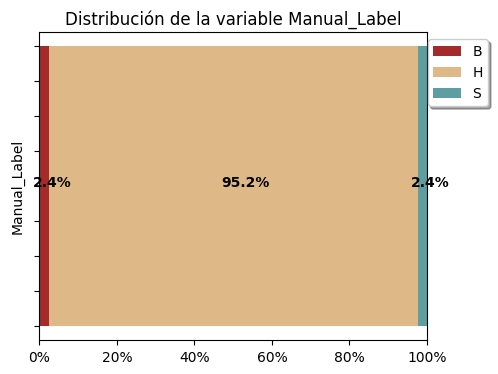

In [10]:
# 📊 Distribución de la variable objetivo
analisis_btc.distribucion_variable_predecir()

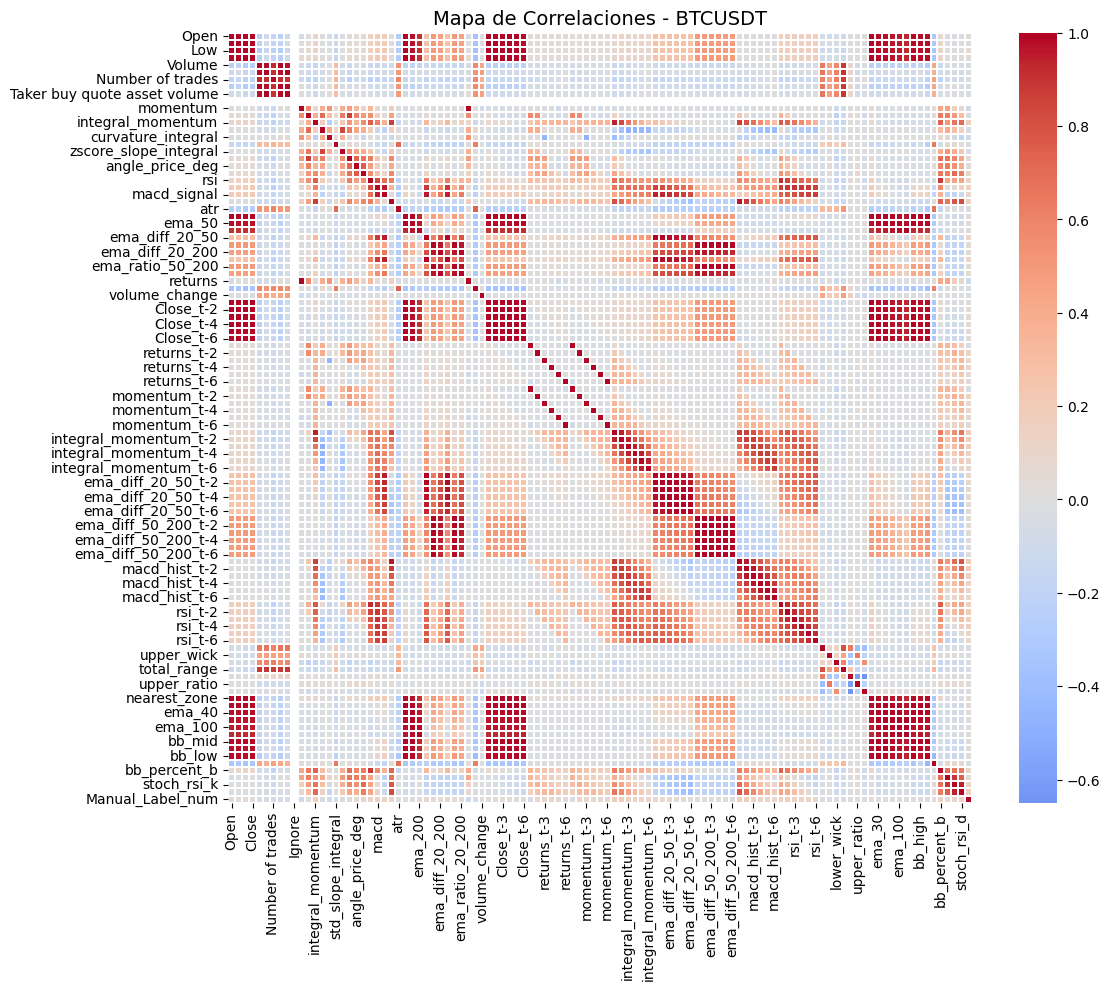


🔝 Variables más correlacionadas con la clase:

Manual_Label_num         1.000000
integral_momentum_t-1    0.195913
rsi_t-2                  0.190959
integral_momentum_t-2    0.185570
integral_momentum        0.182404
macd_hist_t-1            0.179054
macd_hist_t-2            0.177701
rsi_t-1                  0.167897
rsi_t-3                  0.158570
integral_momentum_t-3    0.153698
stoch_rsi_d              0.151445
macd_hist_t-3            0.147532
macd_hist                0.146450
rsi_t-4                  0.137566
macd                     0.134666
Name: Manual_Label_num, dtype: float64


In [122]:
# ======================================================
# 📊 PASO 2 — Correlaciones numéricas y con la clase
# ======================================================

df_corr = df_btc.copy()

# Aseguramos que el target esté como numérico (0, 1, 2)
df_corr["Manual_Label_num"] = df_corr["Manual_Label"].astype("category").cat.codes

# Convertimos solo las columnas numéricas (incluyendo la target)
numeric_cols = df_corr.select_dtypes(include=["number"]).columns
corr = df_corr[numeric_cols].corr()

# 🔍 Validamos que el target esté presente
if "Manual_Label_num" not in corr.columns:
    print("⚠️ No se encontró la columna Manual_Label_num en la correlación.")
else:
    # 📈 Mapa de calor de correlaciones
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
    plt.title("Mapa de Correlaciones - BTCUSDT", fontsize=14)
    plt.show()

    # 🔝 Variables más correlacionadas con la clase
    corr_target = corr["Manual_Label_num"].sort_values(ascending=False)
    print("\n🔝 Variables más correlacionadas con la clase:\n")
    print(corr_target.head(15))



📊 Variable: integral_momentum_t-1


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: rsi_t-2


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: integral_momentum_t-2


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: integral_momentum


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: macd_hist_t-1


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: macd_hist_t-2


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: rsi_t-1


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: rsi_t-3


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.





📊 Variable: integral_momentum_t-3


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




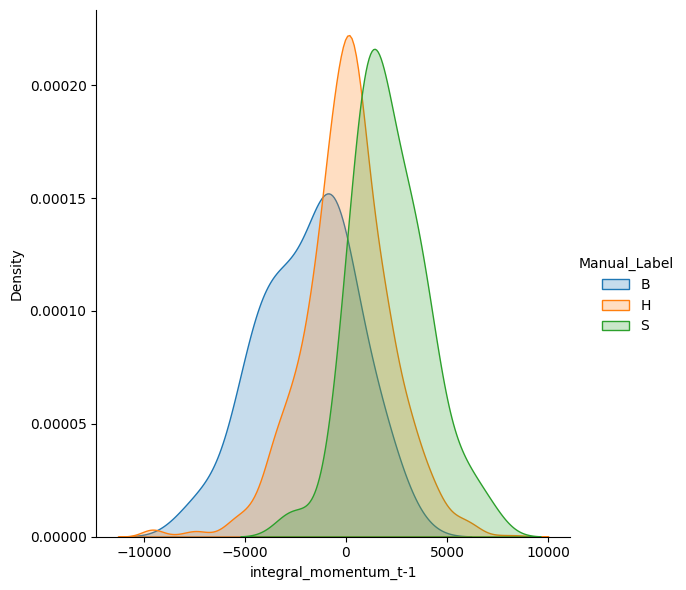

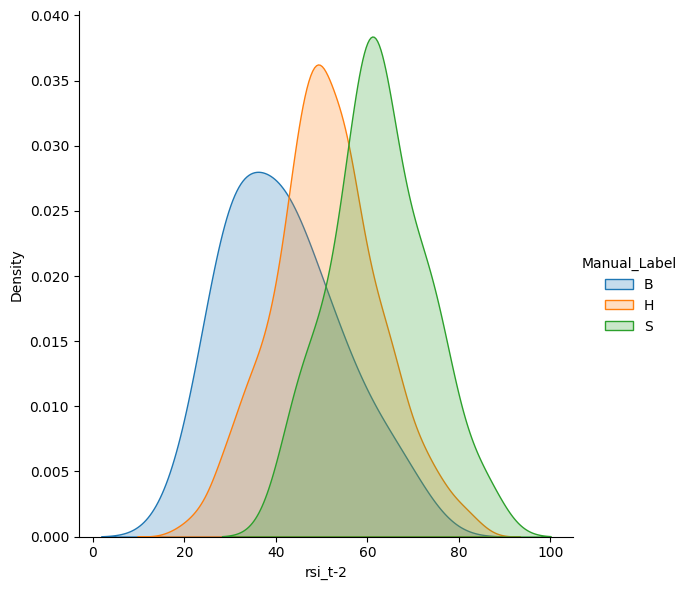

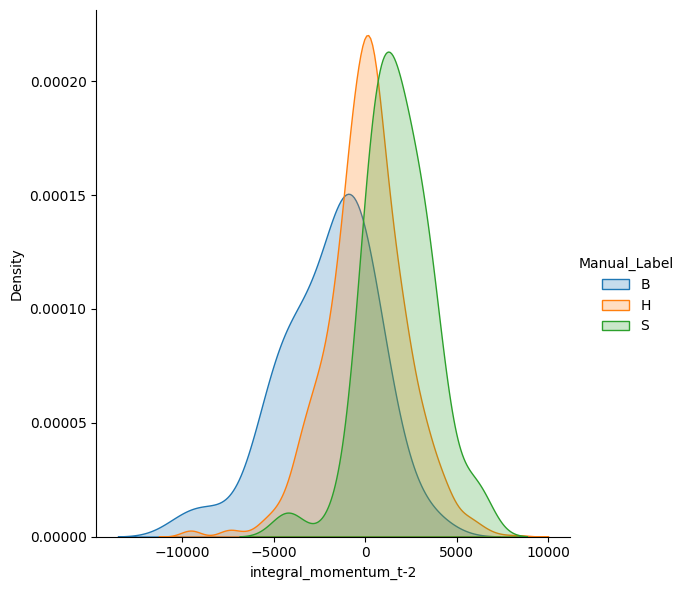

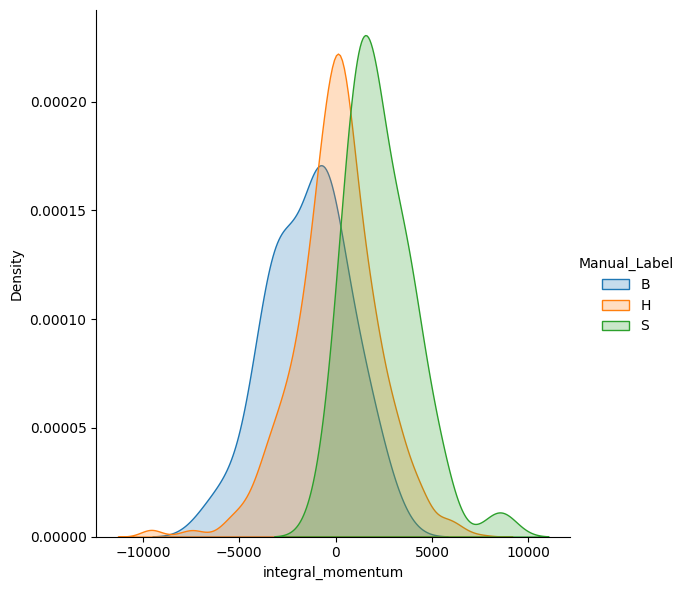

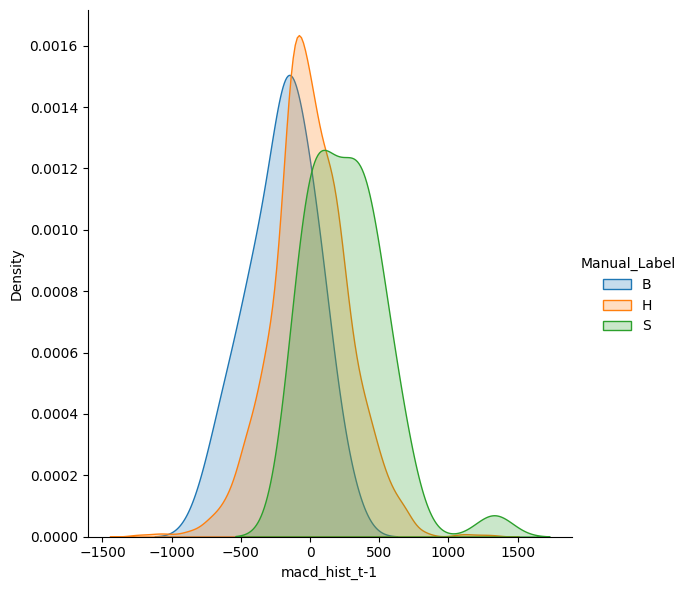

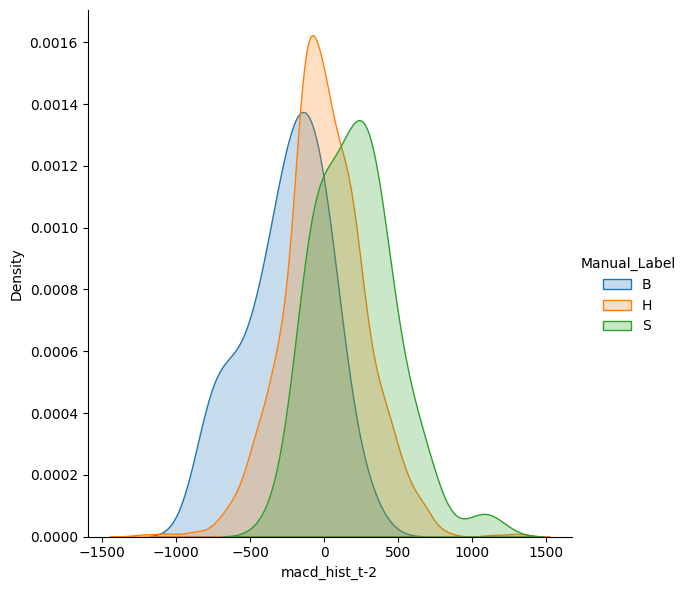

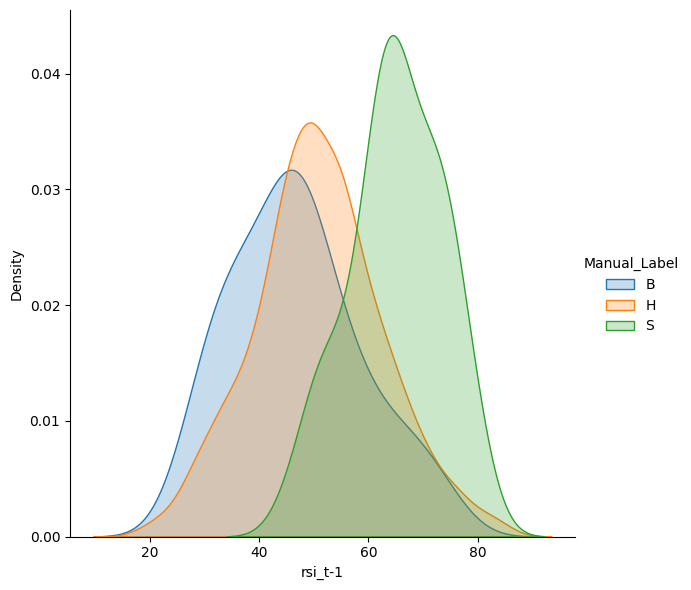

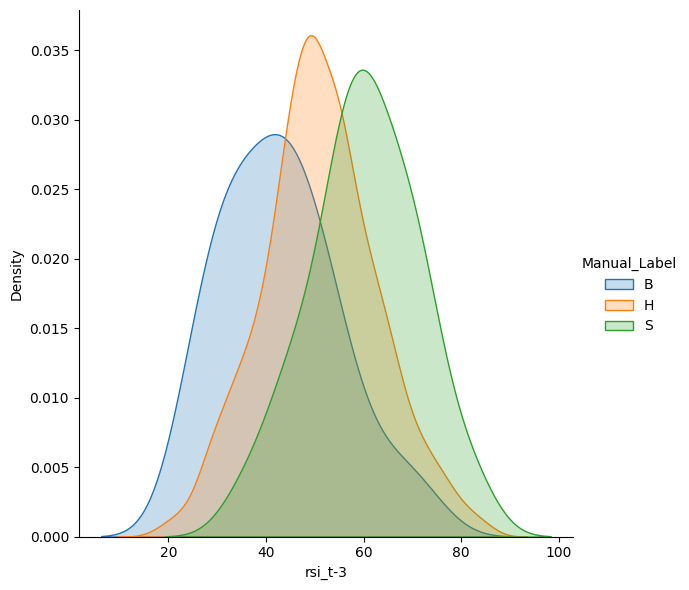

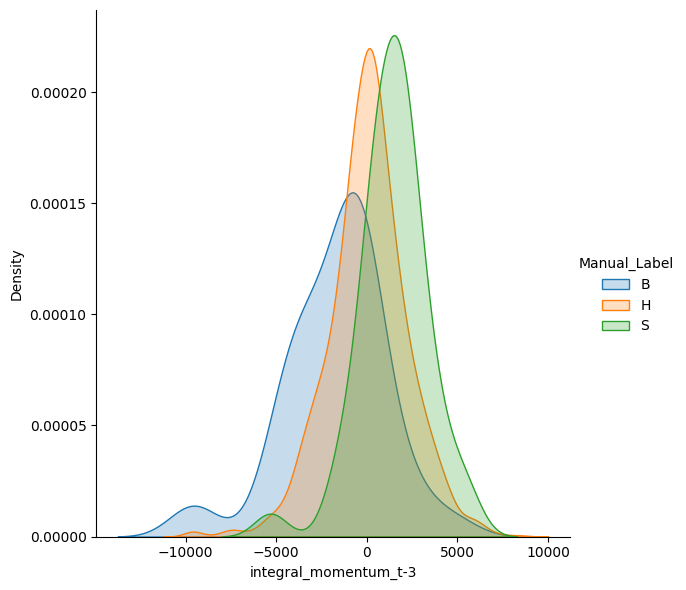

In [123]:
# Variables numéricas
columnas_numericas = df_btc.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Seleccionamos las 10 más correlacionadas (para visualización)
top_vars = corr_target.abs().sort_values(ascending=False).head(10).index
top_vars = [v for v in top_vars if v != "Manual_Label_num"]

# 🔍 Graficamos densidades
for var in top_vars:
    print(f"\n📊 Variable: {var}")
    analisis_btc.poder_predictivo_numerica(var)



📊 Variable categórica: Symbol

📊 Variable categórica: Candle_Type

📊 Variable categórica: pattern

📊 Variable categórica: sr_zone


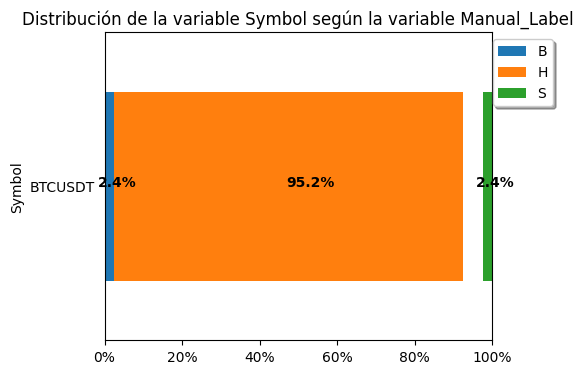

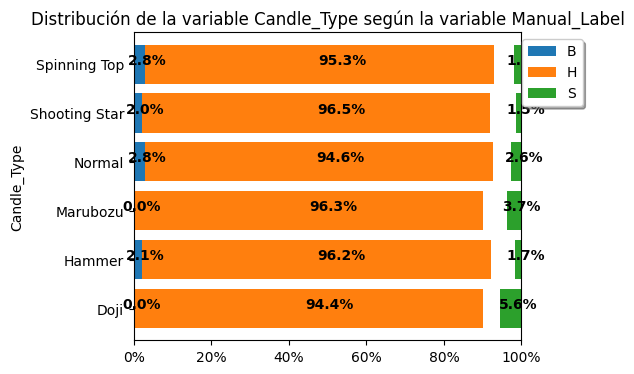

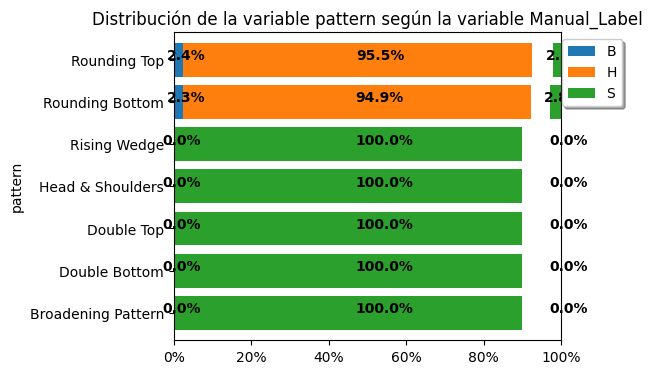

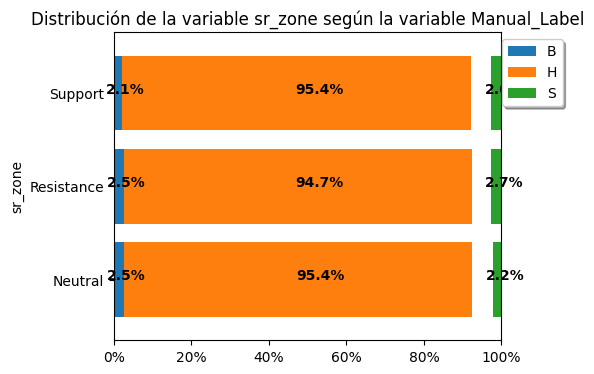

In [124]:
# Variables categóricas
columnas_categoricas = df_btc.select_dtypes(include=["object", "category"]).columns.tolist()

# 🔍 Graficamos su poder predictivo
for var in columnas_categoricas:
    if var not in ["Manual_Label"]:  # Excluimos el target
        print(f"\n📊 Variable categórica: {var}")
        analisis_btc.poder_predictivo_categorica(var)


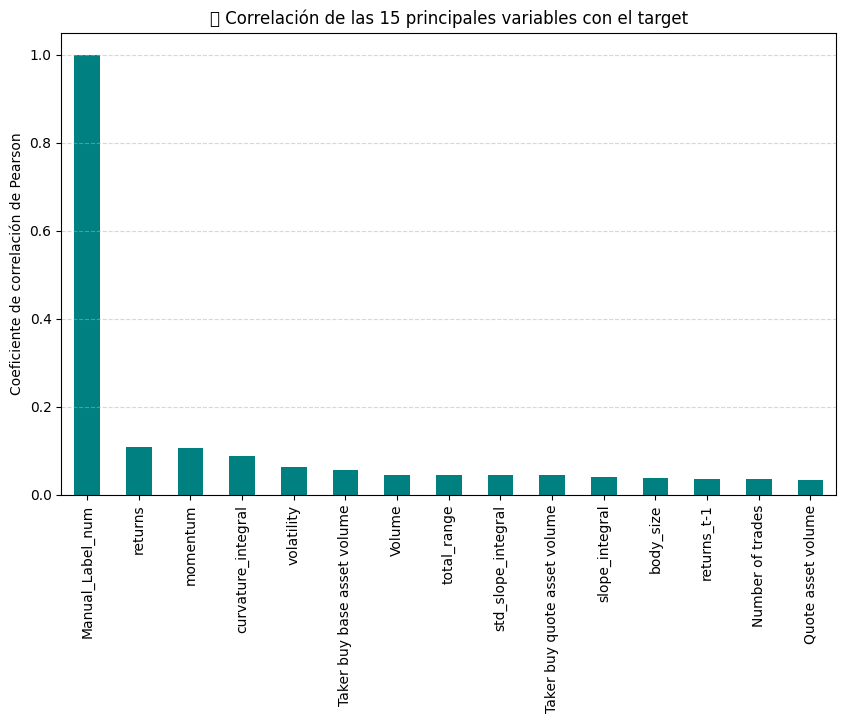


📈 Top 15 correlaciones con el target:
Manual_Label_num                1.000000
returns                         0.109266
momentum                        0.105849
curvature_integral              0.087754
volatility                      0.062435
Taker buy base asset volume     0.056462
Volume                          0.045770
total_range                     0.045097
std_slope_integral              0.044891
Taker buy quote asset volume    0.044096
slope_integral                  0.041366
body_size                       0.037615
returns_t-1                     0.036677
Number of trades                0.035754
Quote asset volume              0.033637
Name: Manual_Label_num, dtype: float64


In [125]:
# ======================================================
# 🔹 Cálculo de correlación solo con variables numéricas
# ======================================================

# Crear una copia del dataset base
df_corr = df_btc.copy()

# Asegurar la creación del target numérico
if "Manual_Label_num" not in df_corr.columns:
    df_corr["Manual_Label_num"] = df_corr["Manual_Label"].map({"B": 1, "S": -1, "H": 0}).astype(float)
else:
    df_corr["Manual_Label_num"] = df_corr["Manual_Label_num"].astype(float)

# Seleccionar solo columnas numéricas + target
cols_num = df_corr.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Asegurar que el target esté incluido en la lista
if "Manual_Label_num" not in cols_num:
    cols_num.append("Manual_Label_num")

# Subset de solo variables numéricas
df_corr_num = df_corr[cols_num]

# Calcular la matriz de correlación
corr = df_corr_num.corr()

# Obtener correlación con el target
correlaciones_simple = corr["Manual_Label_num"].sort_values(ascending=False)

# Graficar top 15 variables más correlacionadas
plt.figure(figsize=(10, 6))
correlaciones_simple.head(15).plot(kind="bar", color="teal")
plt.title("🔹 Correlación de las 15 principales variables con el target")
plt.ylabel("Coeficiente de correlación de Pearson")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Mostrar las variables más correlacionadas
print("\n📈 Top 15 correlaciones con el target:")
print(correlaciones_simple.head(15))


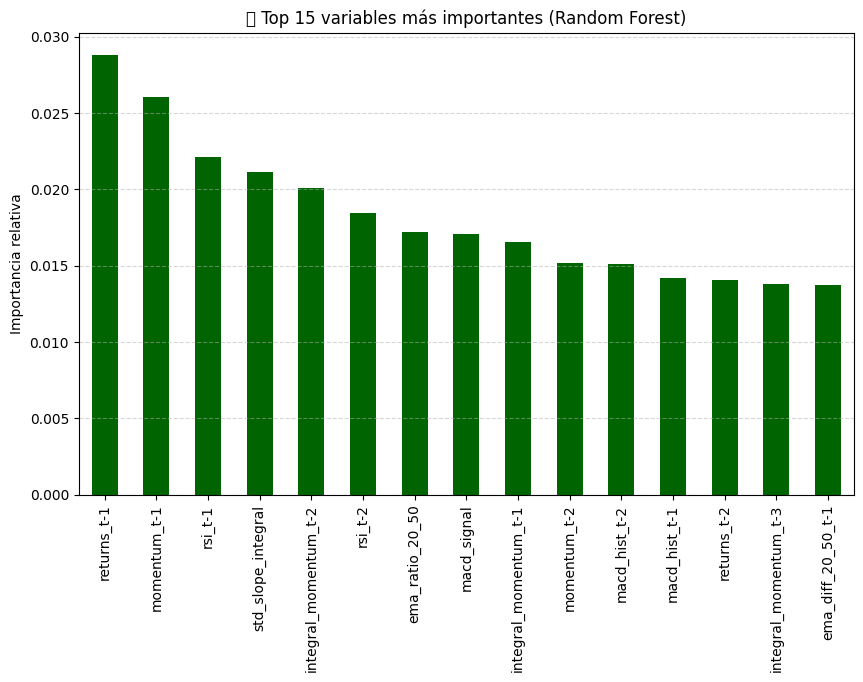


🏆 TOP 15 VARIABLES MÁS IMPORTANTES SEGÚN RANDOM FOREST

returns_t-1              0.028825
momentum_t-1             0.026084
rsi_t-1                  0.022138
std_slope_integral       0.021140
integral_momentum_t-2    0.020088
rsi_t-2                  0.018467
ema_ratio_20_50          0.017191
macd_signal              0.017078
integral_momentum_t-1    0.016573
momentum_t-2             0.015161
macd_hist_t-2            0.015135
macd_hist_t-1            0.014197
returns_t-2              0.014071
integral_momentum_t-3    0.013830
ema_diff_20_50_t-1       0.013745
dtype: float64


In [126]:
# ======================================================
# 🌲 BLOQUE — Ranking de Importancia de Variables
# ======================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1️⃣ Preparar los datos ---
df_rf = df_btc.copy()

# Asegurar que el target numérico exista
if "Manual_Label_num" not in df_rf.columns:
    df_rf["Manual_Label_num"] = df_rf["Manual_Label"].map({"B": 1, "S": -1, "H": 0}).astype(float)
else:
    df_rf["Manual_Label_num"] = df_rf["Manual_Label_num"].astype(float)

# --- 2️⃣ Seleccionar variables numéricas ---
numeric_cols = df_rf.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Aseguramos que el target esté al final
if "Manual_Label_num" not in numeric_cols:
    numeric_cols.append("Manual_Label_num")

# Crear dataset numérico completo
df_rf_num = df_rf[numeric_cols].copy()

# Separar variables predictoras y target
X = df_rf_num.drop(columns=["Manual_Label_num"], errors="ignore")
y = df_rf_num["Manual_Label_num"]

# --- 3️⃣ Estandarizar ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4️⃣ División entrenamiento / prueba ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)

# --- 5️⃣ Entrenar modelo ---
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- 6️⃣ Importancia de variables ---
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# --- 7️⃣ Visualización ---
plt.figure(figsize=(10, 6))
importancias.head(15).plot(kind="bar", color="darkgreen")
plt.title("🌲 Top 15 variables más importantes (Random Forest)")
plt.ylabel("Importancia relativa")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# --- 8️⃣ Mostrar resultados ---
print("\n🏆 TOP 15 VARIABLES MÁS IMPORTANTES SEGÚN RANDOM FOREST\n")
print(importancias.head(15))


# Imputacion importante de datos

In [12]:
def fill_pattern_no_pattern(df):
    df = df.copy()
    if "pattern" in df.columns:
        # asegurar tipo category
        if not pd.api.types.is_categorical_dtype(df["pattern"]):
            df["pattern"] = df["pattern"].astype("category")
        # agregar categoría si hace falta
        if "No Pattern" not in df["pattern"].cat.categories:
            df["pattern"] = df["pattern"].cat.add_categories(["No Pattern"])
        # reemplazar NaN
        df["pattern"] = df["pattern"].fillna("No Pattern")
    return df

df_btc = fill_pattern_no_pattern(df_btc)
df_eth = fill_pattern_no_pattern(df_eth)
df_ada = fill_pattern_no_pattern(df_ada)
df_xrp = fill_pattern_no_pattern(df_xrp)
df_bnb = fill_pattern_no_pattern(df_bnb)

# chequeo rápido
for nombre, df in {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}.items():
    if "pattern" in df.columns:
        na_count = df["pattern"].isna().sum()
        print(f"{nombre}: pattern NaN = {na_count}, categorías = {list(df['pattern'].cat.categories)}")


BTCUSDT: pattern NaN = 0, categorías = ['Broadening Pattern', 'Double Bottom', 'Double Top', 'Head & Shoulders', 'Rising Wedge', 'Rounding Bottom', 'Rounding Top', 'No Pattern']
ETHUSDT: pattern NaN = 0, categorías = ['Broadening Pattern', 'Cup & Handle', 'Diamond Pattern', 'Double Bottom', 'Double Top', 'Falling Wedge', 'Head & Shoulders', 'Rising Wedge', 'Rounding Bottom', 'Rounding Top', 'No Pattern']
ADAUSDT: pattern NaN = 0, categorías = ['Broadening Pattern', 'Cup & Handle', 'Diamond Pattern', 'Double Bottom', 'Double Top', 'Falling Wedge', 'Head & Shoulders', 'No Pattern']
XRPUSDT: pattern NaN = 0, categorías = ['Broadening Pattern', 'Cup & Handle', 'Diamond Pattern', 'Double Bottom', 'Double Top', 'Falling Wedge', 'Head & Shoulders', 'Rising Wedge', 'No Pattern']
BNBUSDT: pattern NaN = 0, categorías = ['Broadening Pattern', 'Cup & Handle', 'Diamond Pattern', 'Double Bottom', 'Double Top', 'Falling Wedge', 'Head & Shoulders', 'Rising Wedge', 'Rounding Bottom', 'Rounding Top', 'N

In [13]:
def imputar_tecnicos(df):
    df = df.copy()
    columnas_con_nans = df.columns[df.isna().any()].tolist()
    print(f"🧠 Imputando {len(columnas_con_nans)} columnas con NaN → {columnas_con_nans[:10]}{'...' if len(columnas_con_nans)>10 else ''}")
    
    # Rellenar hacia adelante (ffill), y si quedaran NaNs iniciales, usar bfill
    df[columnas_con_nans] = df[columnas_con_nans].ffill().bfill()
    
    # Verificación final
    n_restantes = df.isna().sum().sum()
    print(f"✅ NaN restantes después de imputación: {n_restantes}\n")
    return df


df_btc = imputar_tecnicos(df_btc)
df_eth = imputar_tecnicos(df_eth)
df_ada = imputar_tecnicos(df_ada)
df_xrp = imputar_tecnicos(df_xrp)
df_bnb = imputar_tecnicos(df_bnb)


🧠 Imputando 13 columnas con NaN → ['ema_30', 'ema_40', 'ema_70', 'ema_100', 'ema_150', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'bb_percent_b']...
✅ NaN restantes después de imputación: 0

🧠 Imputando 13 columnas con NaN → ['ema_30', 'ema_40', 'ema_70', 'ema_100', 'ema_150', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'bb_percent_b']...
✅ NaN restantes después de imputación: 0

🧠 Imputando 13 columnas con NaN → ['ema_30', 'ema_40', 'ema_70', 'ema_100', 'ema_150', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'bb_percent_b']...
✅ NaN restantes después de imputación: 0

🧠 Imputando 13 columnas con NaN → ['ema_30', 'ema_40', 'ema_70', 'ema_100', 'ema_150', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'bb_percent_b']...
✅ NaN restantes después de imputación: 0

🧠 Imputando 13 columnas con NaN → ['ema_30', 'ema_40', 'ema_70', 'ema_100', 'ema_150', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'bb_percent_b']...
✅ NaN restantes después de imputación: 0



In [14]:
# ============================================================
# 🔍 DETECCIÓN DE NaNs EN LOS DATASETS
# ============================================================
for nombre, df in {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}.items():
    total_nans = df.isna().sum().sum()
    if total_nans == 0:
        print(f"✅ {nombre}: sin valores NaN.")
    else:
        print(f"\n⚠️ {nombre}: {total_nans} valores NaN detectados.")
        print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).head(10))


✅ BTCUSDT: sin valores NaN.
✅ ETHUSDT: sin valores NaN.
✅ ADAUSDT: sin valores NaN.
✅ XRPUSDT: sin valores NaN.
✅ BNBUSDT: sin valores NaN.


# Empezamos Hiperparametrizacion para modelos predictivos

## KNN

✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

🔍 Ejecutando optimizaciones para BTCUSDT (MOV)...
🔍 Ejecutando optimizaciones para ETHUSDT (MOV)...
🔍 Ejecutando optimizaciones para ADAUSDT (MOV)...
🔍 Ejecutando optimizaciones para XRPUSDT (MOV)...
🔍 Ejecutando optimizaciones para BNBUSDT (MOV)...

🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)

🔍 Ejecutando optimizaciones para BTCUSDT (DIR)...
⚠️ BTCUSDT: dataset pequeño (86 muestras), se omite Halving.
🔍 Ejecutando optimizaciones para ETHUSDT (DIR)...
⚠️ ETHUSDT: dataset pequeño (94 muestras), se omite Halving.
🔍 Ejecutando optimizaciones para ADAUSDT (DIR)...
⚠️ ADAUSDT: dataset pequeño (92 muestras), se omite Halving.
🔍 Ejecutando optimizaciones para XRPUSDT (DIR)...
⚠️ XRPUSDT: dataset pequeño (94 muestras), se omite Halving.
🔍 Ejecutando optimizaciones para BNBUSDT (DIR)...
⚠️ BNBUSDT: dataset pequeño (88 muestras), se omite Halving.

🏆 RESULTADOS COMPARATIVOS — KNN EN CADENA (MOV + DIR)
   Dataset        Tip

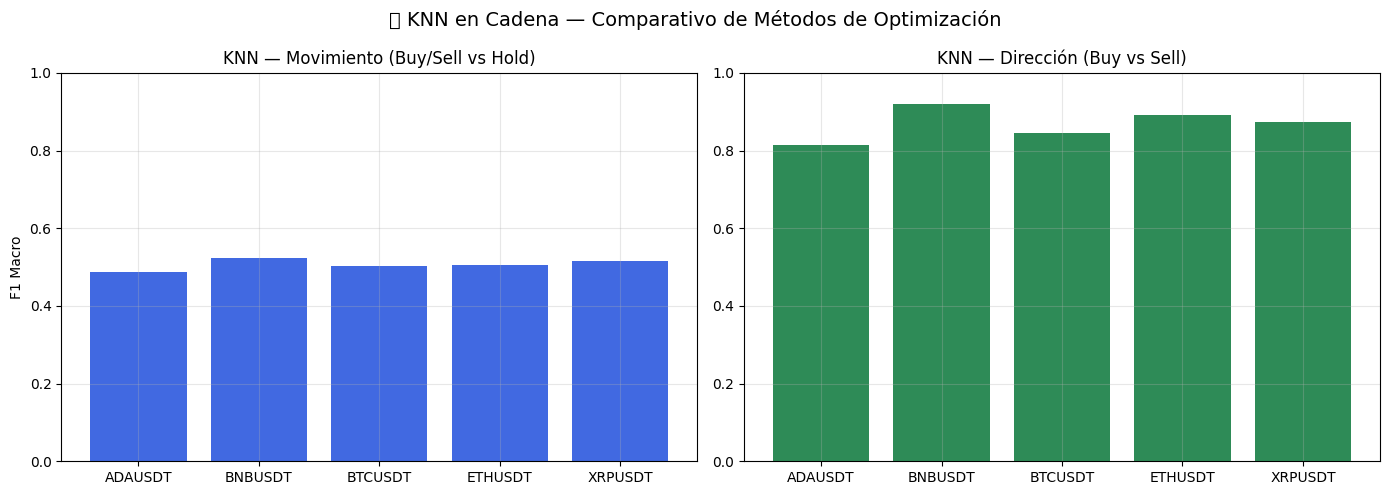


📊 RESUMEN FINAL — Mejor método por Dataset y Etapa:


Metodo             F1_CV_Promedio           
Tipo      Dirección  Movimiento      Dirección Movimiento
Dataset                                                  
ADAUSDT  GridSearch     Halving         0.8147     0.4862
BNBUSDT  GridSearch  Randomized         0.9208     0.5233
BTCUSDT  GridSearch     Halving         0.8457     0.5038
ETHUSDT  Randomized  Randomized         0.8925     0.5057
XRPUSDT  GridSearch  GridSearch         0.8726     0.5144

In [134]:
# ===============================================================
# 🧩 MODELO EN CADENA KNN — MOVIMIENTO Y DIRECCIÓN
#    con comparación entre Grid, Random, Halving y BayesSearchCV
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV,
    RandomizedSearchCV
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import Parallel, delayed

# ✅ Importar ambas versiones de pipeline al inicio del script:
from sklearn.pipeline import Pipeline          # sin SMOTE (Halving)
from imblearn.pipeline import Pipeline as ImbPipeline  # con SMOTE


# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_macro = make_scorer(f1_score, average="macro")
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
num_cores = multiprocessing.cpu_count()

print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================

def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

def ejecutar_busquedas(nombre, X, y, tipo):
    """
    Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes)
    para un dataset y tipo (Movimiento o Dirección), manejando casos con pocas clases.
    """

    # -----------------------------------------------------------
    # 🔍 1️⃣ Validación básica de clases
    # -----------------------------------------------------------
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    # -----------------------------------------------------------
    # 🧩 2️⃣ Pipeline base con SMOTE
    # -----------------------------------------------------------
    preproc = crear_preprocesador(X)
    base_pipe = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(random_state=42, k_neighbors=2)),
        ("model", KNeighborsClassifier())
    ])

    # -----------------------------------------------------------
    # ⚙️ 3️⃣ Espacios de búsqueda
    # -----------------------------------------------------------
    param_grid = {
        "model__n_neighbors": [3, 5, 7, 9, 11, 13, 15],
        "model__algorithm": ["ball_tree", "kd_tree", "brute"],
        "model__p": [1, 2, 3]
    }

    param_dist = {
        "model__n_neighbors": randint(3, 16),
        "model__algorithm": ["ball_tree", "kd_tree", "brute"],
        "model__p": randint(1, 4)
    }

    param_bayes = {
        "model__n_neighbors": Integer(3, 15),
        "model__algorithm": Categorical(["ball_tree", "kd_tree", "brute"]),
        "model__p": Integer(1, 3)
    }

    resultados = []

    # -----------------------------------------------------------
    # 🔹 4️⃣ GridSearchCV
    # -----------------------------------------------------------
    grid = GridSearchCV(
        base_pipe,
        param_grid,
        scoring=f1_macro,
        cv=cv3,
        n_jobs=-1,
        refit=True,
        error_score=np.nan
    )
    grid.fit(X, y)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))

    # -----------------------------------------------------------
    # 🔹 5️⃣ RandomizedSearchCV
    # -----------------------------------------------------------
    rand = RandomizedSearchCV(
        base_pipe,
        param_distributions=param_dist,
        n_iter=60,
        scoring=f1_macro,
        cv=cv3,
        n_jobs=-1,
        random_state=42,
        error_score=np.nan
    )
    rand.fit(X, y)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))

    # -----------------------------------------------------------
    # 🔹 6️⃣ HalvingRandomSearchCV — sin SMOTE + chequeo de tamaño
    # -----------------------------------------------------------
    if len(y) < 300:
        print(f"⚠️ {nombre}: dataset pequeño ({len(y)} muestras), se omite Halving.")
    else:
        halv = HalvingRandomSearchCV(
            Pipeline([  # 👈 versión sin SMOTE
                ("preprocessor", preproc),
                ("model", KNeighborsClassifier())
            ]),
            param_distributions=param_dist,
            scoring=f1_macro,
            cv=cv3,
            factor=3,
            n_jobs=-1,
            random_state=42,
            error_score=np.nan
        )
        halv.fit(X, y)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))

    # -----------------------------------------------------------
    # 🔹 7️⃣ BayesSearchCV
    # -----------------------------------------------------------
    bayes = BayesSearchCV(
        base_pipe,
        search_spaces=param_bayes,
        n_iter=40,
        scoring=f1_macro,
        cv=cv3,
        n_jobs=-1,
        random_state=42,
        error_score=np.nan
    )
    bayes.fit(X, y)
    resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))

    # -----------------------------------------------------------
    # 📊 8️⃣ Consolidar resultados en DataFrame
    # -----------------------------------------------------------
    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo

    return df




# ===============================================================
# 🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)
# ===============================================================
print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")

df_results_mov = []

for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20:
        print(f"⚠️ {nombre}: muy pocos movimientos detectados, se omite.")
        continue

    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]

    print(f"🔍 Ejecutando optimizaciones para {nombre} (MOV)...")
    df_local = ejecutar_busquedas(nombre, X, y, tipo="Movimiento")
    df_results_mov.append(df_local)

df_results_mov = pd.concat(df_results_mov, ignore_index=True)

# ===============================================================
# 🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)
# ===============================================================
print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")

df_results_dir = []

for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60:
        print(f"⚠️ {nombre}: muy pocos casos B/S ({len(df_dir)}), se omite.")
        continue

    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]

    print(f"🔍 Ejecutando optimizaciones para {nombre} (DIR)...")
    df_local = ejecutar_busquedas(nombre, X, y, tipo="Dirección")
    df_results_dir.append(df_local)

df_results_dir = pd.concat(df_results_dir, ignore_index=True)

# ===============================================================
# 🏁 COMPARATIVO FINAL
# ===============================================================
df_final = pd.concat([df_results_mov, df_results_dir], ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)

# Mejor método por dataset y tipo
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

print("\n🏆 RESULTADOS COMPARATIVOS — KNN EN CADENA (MOV + DIR)")
print(df_best[["Dataset", "Tipo", "Metodo", "F1_CV_Promedio", "Mejores Parámetros"]])

# ===============================================================
# 📊 VISUALIZACIONES
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Movimiento
mov_plot = df_best[df_best["Tipo"]=="Movimiento"]
axes[0].bar(mov_plot["Dataset"], mov_plot["F1_CV_Promedio"], color="royalblue")
axes[0].set_title("KNN — Movimiento (Buy/Sell vs Hold)")
axes[0].set_ylabel("F1 Macro")
axes[0].set_ylim(0,1)
axes[0].grid(alpha=0.3)

# Dirección
dir_plot = df_best[df_best["Tipo"]=="Dirección"]
axes[1].bar(dir_plot["Dataset"], dir_plot["F1_CV_Promedio"], color="seagreen")
axes[1].set_title("KNN — Dirección (Buy vs Sell)")
axes[1].set_ylim(0,1)
axes[1].grid(alpha=0.3)

plt.suptitle("📈 KNN en Cadena — Comparativo de Métodos de Optimización", fontsize=14)
plt.tight_layout()
plt.show()

# ===============================================================
# 📋 TABLA CONSOLIDADA RESUMEN FINAL
# ===============================================================
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio"])
print("\n📊 RESUMEN FINAL — Mejor método por Dataset y Etapa:")
display(df_summary)



🏆 RESULTADOS COMPARATIVOS — KNN EN CADENA (MOV + DIR)
   Dataset        Tipo      Metodo  F1_CV_Promedio  \
0  ADAUSDT   Dirección  GridSearch          0.8147   
1  ADAUSDT  Movimiento     Halving          0.4862   
2  BNBUSDT   Dirección  GridSearch          0.9208   
3  BNBUSDT  Movimiento  Randomized          0.5233   
4  BTCUSDT   Dirección  GridSearch          0.8457   
5  BTCUSDT  Movimiento     Halving          0.5038   
6  ETHUSDT   Dirección  Randomized          0.8925   
7  ETHUSDT  Movimiento  Randomized          0.5057   
8  XRPUSDT   Dirección  GridSearch          0.8726   
9  XRPUSDT  Movimiento  GridSearch          0.5144   

                                  Mejores Parámetros  
0  {'model__algorithm': 'ball_tree', 'model__n_ne...  
1  {'model__algorithm': 'ball_tree', 'model__n_ne...  
2  {'model__algorithm': 'ball_tree', 'model__n_ne...  
3  {'model__algorithm': 'ball_tree', 'model__n_ne...  
4  {'model__algorithm': 'ball_tree', 'model__n_ne...  
5  {'model__algorith

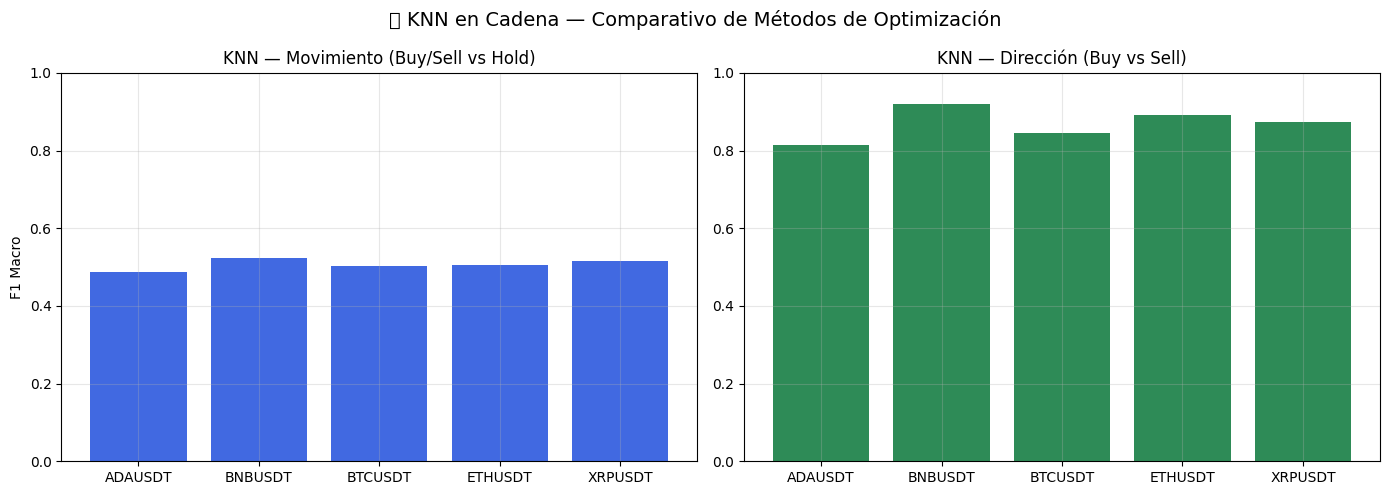


📊 RESUMEN FINAL — Mejor método y parámetros por Dataset y Etapa:


Metodo             F1_CV_Promedio             \
Tipo      Dirección  Movimiento      Dirección Movimiento   
Dataset                                                     
ADAUSDT  GridSearch     Halving         0.8147     0.4862   
BNBUSDT  GridSearch  Randomized         0.9208     0.5233   
BTCUSDT  GridSearch     Halving         0.8457     0.5038   
ETHUSDT  Randomized  Randomized         0.8925     0.5057   
XRPUSDT  GridSearch  GridSearch         0.8726     0.5144   

                                           Hiperparámetros  \
Tipo                                             Dirección   
Dataset                                                      
ADAUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...   
BNBUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...   
BTCUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...   
ETHUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...   
XRPUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...   

                                                            
Tipo                                            Movimiento  
Dataset                                                     
ADAUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...  
BNBUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...  
BTCUSDT  'model__algorithm': 'brute', 'model__n_neighbo...  
ETHUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...  
XRPUSDT  'model__algorithm': 'ball_tree', 'model__n_nei...

In [135]:
# ===============================================================
# 🏁 COMPARATIVO FINAL AJUSTADO — CON PARÁMETROS GANADORES
# ===============================================================

df_final = pd.concat([df_results_mov, df_results_dir], ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)

# Mejor método por dataset y tipo
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

print("\n🏆 RESULTADOS COMPARATIVOS — KNN EN CADENA (MOV + DIR)")
print(df_best[["Dataset", "Tipo", "Metodo", "F1_CV_Promedio", "Mejores Parámetros"]])

# ===============================================================
# 📊 VISUALIZACIONES
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Movimiento
mov_plot = df_best[df_best["Tipo"]=="Movimiento"]
axes[0].bar(mov_plot["Dataset"], mov_plot["F1_CV_Promedio"], color="royalblue")
axes[0].set_title("KNN — Movimiento (Buy/Sell vs Hold)")
axes[0].set_ylabel("F1 Macro")
axes[0].set_ylim(0,1)
axes[0].grid(alpha=0.3)

# Dirección
dir_plot = df_best[df_best["Tipo"]=="Dirección"]
axes[1].bar(dir_plot["Dataset"], dir_plot["F1_CV_Promedio"], color="seagreen")
axes[1].set_title("KNN — Dirección (Buy vs Sell)")
axes[1].set_ylim(0,1)
axes[1].grid(alpha=0.3)

plt.suptitle("📈 KNN en Cadena — Comparativo de Métodos de Optimización", fontsize=14)
plt.tight_layout()
plt.show()

# ===============================================================
# 📋 TABLA CONSOLIDADA — INCLUYENDO PARÁMETROS
# ===============================================================

# Crear tabla más legible con hiperparámetros formateados
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: str(x).replace("{","").replace("}",""))

df_summary_full = (
    df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
    .sort_index()
)

print("\n📊 RESUMEN FINAL — Mejor método y parámetros por Dataset y Etapa:")
display(df_summary_full)


In [136]:
# ===============================================================
# 📋 TABLA CONSOLIDADA — VISUALIZACIÓN COMPLETA DE PARÁMETROS
# ===============================================================
pd.set_option("display.max_colwidth", None)  # 👈 permite mostrar todo el texto
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 250)

df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(
    lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()])
)

df_summary_full = (
    df_best
    .pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
    .sort_index()
)

print("\n📊 RESUMEN FINAL — Mejor método y parámetros por Dataset y Etapa (completo):")
display(df_summary_full)



📊 RESUMEN FINAL — Mejor método y parámetros por Dataset y Etapa (completo):


Metodo             F1_CV_Promedio                                      Hiperparámetros                                         
Tipo      Dirección  Movimiento      Dirección Movimiento                                 Dirección                               Movimiento
Dataset                                                                                                                                     
ADAUSDT  GridSearch     Halving         0.8147     0.4862   algorithm=ball_tree, n_neighbors=7, p=3  algorithm=ball_tree, n_neighbors=6, p=2
BNBUSDT  GridSearch  Randomized         0.9208     0.5233   algorithm=ball_tree, n_neighbors=9, p=2  algorithm=ball_tree, n_neighbors=4, p=2
BTCUSDT  GridSearch     Halving         0.8457     0.5038   algorithm=ball_tree, n_neighbors=7, p=3      algorithm=brute, n_neighbors=5, p=3
ETHUSDT  Randomized  Randomized         0.8925     0.5057   algorithm=ball_tree, n_neighbors=4, p=3  algorithm=ball_tree, n_neighbors=4, p=2
XRPUSDT  GridSearch  GridSearch         0.8726     0.5144  algorithm=ball_tree, n_neighbors=15, p=1  algorithm=ball_tree, n_neighbors=3, p=2

## Support Vector Machines

✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

🔍 Ejecutando optimizaciones para BTCUSDT (MOV)...

📊 Evaluación fuera de muestra (BTCUSDT - Movimiento):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       171
           1     1.0000    1.0000    1.0000         9

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0000    1.0000       180

--------------------------------------------------------------------------------
🔍 Ejecutando optimizaciones para ETHUSDT (MOV)...

📊 Evaluación fuera de muestra (ETHUSDT - Movimiento):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       171
           1     1.0000    1.0000    1.0000         9

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0

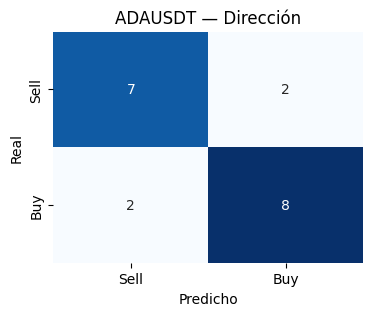


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

         0.0     0.7778    0.7778    0.7778         9
         1.0     0.8000    0.8000    0.8000        10

    accuracy                         0.7895        19
   macro avg     0.7889    0.7889    0.7889        19
weighted avg     0.7895    0.7895    0.7895        19

🔹 F1_Train: 0.9589 | F1_Test: 0.7895 | ΔF1: 0.1694
⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para ADAUSDT (Movimiento) — GridSearch


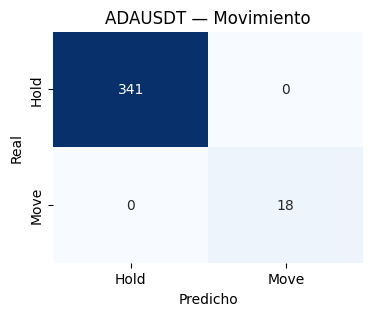


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       341
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BNBUSDT (Dirección) — GridSearch


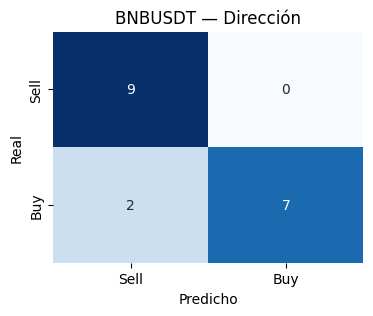


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

         0.0     0.8182    1.0000    0.9000         9
         1.0     1.0000    0.7778    0.8750         9

    accuracy                         0.8889        18
   macro avg     0.9091    0.8889    0.8875        18
weighted avg     0.9091    0.8889    0.8875        18

🔹 F1_Train: 0.9284 | F1_Test: 0.8875 | ΔF1: 0.0409
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BNBUSDT (Movimiento) — GridSearch


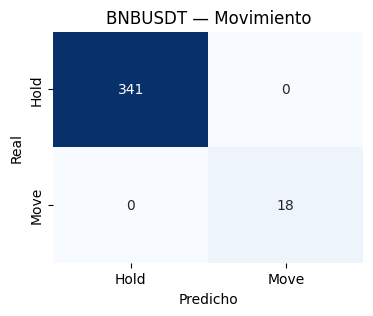


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       341
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BTCUSDT (Dirección) — GridSearch


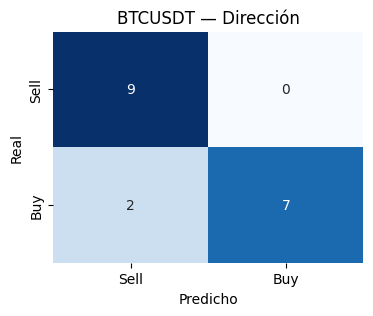


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

         0.0     0.8182    1.0000    0.9000         9
         1.0     1.0000    0.7778    0.8750         9

    accuracy                         0.8889        18
   macro avg     0.9091    0.8889    0.8875        18
weighted avg     0.9091    0.8889    0.8875        18

🔹 F1_Train: 0.8669 | F1_Test: 0.8875 | ΔF1: -0.0206
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BTCUSDT (Movimiento) — GridSearch


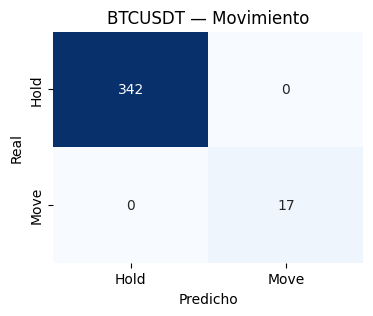


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       342
           1     1.0000    1.0000    1.0000        17

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para ETHUSDT (Dirección) — GridSearch


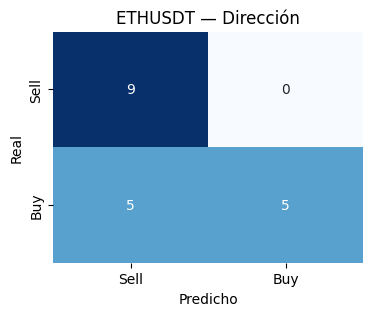


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

         0.0     0.6429    1.0000    0.7826         9
         1.0     1.0000    0.5000    0.6667        10

    accuracy                         0.7368        19
   macro avg     0.8214    0.7500    0.7246        19
weighted avg     0.8308    0.7368    0.7216        19

🔹 F1_Train: 0.9733 | F1_Test: 0.7216 | ΔF1: 0.2517
⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para ETHUSDT (Movimiento) — GridSearch


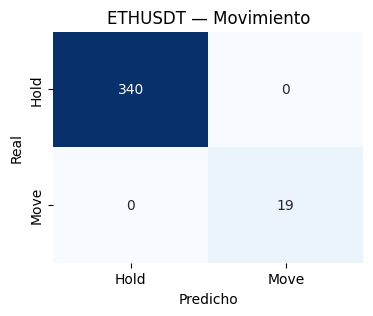


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       340
           1     1.0000    1.0000    1.0000        19

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para XRPUSDT (Dirección) — GridSearch


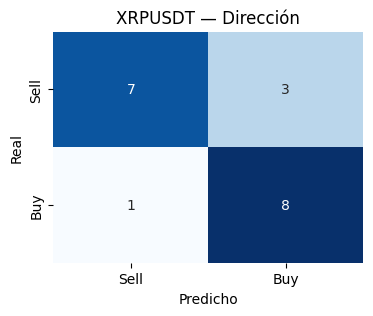


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

         0.0     0.8750    0.7000    0.7778        10
         1.0     0.7273    0.8889    0.8000         9

    accuracy                         0.7895        19
   macro avg     0.8011    0.7944    0.7889        19
weighted avg     0.8050    0.7895    0.7883        19

🔹 F1_Train: 0.9200 | F1_Test: 0.7883 | ΔF1: 0.1317
⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para XRPUSDT (Movimiento) — GridSearch


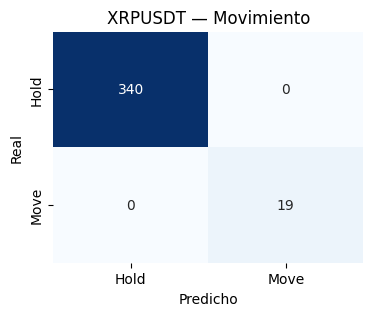


📋 Reporte de clasificación por clase:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       340
           1     1.0000    1.0000    1.0000        19

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------


,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1,Precision_Test,Recall_Test
0,ADAUSDT,Dirección,GridSearch,0.9589,0.7895,0.1694,0.7895,0.7895
1,ADAUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
2,BNBUSDT,Dirección,GridSearch,0.9284,0.8875,0.0409,0.9091,0.8889
3,BNBUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
4,BTCUSDT,Dirección,GridSearch,0.8669,0.8875,-0.0206,0.9091,0.8889
5,BTCUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
6,ETHUSDT,Dirección,GridSearch,0.9733,0.7216,0.2517,0.8308,0.7368
7,ETHUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
8,XRPUSDT,Dirección,GridSearch,0.9200,0.7883,0.1317,0.8050,0.7895
9,XRPUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000


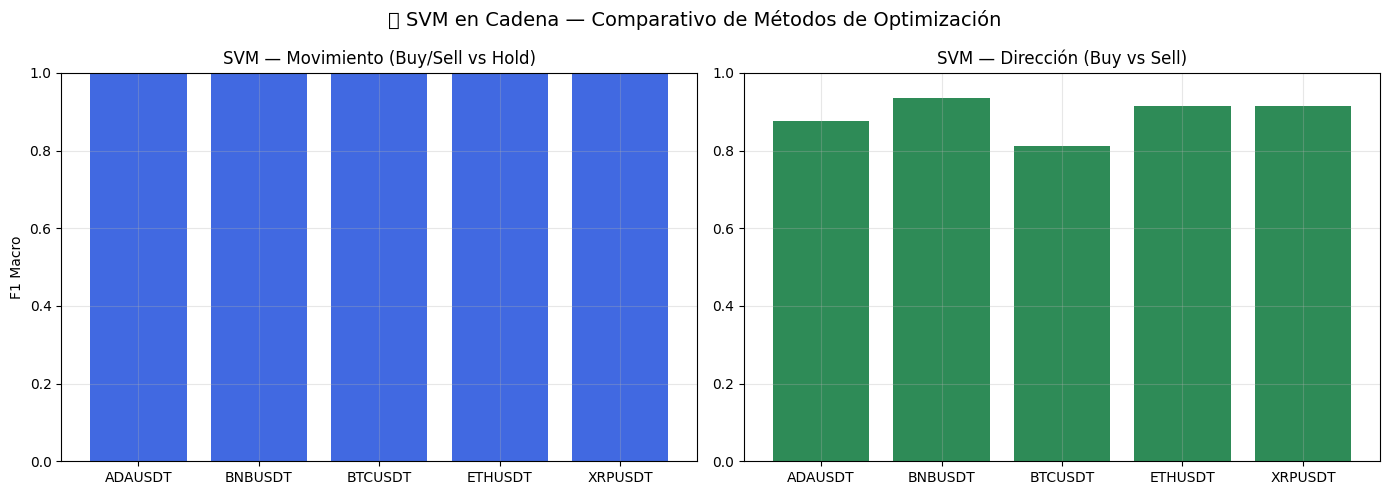


📊 RESUMEN FINAL — Mejor método por Dataset y Etapa:


Metodo             F1_CV_Promedio                                         Hiperparámetros                      
Tipo      Dirección  Movimiento      Dirección Movimiento                                    Dirección            Movimiento
Dataset                                                                                                                     
ADAUSDT  GridSearch  GridSearch         0.8762        1.0  C=50, coef0=-1, gamma=scale, kernel=sigmoid  C=0.1, kernel=linear
BNBUSDT  GridSearch  GridSearch         0.9354        1.0    C=1, coef0=-1, gamma=0.01, kernel=sigmoid  C=0.1, kernel=linear
BTCUSDT  GridSearch  GridSearch         0.8118        1.0     C=1, coef0=0, gamma=0.01, kernel=sigmoid  C=0.1, kernel=linear
ETHUSDT  GridSearch  GridSearch         0.9152        1.0        C=1, coef0=0.5, degree=2, kernel=poly  C=0.1, kernel=linear
XRPUSDT  GridSearch  GridSearch         0.9141        1.0   C=50, coef0=1, gamma=0.001, kernel=sigmoid  C=0.1, kernel=linear

In [146]:
# ===============================================================
# 🧩 MODELO EN CADENA SVM — MOVIMIENTO Y DIRECCIÓN
#    Comparativo entre Grid, Random, Halving y BayesSearchCV
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy.stats import uniform, randint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_macro = make_scorer(f1_score, average="macro")
cv7 = StratifiedKFold(n_splits=7)   # ✅ sin random_state, sin shuffle
num_cores = multiprocessing.cpu_count()

print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================

def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, make_scorer
)

def ejecutar_busquedas(nombre, X, y, tipo, usar_smote=True):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para SVM
       con F1 ponderado y métricas por clase."""
    
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    # ✅ Verificar si hay suficientes casos minoritarios
    min_class = y.value_counts().min()
    if min_class < 7:
        print(f"⚠️ {nombre}: clase minoritaria con {min_class} muestras — Halving omitido.")
        skip_halving = True
    else:
        skip_halving = False

    # ✅ División estratificada en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y
    )

    preproc = crear_preprocesador(X_train)

    # ✅ Pipeline con o sin SMOTE
    if usar_smote:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("smote", SMOTE(k_neighbors=2, random_state=42)),
            ("model", SVC(probability=True, class_weight="balanced", max_iter=5000))
        ])
    else:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("model", SVC(probability=True, class_weight="balanced", max_iter=5000))
        ])

    base_pipe_no_smote = ImbPipeline([
        ("preprocessor", preproc),
        ("model", SVC(probability=True, class_weight="balanced", max_iter=5000))
    ])

    # --- Espacios de búsqueda
    param_grid = [
        {"model__kernel": ["linear"], "model__C": [0.1, 1, 10, 50, 100]},
        {"model__kernel": ["rbf"], "model__C": [0.1, 1, 10, 50], "model__gamma": [0.001, 0.01, 0.1, "scale"]},
        {"model__kernel": ["poly"], "model__C": [0.1, 1, 10], "model__degree": [2, 3, 4], "model__coef0": [0, 0.5, 1]},
        {"model__kernel": ["sigmoid"], "model__C": [0.1, 1, 10, 50], "model__gamma": [0.001, 0.01, 0.1, "scale"], "model__coef0": [-1, 0, 1]}
    ]

    param_dist = {
        "model__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "model__C": uniform(0.01, 100),
        "model__gamma": uniform(0.0001, 1),
        "model__degree": randint(2, 5),
        "model__coef0": uniform(-1, 1)
    }

    param_bayes = {
        "model__kernel": Categorical(["linear", "rbf", "poly", "sigmoid"]),
        "model__C": Real(0.01, 100, prior="log-uniform"),
        "model__gamma": Real(0.0001, 1, prior="log-uniform"),
        "model__degree": Integer(2, 5),
        "model__coef0": Real(-1, 1)
    }

    resultados = []
    metricas_test = []

    f1_weighted = make_scorer(f1_score, average="weighted")

    # ==========================================================
    # 1️⃣ GridSearchCV
    # ==========================================================
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1, refit=True, error_score=np.nan)
    grid.fit(X_train, y_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))

    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RandomizedSearchCV
    # ==========================================================
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=60,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=None, error_score=np.nan)
    rand.fit(X_train, y_train)
    y_pred_test = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))

    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HalvingRandomSearchCV (solo si hay suficientes casos)
    # ==========================================================
    if not skip_halving:
        halv = HalvingRandomSearchCV(base_pipe_no_smote, param_distributions=param_dist,
                                     scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1,
                                     random_state=42, error_score=np.nan)
        halv.fit(X_train, y_train)
        y_pred_test = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))

        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
        })
    else:
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BayesSearchCV
    # ==========================================================
    bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=40,
                          scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42, error_score=np.nan)
    bayes.fit(X_train, y_train)
    y_pred_test = bayes.best_estimator_.predict(X_test)
    resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))

    metricas_test.append({
        "Metodo": "BayesSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 📊 Reporte detallado fuera de muestra
    # ==========================================================
    print(f"\n📊 Evaluación fuera de muestra ({nombre} - {tipo}):")
    print(classification_report(y_test, y_pred_test, digits=4))
    print("-" * 80)

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo

    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo

    # Fusionar métricas con los resultados
    df_final_local = df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

    return df_final_local


# ===============================================================
# 🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)
# ===============================================================
print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")

df_results_mov = []

for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20:
        print(f"⚠️ {nombre}: muy pocos movimientos detectados, se omite.")
        continue

    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]

    print(f"🔍 Ejecutando optimizaciones para {nombre} (MOV)...")
    df_local = ejecutar_busquedas(nombre, X, y, tipo="Movimiento")
    df_results_mov.append(df_local)

df_results_mov = pd.concat(df_results_mov, ignore_index=True)

# ===============================================================
# 🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)
# ===============================================================
print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")

df_results_dir = []

for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60:
        print(f"⚠️ {nombre}: muy pocos casos B/S ({len(df_dir)}), se omite.")
        continue

    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]

    print(f"🔍 Ejecutando optimizaciones para {nombre} (DIR)...")
    df_local = ejecutar_busquedas(nombre, X, y, tipo="Dirección")
    df_results_dir.append(df_local)

df_results_dir = pd.concat(df_results_dir, ignore_index=True)

# ===============================================================
# 🏁 COMPARATIVO FINAL
# ===============================================================
df_final = pd.concat([df_results_mov, df_results_dir], ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)

df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

print("\n🏆 RESULTADOS COMPARATIVOS — SVM EN CADENA (MOV + DIR)")
print(df_best[["Dataset", "Tipo", "Metodo", "F1_CV_Promedio", "Mejores Parámetros"]])

# ===============================================================
# 🧩 BLOQUE — DETECCIÓN DE OVERFITTING Y VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

resumen_generalizacion = []

print("\n🧠 VALIDACIÓN DE GENERALIZACIÓN Y DETECCIÓN DE OVERFITTING")
print("==========================================================\n")

for _, fila in df_best.iterrows():
    dataset = fila["Dataset"]
    tipo = fila["Tipo"]
    metodo = fila["Metodo"]

    print(f"\n🔍 Evaluando sobreajuste para {dataset} ({tipo}) — {metodo}")
    df = datasets_raw[dataset].copy()

    # --- Reconstruir variable objetivo
    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
        y = df["Label_Move"]
    else:  # Dirección
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
        y = df_dir["Label_Direction"]

    # --- División estratificada
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    preproc = crear_preprocesador(X_train)
    modelo = SVC(
        probability=True,
        class_weight="balanced",
        max_iter=5000,
        **{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items()}
    )

    pipe_final = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", modelo)
    ])

    pipe_final.fit(X_train, y_train)

    # --- Predicciones
    y_pred_train = pipe_final.predict(X_train)
    y_pred_test = pipe_final.predict(X_test)

    # --- Métricas
    f1_train = f1_score(y_train, y_pred_train, average="weighted")
    f1_test = f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    precision_test = precision_score(y_test, y_pred_test, average="weighted")
    recall_test = recall_score(y_test, y_pred_test, average="weighted")

    resumen_generalizacion.append({
        "Dataset": dataset,
        "Tipo": tipo,
        "Metodo": metodo,
        "F1_Train": round(f1_train, 4),
        "F1_Test": round(f1_test, 4),
        "Delta_F1": round(delta_f1, 4),
        "Precision_Test": round(precision_test, 4),
        "Recall_Test": round(recall_test, 4)
    })

    # --- Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    classes = ["Hold", "Move"] if tipo == "Movimiento" else ["Sell", "Buy"]

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes, cbar=False)
    ax.set_title(f"{dataset} — {tipo}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    plt.show()

    # --- Reporte por clase
    print("\n📋 Reporte de clasificación por clase:")
    print(classification_report(y_test, y_pred_test, digits=4))
    print(f"🔹 F1_Train: {f1_train:.4f} | F1_Test: {f1_test:.4f} | ΔF1: {delta_f1:.4f}")
    if delta_f1 > 0.05:
        print("⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).")
    else:
        print("✅ Generalización adecuada (sin indicios de sobreajuste).")
    print("-" * 80)

# --- Consolidar resultados globales
df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(
    subset=["Delta_F1"], cmap="RdYlGn_r", low=0, high=1
).format({
    "F1_Train": "{:.4f}",
    "F1_Test": "{:.4f}",
    "Delta_F1": "{:.4f}",
    "Precision_Test": "{:.4f}",
    "Recall_Test": "{:.4f}"
}).set_caption("🔎 Evaluación Global de Overfitting — Diferencia F1 Train vs Test"))


# ===============================================================
# 📊 VISUALIZACIONES
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14,5))

mov_plot = df_best[df_best["Tipo"]=="Movimiento"]
axes[0].bar(mov_plot["Dataset"], mov_plot["F1_CV_Promedio"], color="royalblue")
axes[0].set_title("SVM — Movimiento (Buy/Sell vs Hold)")
axes[0].set_ylabel("F1 Macro")
axes[0].set_ylim(0,1)
axes[0].grid(alpha=0.3)

dir_plot = df_best[df_best["Tipo"]=="Dirección"]
axes[1].bar(dir_plot["Dataset"], dir_plot["F1_CV_Promedio"], color="seagreen")
axes[1].set_title("SVM — Dirección (Buy vs Sell)")
axes[1].set_ylim(0,1)
axes[1].grid(alpha=0.3)

plt.suptitle("📈 SVM en Cadena — Comparativo de Métodos de Optimización", fontsize=14)
plt.tight_layout()
plt.show()

# ===============================================================
# 📋 TABLA CONSOLIDADA RESUMEN FINAL
# ===============================================================
pd.set_option("display.max_colwidth", None)
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(
    lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]) if isinstance(x, dict) else "-"
)

df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
print("\n📊 RESUMEN FINAL — Mejor método por Dataset y Etapa:")
display(df_summary)


## Arbol de Decision

In [147]:
# ===============================================================
# 🌳 MODELO EN CADENA DECISION TREE — MOVIMIENTO Y DIRECCIÓN
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)
num_cores = multiprocessing.cpu_count()
print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================

def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

# ===============================================================
# ⚙️ FUNCIÓN PRINCIPAL DE BÚSQUEDA
# ===============================================================

def ejecutar_busquedas_arbol(nombre, X, y, tipo, usar_smote=True):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para Árbol de Decisión."""

    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    min_class = y.value_counts().min()
    skip_halving = min_class < 7

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y
    )

    preproc = crear_preprocesador(X_train)

    # --- Pipeline base
    if usar_smote:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("smote", SMOTE(k_neighbors=2, random_state=42)),
            ("model", DecisionTreeClassifier(random_state=42))
        ])
    else:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("model", DecisionTreeClassifier(random_state=42))
        ])

    base_pipe_no_smote = ImbPipeline([
        ("preprocessor", preproc),
        ("model", DecisionTreeClassifier(random_state=42))
    ])

    # ==========================================================
    # Espacios de búsqueda
    # ==========================================================
    param_grid = {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [3, 5, 7, 9, 11, None],
        "model__min_samples_split": [2, 5, 10, 20],
        "model__min_samples_leaf": [1, 2, 4, 6, 8],
        "model__max_features": ["sqrt", "log2", None]
    }

    param_dist = {
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 20),
        "model__min_samples_leaf": randint(1, 10),
        "model__max_features": ["sqrt", "log2", None]
    }

    param_bayes = {
        "model__criterion": Categorical(["gini", "entropy"]),
        "model__max_depth": Integer(3, 20),
        "model__min_samples_split": Integer(2, 20),
        "model__min_samples_leaf": Integer(1, 10),
        "model__max_features": Categorical(["sqrt", "log2", None])
    }

    resultados, metricas_test = [], []

    # ==========================================================
    # 1️⃣ GridSearchCV
    # ==========================================================
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RandomizedSearchCV
    # ==========================================================
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=60,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred_test = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HalvingRandomSearchCV
    # ==========================================================
    if not skip_halving:
        halv = HalvingRandomSearchCV(base_pipe_no_smote, param_distributions=param_dist,
                                     scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1)
        halv.fit(X_train, y_train)
        y_pred_test = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))
        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
        })
    else:
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BayesSearchCV
    # ==========================================================
    bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=40,
                          scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
    bayes.fit(X_train, y_train)
    y_pred_test = bayes.best_estimator_.predict(X_test)
    resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
    metricas_test.append({
        "Metodo": "BayesSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 📊 Consolidar
    # ==========================================================
    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo

    df_final_local = df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

    print(f"\n📊 Evaluación fuera de muestra ({nombre} - {tipo}):")
    print(classification_report(y_test, y_pred_test, digits=4))
    print("-" * 80)
    return df_final_local


# ===============================================================
# 🚀 BLOQUE 1 — MOVIMIENTO
# ===============================================================
print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")

df_results_mov = []

for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20:
        print(f"⚠️ {nombre}: muy pocos movimientos detectados, se omite.")
        continue

    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]

    print(f"🔍 Ejecutando optimizaciones para {nombre} (MOV)...")
    df_local = ejecutar_busquedas_arbol(nombre, X, y, tipo="Movimiento")
    df_results_mov.append(df_local)

df_results_mov = pd.concat(df_results_mov, ignore_index=True)

# ===============================================================
# 🚀 BLOQUE 2 — DIRECCIÓN
# ===============================================================
print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")

df_results_dir = []

for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60:
        print(f"⚠️ {nombre}: muy pocos casos B/S ({len(df_dir)}), se omite.")
        continue

    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]

    print(f"🔍 Ejecutando optimizaciones para {nombre} (DIR)...")
    df_local = ejecutar_busquedas_arbol(nombre, X, y, tipo="Dirección")
    df_results_dir.append(df_local)

df_results_dir = pd.concat(df_results_dir, ignore_index=True)

# ===============================================================
# 🏁 CONSOLIDADO FINAL
# ===============================================================
df_final = pd.concat([df_results_mov, df_results_dir], ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)

df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

print("\n🏆 RESULTADOS COMPARATIVOS — DECISION TREE (MOV + DIR)")
print(df_best[["Dataset", "Tipo", "Metodo", "F1_CV_Promedio", "Mejores Parámetros"]])


✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

🔍 Ejecutando optimizaciones para BTCUSDT (MOV)...

📊 Evaluación fuera de muestra (BTCUSDT - Movimiento):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       171
           1     1.0000    1.0000    1.0000         9

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0000    1.0000       180

--------------------------------------------------------------------------------
🔍 Ejecutando optimizaciones para ETHUSDT (MOV)...

📊 Evaluación fuera de muestra (ETHUSDT - Movimiento):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       171
           1     1.0000    1.0000    1.0000         9

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0

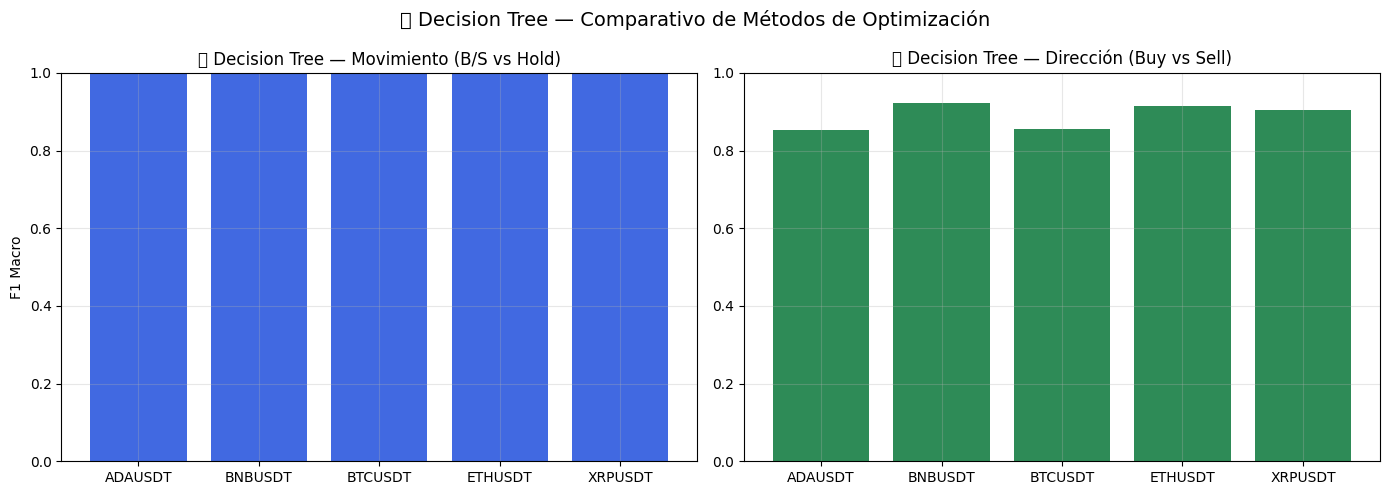

In [148]:
# ===============================================================
# 📊 VISUALIZACIÓN Y TABLA RESUMEN — DECISION TREE
# ===============================================================

import pandas as pd
import matplotlib.pyplot as plt

# --- Mejor método por dataset y tipo
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(
    lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]) if isinstance(x, dict) else "-"
)

# --- Tabla pivot consolidada
df_summary = df_best.pivot(
    index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"]
)
display(df_summary.style.set_caption("📋 RESUMEN FINAL — Decision Tree (MOV + DIR)"))

# --- Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mov_plot = df_best[df_best["Tipo"] == "Movimiento"]
axes[0].bar(mov_plot["Dataset"], mov_plot["F1_CV_Promedio"], color="royalblue")
axes[0].set_title("🌳 Decision Tree — Movimiento (B/S vs Hold)")
axes[0].set_ylabel("F1 Macro")
axes[0].set_ylim(0, 1)
axes[0].grid(alpha=0.3)

dir_plot = df_best[df_best["Tipo"] == "Dirección"]
axes[1].bar(dir_plot["Dataset"], dir_plot["F1_CV_Promedio"], color="seagreen")
axes[1].set_title("🌳 Decision Tree — Dirección (Buy vs Sell)")
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Decision Tree — Comparativo de Métodos de Optimización", fontsize=14)
plt.tight_layout()
plt.show()



🧠 VALIDACIÓN DE GENERALIZACIÓN Y DETECCIÓN DE OVERFITTING


🔍 Evaluando sobreajuste para ADAUSDT (Dirección) — GridSearch


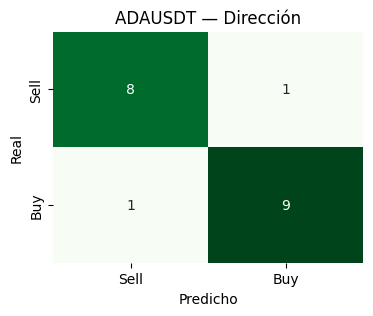


📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0     0.8889    0.8889    0.8889         9
         1.0     0.9000    0.9000    0.9000        10

    accuracy                         0.8947        19
   macro avg     0.8944    0.8944    0.8944        19
weighted avg     0.8947    0.8947    0.8947        19

🔹 F1_Train: 0.8903 | F1_Test: 0.8947 | ΔF1: -0.0044
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para ADAUSDT (Movimiento) — GridSearch


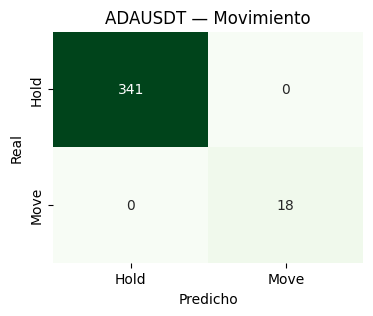


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       341
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BNBUSDT (Dirección) — GridSearch


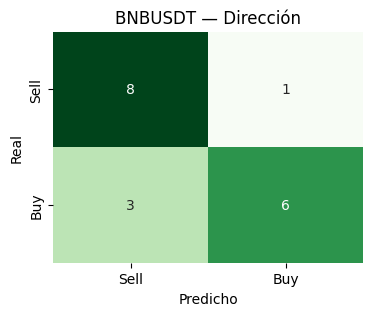


📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0     0.7273    0.8889    0.8000         9
         1.0     0.8571    0.6667    0.7500         9

    accuracy                         0.7778        18
   macro avg     0.7922    0.7778    0.7750        18
weighted avg     0.7922    0.7778    0.7750        18

🔹 F1_Train: 0.9857 | F1_Test: 0.7750 | ΔF1: 0.2107
⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BNBUSDT (Movimiento) — GridSearch


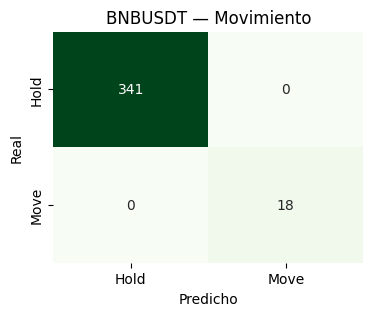


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       341
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BTCUSDT (Dirección) — Randomized


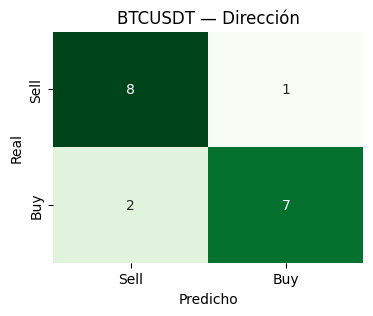


📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0     0.8000    0.8889    0.8421         9
         1.0     0.8750    0.7778    0.8235         9

    accuracy                         0.8333        18
   macro avg     0.8375    0.8333    0.8328        18
weighted avg     0.8375    0.8333    0.8328        18

🔹 F1_Train: 0.8970 | F1_Test: 0.8328 | ΔF1: 0.0642
⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para BTCUSDT (Movimiento) — GridSearch


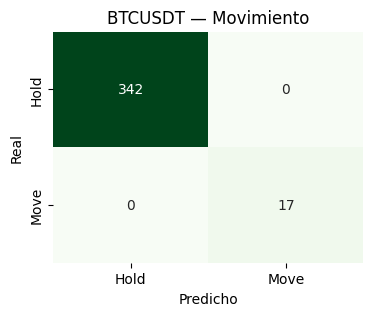


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       342
           1     1.0000    1.0000    1.0000        17

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para ETHUSDT (Dirección) — GridSearch


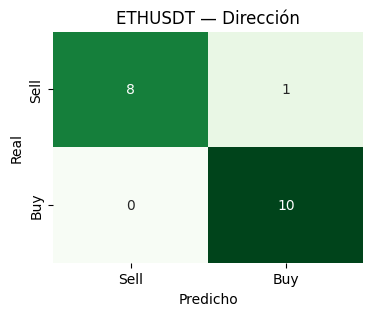


📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0     1.0000    0.8889    0.9412         9
         1.0     0.9091    1.0000    0.9524        10

    accuracy                         0.9474        19
   macro avg     0.9545    0.9444    0.9468        19
weighted avg     0.9522    0.9474    0.9471        19

🔹 F1_Train: 0.9467 | F1_Test: 0.9471 | ΔF1: -0.0004
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para ETHUSDT (Movimiento) — GridSearch


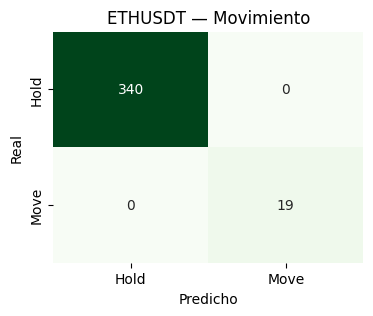


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       340
           1     1.0000    1.0000    1.0000        19

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para XRPUSDT (Dirección) — GridSearch


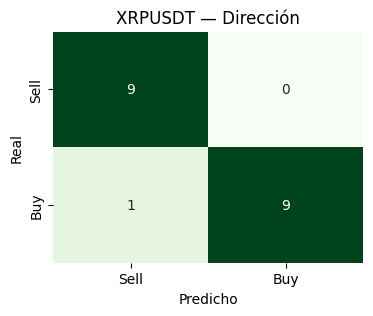


📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0     0.9000    1.0000    0.9474         9
         1.0     1.0000    0.9000    0.9474        10

    accuracy                         0.9474        19
   macro avg     0.9500    0.9500    0.9474        19
weighted avg     0.9526    0.9474    0.9474        19

🔹 F1_Train: 0.9733 | F1_Test: 0.9474 | ΔF1: 0.0260
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------

🔍 Evaluando sobreajuste para XRPUSDT (Movimiento) — GridSearch


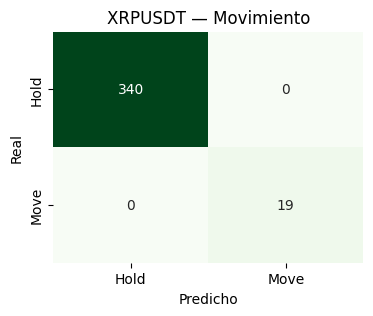


📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       340
           1     1.0000    1.0000    1.0000        19

    accuracy                         1.0000       359
   macro avg     1.0000    1.0000    1.0000       359
weighted avg     1.0000    1.0000    1.0000       359

🔹 F1_Train: 1.0000 | F1_Test: 1.0000 | ΔF1: 0.0000
✅ Generalización adecuada (sin indicios de sobreajuste).
--------------------------------------------------------------------------------


,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1,Precision_Test,Recall_Test
0,ADAUSDT,Dirección,GridSearch,0.8903,0.8947,-0.0044,0.8947,0.8947
1,ADAUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
2,BNBUSDT,Dirección,GridSearch,0.9857,0.7750,0.2107,0.7922,0.7778
3,BNBUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
4,BTCUSDT,Dirección,Randomized,0.8970,0.8328,0.0642,0.8375,0.8333
5,BTCUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
6,ETHUSDT,Dirección,GridSearch,0.9467,0.9471,-0.0004,0.9522,0.9474
7,ETHUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000
8,XRPUSDT,Dirección,GridSearch,0.9733,0.9474,0.0260,0.9526,0.9474
9,XRPUSDT,Movimiento,GridSearch,1.0000,1.0000,0.0000,1.0000,1.0000


In [149]:
# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN — DECISION TREE
# ===============================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

resumen_generalizacion = []

print("\n🧠 VALIDACIÓN DE GENERALIZACIÓN Y DETECCIÓN DE OVERFITTING")
print("==========================================================\n")

for _, fila in df_best.iterrows():
    dataset = fila["Dataset"]
    tipo = fila["Tipo"]
    metodo = fila["Metodo"]

    print(f"\n🔍 Evaluando sobreajuste para {dataset} ({tipo}) — {metodo}")
    df = datasets_raw[dataset].copy()

    # --- Reconstruir variable objetivo
    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
        y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
        y = df_dir["Label_Direction"]

    # --- División estratificada
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # --- Preprocesador y modelo
    preproc = crear_preprocesador(X_train)
    modelo = DecisionTreeClassifier(
        random_state=42,
        **{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items()}
    )

    pipe_final = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", modelo)
    ])

    pipe_final.fit(X_train, y_train)

    # --- Predicciones
    y_pred_train = pipe_final.predict(X_train)
    y_pred_test = pipe_final.predict(X_test)

    # --- Métricas
    f1_train = f1_score(y_train, y_pred_train, average="weighted")
    f1_test = f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test
    precision_test = precision_score(y_test, y_pred_test, average="weighted")
    recall_test = recall_score(y_test, y_pred_test, average="weighted")

    resumen_generalizacion.append({
        "Dataset": dataset,
        "Tipo": tipo,
        "Metodo": metodo,
        "F1_Train": round(f1_train, 4),
        "F1_Test": round(f1_test, 4),
        "Delta_F1": round(delta_f1, 4),
        "Precision_Test": round(precision_test, 4),
        "Recall_Test": round(recall_test, 4)
    })

    # --- Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    classes = ["Hold", "Move"] if tipo == "Movimiento" else ["Sell", "Buy"]

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=classes, yticklabels=classes, cbar=False)
    ax.set_title(f"{dataset} — {tipo}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    plt.show()

    # --- Reporte detallado
    print("\n📋 Reporte de clasificación:")
    print(classification_report(y_test, y_pred_test, digits=4))
    print(f"🔹 F1_Train: {f1_train:.4f} | F1_Test: {f1_test:.4f} | ΔF1: {delta_f1:.4f}")
    if delta_f1 > 0.05:
        print("⚠️ Posible sobreajuste detectado (modelo rinde mucho mejor en train que en test).")
    else:
        print("✅ Generalización adecuada (sin indicios de sobreajuste).")
    print("-" * 80)

# --- Consolidar resumen global
df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(
    df_generalizacion.style.background_gradient(
        subset=["Delta_F1"], cmap="RdYlGn_r", low=0, high=1
    ).format({
        "F1_Train": "{:.4f}",
        "F1_Test": "{:.4f}",
        "Delta_F1": "{:.4f}",
        "Precision_Test": "{:.4f}",
        "Recall_Test": "{:.4f}"
    }).set_caption("🔎 Evaluación Global de Overfitting — Decision Tree")
)


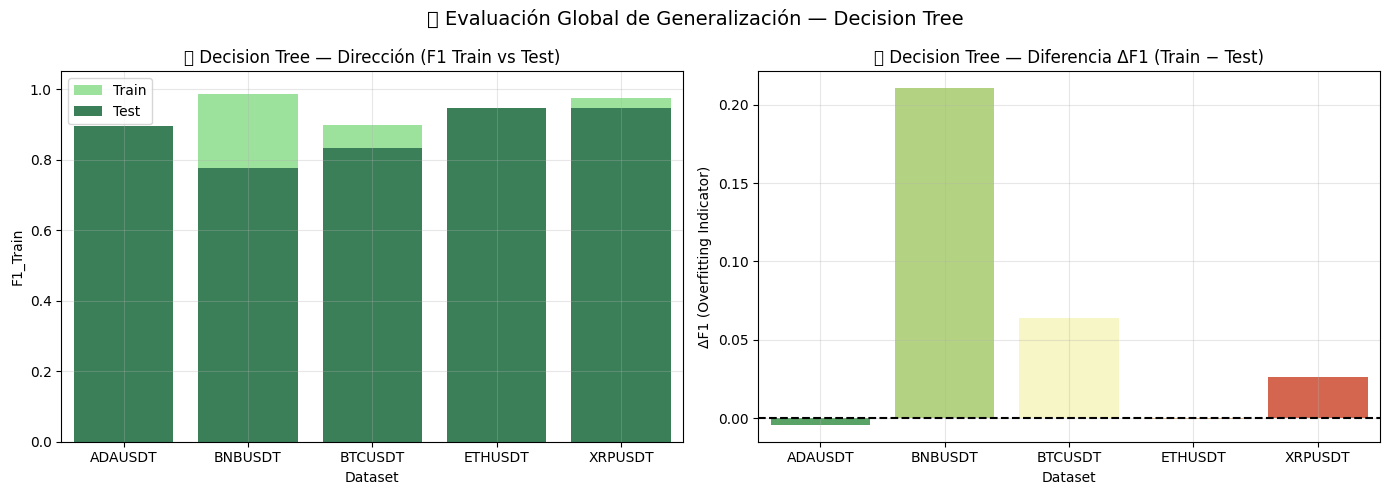

In [150]:
# ===============================================================
# 📊 VISUALIZACIÓN FINAL — COMPARATIVO F1 TRAIN vs TEST
# ===============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- F1 Train vs Test
sns.barplot(
    data=df_generalizacion[df_generalizacion["Tipo"] == "Dirección"],
    x="Dataset", y="F1_Train", color="lightgreen", label="Train", ax=axes[0]
)
sns.barplot(
    data=df_generalizacion[df_generalizacion["Tipo"] == "Dirección"],
    x="Dataset", y="F1_Test", color="seagreen", label="Test", ax=axes[0]
)
axes[0].set_title("🌳 Decision Tree — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- ΔF1 por dataset
sns.barplot(
    data=df_generalizacion[df_generalizacion["Tipo"] == "Dirección"],
    x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1]
)
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("🌳 Decision Tree — Diferencia ΔF1 (Train − Test)")
axes[1].set_ylabel("ΔF1 (Overfitting Indicator)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Evaluación Global de Generalización — Decision Tree", fontsize=14)
plt.tight_layout()
plt.show()


✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)


🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)



,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,GridSearch,0.986300,0.789500,0.196800
1,ADAUSDT,Movimiento,GridSearch,1.000000,0.994300,0.005700
2,BNBUSDT,Dirección,Randomized,0.971400,0.888900,0.082500
3,BNBUSDT,Movimiento,GridSearch,0.998600,0.988200,0.010400
4,BTCUSDT,Dirección,Halving,0.970600,0.828600,0.142000
5,BTCUSDT,Movimiento,GridSearch,0.998600,0.988100,0.010500
6,ETHUSDT,Dirección,GridSearch,1.000000,0.842100,0.157900
7,ETHUSDT,Movimiento,BayesSearch,1.000000,0.985100,0.014900
8,XRPUSDT,Dirección,GridSearch,1.000000,0.947400,0.052600
9,XRPUSDT,Movimiento,GridSearch,1.000000,0.988200,0.011800


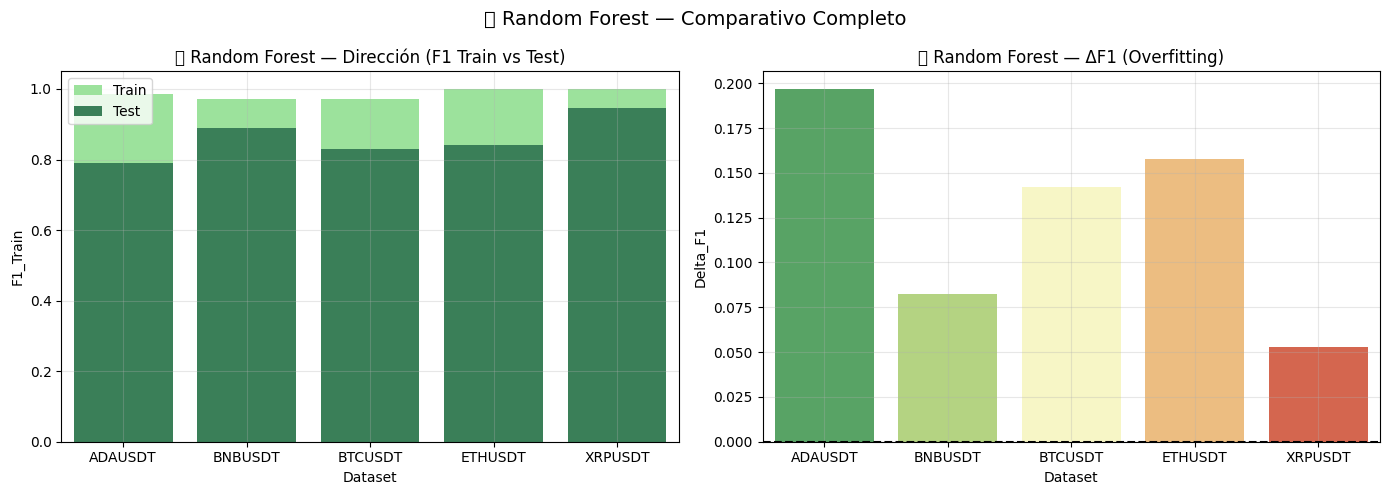

In [153]:
# ===============================================================
# 🌲 RANDOM FOREST — CADENA COMPLETA (MOV + DIR)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    f1_score, precision_score, recall_score, make_scorer
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)
num_cores = multiprocessing.cpu_count()
print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================

def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

def ejecutar_busquedas_rf(nombre, X, y, tipo, usar_smote=True):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para Random Forest."""
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    min_class = y.value_counts().min()
    skip_halving = min_class < 7

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)

    # --- Pipeline base
    if usar_smote:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("smote", SMOTE(k_neighbors=2, random_state=42)),
            ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
        ])
    else:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
        ])
    base_pipe_no_smote = base_pipe

    # --- Inicializar listas locales
    resultados, metricas_test = [], []

    # ==========================================================
    # Espacios de búsqueda corregidos
    # ==========================================================
    param_grid = {
        "model__n_estimators": [100, 200, 300],
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_depth": [3, 5, 7, 9, None],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2"]
    }

    param_dist = {
        "model__n_estimators": np.arange(100, 401, 50).tolist(),
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_depth": np.random.randint(3, 21, 20).astype(int).tolist() + [None],
        "model__min_samples_split": np.random.randint(2, 21, 10).astype(int).tolist(),
        "model__min_samples_leaf": np.random.randint(1, 11, 10).astype(int).tolist(),
        "model__max_features": ["sqrt", "log2"]
    }

    param_bayes = {
        "model__n_estimators": Integer(100, 400),
        "model__criterion": Categorical(["gini", "entropy", "log_loss"]),
        "model__max_depth": Integer(3, 20, transform="identity"),
        "model__min_samples_split": Integer(2, 20, transform="identity"),
        "model__min_samples_leaf": Integer(1, 10, transform="identity"),
        "model__max_features": Categorical(["sqrt", "log2"])
    }

    # ==========================================================
    # 1️⃣ GridSearchCV
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RandomizedSearchCV
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=40,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred_test = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HalvingRandomSearchCV (sin SMOTE para evitar errores de clases pequeñas)
    # ==========================================================
    if not skip_halving:
        base_pipe_halving = ImbPipeline([
            ("preprocessor", preproc),
            ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
        ])

        halv = HalvingRandomSearchCV(
            base_pipe_halving,
            param_distributions=param_dist,
            scoring=f1_weighted,
            cv=cv7,
            factor=3,
            n_jobs=-1
        )

        halv.fit(X_train, y_train)
        y_pred_test = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))
        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
        })
    else:
        resultados.append(("Halving", "-", np.nan))


    # ==========================================================
    # 4️⃣ BayesSearchCV
    bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=30,
                          scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
    bayes.fit(X_train, y_train)
    y_pred_test = bayes.best_estimator_.predict(X_test)
    resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
    metricas_test.append({
        "Metodo": "BayesSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # --- Consolidar
    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_rf(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_rf(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()
    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = RandomForestClassifier(random_state=42, class_weight="balanced",
                                    **{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items()})
    pipe = ImbPipeline([("preprocessor", preproc), ("smote", SMOTE(k_neighbors=2, random_state=42)), ("model", modelo)])
    pipe.fit(X_train, y_train)
    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train, f1_test = f1_score(y_train, y_pred_train, average="weighted"), f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test
    resumen_generalizacion.append({
        "Dataset": dataset, "Tipo": tipo, "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train,4), "F1_Test": round(f1_test,4), "Delta_F1": round(delta_f1,4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — Random Forest"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — Random Forest"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="lightgreen", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="seagreen", label="Test", ax=axes[0])
axes[0].set_title("🌲 Random Forest — Dirección (F1 Train vs Test)"); axes[0].set_ylim(0,1.05); axes[0].legend(); axes[0].grid(alpha=0.3)
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--"); axes[1].set_title("🌲 Random Forest — ΔF1 (Overfitting)"); axes[1].grid(alpha=0.3)
plt.suptitle("📈 Random Forest — Comparativo Completo", fontsize=14); plt.tight_layout(); plt.show()



## AdaBoosting

✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)


🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)



,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,GridSearch,1.000000,0.894700,0.105300
1,ADAUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
2,BNBUSDT,Dirección,GridSearch,1.000000,0.944300,0.055700
3,BNBUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
4,BTCUSDT,Dirección,GridSearch,0.941200,0.887500,0.053700
5,BTCUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
6,ETHUSDT,Dirección,GridSearch,0.946700,0.947100,-0.000400
7,ETHUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
8,XRPUSDT,Dirección,GridSearch,1.000000,0.894700,0.105300
9,XRPUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000


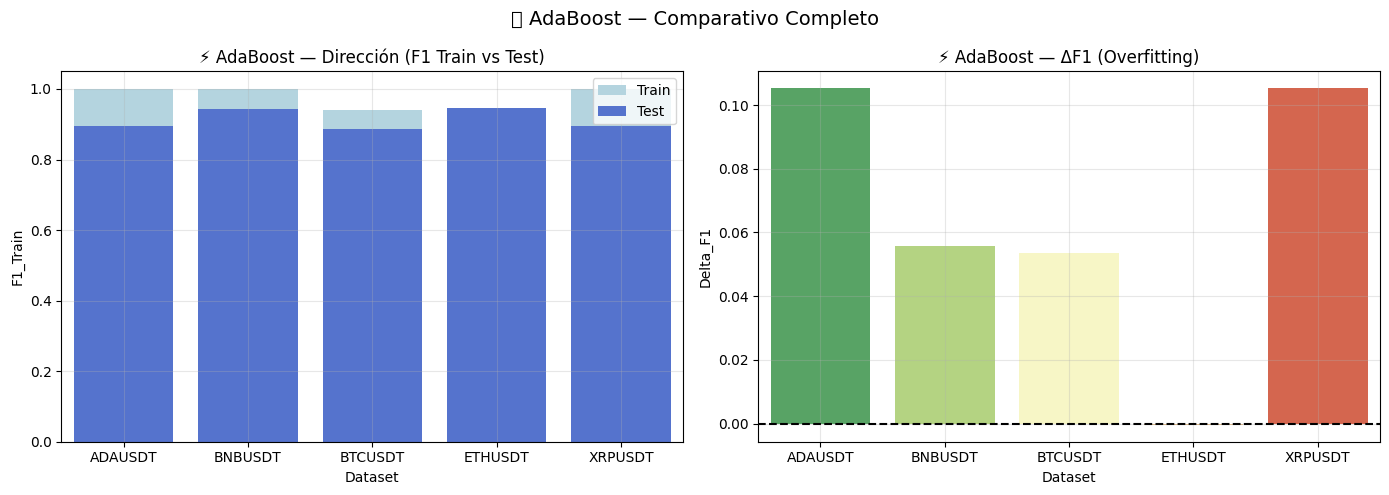

In [158]:
# ===============================================================
# ⚡ ADA BOOST — CADENA COMPLETA (MOV + DIR) — sklearn >= 1.6 FIX FINAL
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)
num_cores = multiprocessing.cpu_count()
print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================
def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

def ejecutar_busquedas_ada(nombre, X, y, tipo, usar_smote=True):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para AdaBoost."""
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    min_class = y.value_counts().min()
    skip_halving = min_class < 7

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)

    # --- Base Learner
    base_estimator = DecisionTreeClassifier(random_state=42, max_depth=3)

    # --- Pipeline
    if usar_smote:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("smote", SMOTE(k_neighbors=2, random_state=42)),
            ("model", AdaBoostClassifier(estimator=base_estimator, random_state=42, algorithm="SAMME"))
        ])
    else:
        base_pipe = ImbPipeline([
            ("preprocessor", preproc),
            ("model", AdaBoostClassifier(estimator=base_estimator, random_state=42, algorithm="SAMME"))
        ])

    resultados, metricas_test = [], []

    # ==========================================================
    # Espacios de búsqueda
    # ==========================================================
    param_grid = {
        "model__n_estimators": [50, 100, 200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
        "model__estimator__max_depth": [1, 2, 3, 4]
    }
    param_dist = {
        "model__n_estimators": np.arange(50, 401, 50).tolist(),
        "model__learning_rate": np.linspace(0.01, 1.0, 10).tolist(),
        "model__estimator__max_depth": np.random.randint(1, 6, 10).tolist()
    }
    param_bayes = {
        "model__n_estimators": Integer(50, 400),
        "model__learning_rate": Real(0.01, 1.0, prior="log-uniform"),
        "model__estimator__max_depth": Integer(1, 6)
    }

    # ==========================================================
    # 1️⃣ GridSearchCV
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RandomizedSearchCV
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=40,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred_test = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HalvingRandomSearchCV (sin SMOTE)
    if not skip_halving:
        base_pipe_halving = ImbPipeline([
            ("preprocessor", preproc),
            ("model", AdaBoostClassifier(estimator=base_estimator, random_state=42, algorithm="SAMME"))
        ])
        halv = HalvingRandomSearchCV(base_pipe_halving, param_distributions=param_dist,
                                     scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1)
        halv.fit(X_train, y_train)
        y_pred_test = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))
        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
        })
    else:
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BayesSearchCV
    bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=30,
                          scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
    bayes.fit(X_train, y_train)
    y_pred_test = bayes.best_estimator_.predict(X_test)
    resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
    metricas_test.append({
        "Metodo": "BayesSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_ada(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_ada(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN (corregida)
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
        y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
        y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)

    # separar parámetros correctamente
    params = fila["Mejores Parámetros"]
    params_ada = {k.replace("model__", ""): v for k, v in params.items() if "estimator__" not in k}
    params_tree = {k.replace("model__estimator__", ""): v for k, v in params.items() if "estimator__" in k}

    base_tree = DecisionTreeClassifier(random_state=42, **params_tree)
    modelo = AdaBoostClassifier(estimator=base_tree, random_state=42, algorithm="SAMME", **params_ada)

    pipe = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", modelo)
    ])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train, average="weighted")
    f1_test = f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset,
        "Tipo": tipo,
        "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4),
        "F1_Test": round(f1_test, 4),
        "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — AdaBoost"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — AdaBoost"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="lightblue", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="royalblue", label="Test", ax=axes[0])
axes[0].set_title("⚡ AdaBoost — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("⚡ AdaBoost — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 AdaBoost — Comparativo Completo", fontsize=14)
plt.tight_layout()
plt.show()


## Gradient Boosting

✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

⚠️ BTCUSDT (Movimiento) - Halving falló: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.
⚠️ ETHUSDT (Movimiento) - Halving falló: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.
⚠️ ADAUSDT (Movimiento) - Halving falló: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.
⚠️ XRPUSDT (Movimiento) - Halving falló: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.
⚠️ BNBUSDT (Movimiento) - Halving falló: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)



,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,GridSearch,0.986300,0.894200,0.092100
1,ADAUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
2,BNBUSDT,Dirección,GridSearch,1.000000,1.000000,0.000000
3,BNBUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
4,BTCUSDT,Dirección,GridSearch,1.000000,0.775000,0.225000
5,BTCUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
6,ETHUSDT,Dirección,GridSearch,0.933300,1.000000,-0.066700
7,ETHUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
8,XRPUSDT,Dirección,Randomized,1.000000,0.894700,0.105300
9,XRPUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000


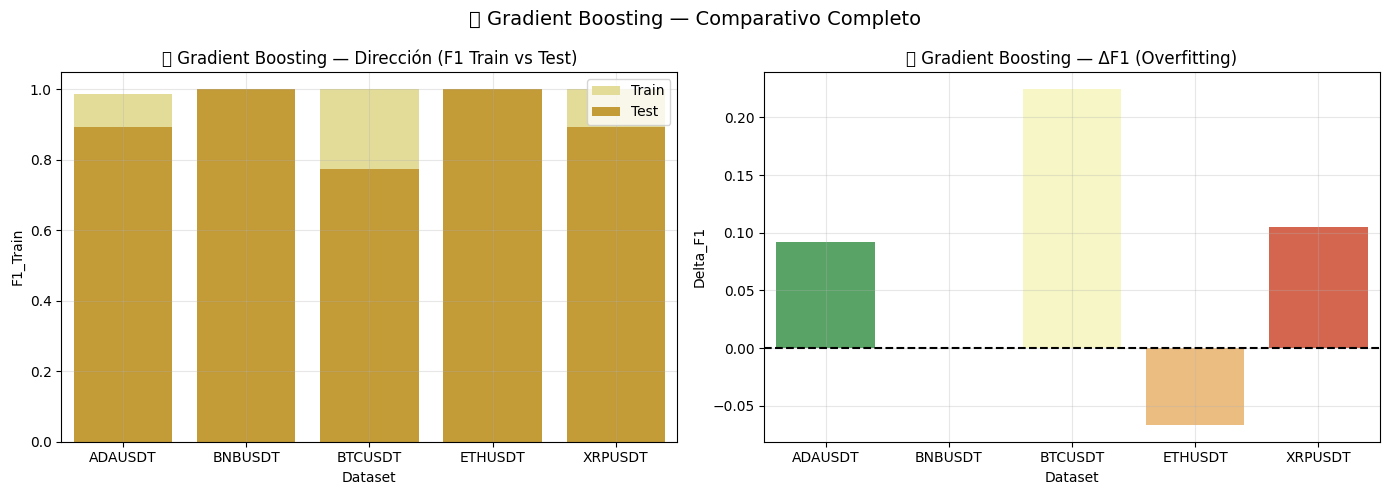

In [160]:
# ===============================================================
# 🌄 GRADIENT BOOSTING — CADENA COMPLETA (MOV + DIR)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)
num_cores = multiprocessing.cpu_count()
print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================
def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

def ejecutar_busquedas_gb(nombre, X, y, tipo, usar_smote=True):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para Gradient Boosting."""
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    min_class = y.value_counts().min()
    skip_halving = min_class < 7

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)

    # --- Pipeline base
    base_pipe = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", GradientBoostingClassifier(random_state=42))
    ])
    base_pipe_no_smote = ImbPipeline([
        ("preprocessor", preproc),
        ("model", GradientBoostingClassifier(random_state=42))
    ])

    resultados, metricas_test = [], []

    # ==========================================================
    # Espacios de búsqueda
    # ==========================================================
    param_grid = {
        "model__n_estimators": [50, 100, 200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__max_depth": [1, 2, 3, 4],
        "model__subsample": [0.8, 1.0],
        "model__criterion": ["friedman_mse", "squared_error"]
    }
    param_dist = {
        "model__n_estimators": np.arange(50, 401, 50).tolist(),
        "model__learning_rate": np.linspace(0.01, 0.3, 10).tolist(),
        "model__max_depth": np.random.randint(1, 6, 10).tolist(),
        "model__subsample": np.linspace(0.7, 1.0, 4).tolist(),
        "model__criterion": ["friedman_mse", "squared_error"]
    }
    param_bayes = {
        "model__n_estimators": Integer(50, 400),
        "model__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "model__max_depth": Integer(1, 5),
        "model__subsample": Real(0.7, 1.0),
        "model__criterion": Categorical(["friedman_mse", "squared_error"])
    }

    # ==========================================================
    # 1️⃣ GridSearchCV (con SMOTE)
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RandomizedSearchCV (con SMOTE)
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=40,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred_test = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HalvingRandomSearchCV (sin SMOTE)
    if not skip_halving:
        halv = HalvingRandomSearchCV(base_pipe_no_smote, param_distributions=param_dist,
                                     scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1,
                                     error_score="raise")
        try:
            halv.fit(X_train, y_train)
            y_pred_test = halv.best_estimator_.predict(X_test)
            resultados.append(("Halving", halv.best_params_, halv.best_score_))
            metricas_test.append({
                "Metodo": "Halving",
                "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
                "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
                "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
            })
        except ValueError as e:
            print(f"⚠️ {nombre} ({tipo}) - Halving falló: {e}")
            resultados.append(("Halving", "-", np.nan))
    else:
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BayesSearchCV (sin SMOTE)
    try:
        bayes = BayesSearchCV(base_pipe_no_smote, search_spaces=param_bayes, n_iter=30,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
        bayes.fit(X_train, y_train)
        y_pred_test = bayes.best_estimator_.predict(X_test)
        resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
        metricas_test.append({
            "Metodo": "BayesSearch",
            "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
        })
    except ValueError as e:
        print(f"⚠️ {nombre} ({tipo}) - BayesSearch falló: {e}")
        resultados.append(("BayesSearch", "-", np.nan))

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")


# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_gb(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_gb(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
        y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
        y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = GradientBoostingClassifier(random_state=42, **{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items()})

    pipe = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", modelo)
    ])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train, average="weighted")
    f1_test = f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset,
        "Tipo": tipo,
        "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4),
        "F1_Test": round(f1_test, 4),
        "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — Gradient Boosting"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — Gradient Boosting"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="khaki", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="goldenrod", label="Test", ax=axes[0])
axes[0].set_title("🌄 Gradient Boosting — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("🌄 Gradient Boosting — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Gradient Boosting — Comparativo Completo", fontsize=14)
plt.tight_layout()
plt.show()


## XgBoosting

✅ Paralelización activa con 56 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)


🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)



,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,GridSearch,1.000000,0.947100,0.052900
1,ADAUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
2,BNBUSDT,Dirección,GridSearch,0.985700,0.944300,0.041400
3,BNBUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
4,BTCUSDT,Dirección,GridSearch,1.000000,0.944300,0.055700
5,BTCUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
6,ETHUSDT,Dirección,GridSearch,0.960000,0.947100,0.012900
7,ETHUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000
8,XRPUSDT,Dirección,GridSearch,1.000000,0.947100,0.052900
9,XRPUSDT,Movimiento,GridSearch,1.000000,1.000000,0.000000


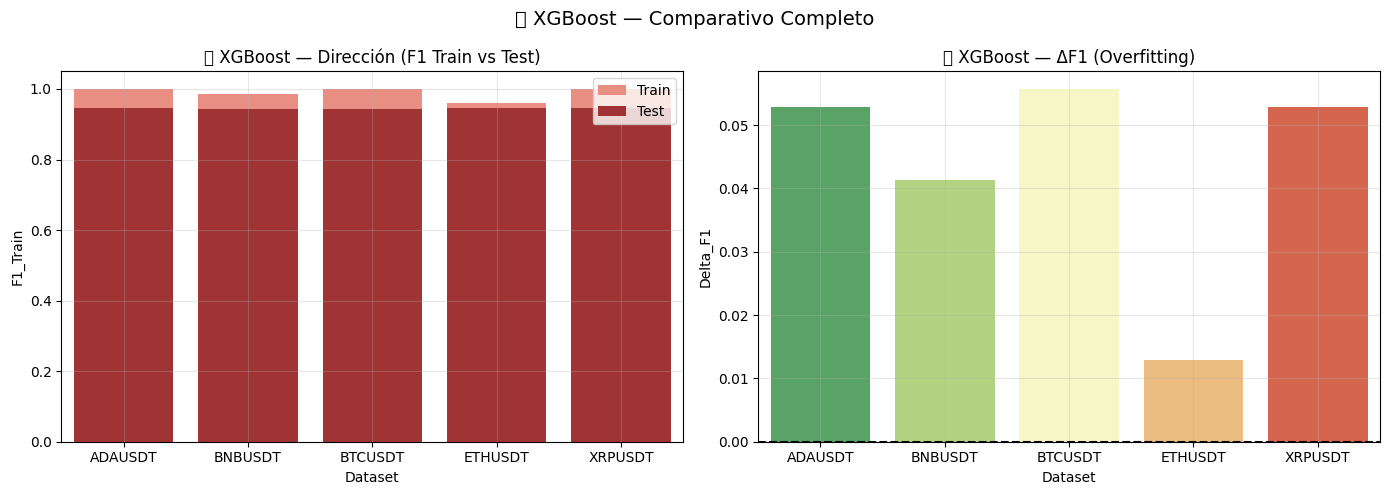

In [162]:
# ===============================================================
# 💥 XGBOOST — CADENA COMPLETA (MOV + DIR)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)
num_cores = multiprocessing.cpu_count()
print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================
def crear_preprocesador(df):
    vars_num = list(df.select_dtypes(include=np.number).columns)
    vars_cat = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), vars_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), vars_cat)
    ])

def ejecutar_busquedas_xgb(nombre, X, y, tipo, usar_smote=True):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para XGBoost."""
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    min_class = y.value_counts().min()
    skip_halving = min_class < 7

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)

    # --- Pipeline base
    base_pipe = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        ))
    ])
    base_pipe_no_smote = ImbPipeline([
        ("preprocessor", preproc),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        ))
    ])

    resultados, metricas_test = [], []

    # ==========================================================
    # Espacios de búsqueda
    # ==========================================================
    param_grid = {
        "model__n_estimators": [100, 200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3, 4, 5],
        "model__subsample": [0.7, 0.8, 1.0],
        "model__colsample_bytree": [0.7, 0.8, 1.0],
        "model__gamma": [0, 0.1, 0.5],
        "model__reg_lambda": [0.5, 1.0, 2.0]
    }
    param_dist = {
        "model__n_estimators": np.arange(100, 501, 50),
        "model__learning_rate": np.linspace(0.01, 0.2, 10),
        "model__max_depth": np.arange(2, 8),
        "model__subsample": np.linspace(0.7, 1.0, 4),
        "model__colsample_bytree": np.linspace(0.7, 1.0, 4),
        "model__gamma": np.linspace(0, 0.5, 5),
        "model__reg_lambda": np.linspace(0.5, 2.0, 4)
    }
    param_bayes = {
        "model__n_estimators": Integer(100, 500),
        "model__learning_rate": Real(0.01, 0.2, prior="log-uniform"),
        "model__max_depth": Integer(2, 7),
        "model__subsample": Real(0.7, 1.0),
        "model__colsample_bytree": Real(0.7, 1.0),
        "model__gamma": Real(0, 0.5),
        "model__reg_lambda": Real(0.5, 2.0)
    }

    # ==========================================================
    # 1️⃣ GridSearchCV (con SMOTE)
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RandomizedSearchCV (con SMOTE)
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=40,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred_test = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HalvingRandomSearchCV (sin SMOTE)
    if not skip_halving:
        try:
            halv = HalvingRandomSearchCV(base_pipe_no_smote, param_distributions=param_dist,
                                         scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1)
            halv.fit(X_train, y_train)
            y_pred_test = halv.best_estimator_.predict(X_test)
            resultados.append(("Halving", halv.best_params_, halv.best_score_))
            metricas_test.append({
                "Metodo": "Halving",
                "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
                "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
                "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
            })
        except Exception as e:
            print(f"⚠️ {nombre} ({tipo}) - Halving falló: {e}")
            resultados.append(("Halving", "-", np.nan))
    else:
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BayesSearchCV (sin SMOTE)
    try:
        bayes = BayesSearchCV(base_pipe_no_smote, search_spaces=param_bayes, n_iter=30,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
        bayes.fit(X_train, y_train)
        y_pred_test = bayes.best_estimator_.predict(X_test)
        resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
        metricas_test.append({
            "Metodo": "BayesSearch",
            "F1_Test": f1_score(y_test, y_pred_test, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred_test, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred_test, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - BayesSearch falló: {e}")
        resultados.append(("BayesSearch", "-", np.nan))

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_xgb(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_xgb(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        **{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items() if not isinstance(v, str) or v != "-"}
    )

    pipe = ImbPipeline([
        ("preprocessor", preproc),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("model", modelo)
    ])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train, average="weighted")
    f1_test = f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset,
        "Tipo": tipo,
        "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4),
        "F1_Test": round(f1_test, 4),
        "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — XGBoost"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — XGBoost"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="salmon", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="firebrick", label="Test", ax=axes[0])
axes[0].set_title("💥 XGBoost — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("💥 XGBoost — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 XGBoost — Comparativo Completo", fontsize=14)
plt.tight_layout()
plt.show()


## Discriminante Lineal

In [44]:
# ===============================================================
# ⚡ LINEAR DISCRIMINANT ANALYSIS — OPTIMIZACIÓN + VALIDACIÓN GLOBAL (ROBUSTO)
# ===============================================================

import pandas as pd, numpy as np, warnings, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV, train_test_split, ParameterGrid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from collections import defaultdict

warnings.filterwarnings("ignore")

# ===============================================================
# 🧩 PREPROCESADOR
# ===============================================================
def crear_preprocesador(df):
    num_vars = list(df.select_dtypes(include=np.number).columns)
    cat_vars = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ])

# ===============================================================
# 🔧 CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ==========================================================
# 🧠 FUNCIÓN FINAL — LDA OPTIMIZACIÓN COMPLETA (ROBUSTA Y SEGURA)
# ==========================================================
def ejecutar_busquedas_lda(nombre, X, y, tipo):
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase en {tipo}. Omitido.")
        return pd.DataFrame()

    # División entrenamiento / prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y
    )

    preproc = crear_preprocesador(X_train)
    base_pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", LinearDiscriminantAnalysis())
    ])

    # ==========================================================
    # 1️⃣ Espacio de hiperparámetros base seguro
    # ==========================================================
    param_grid = {
        "model__solver": ["svd", "lsqr", "eigen"],
        "model__shrinkage": [None, "auto", 0.1, 0.5, 1.0],
        "model__priors": [None, (0.5, 0.5)],
        "model__tol": [1e-4, 1e-3, 1e-2],
        "model__n_components": [None, 1],
        "model__store_covariance": [False, True]
    }

    n_classes = len(np.unique(y_train))
    n_features = X_train.shape[1]
    max_components = min(n_features, n_classes - 1)
    muestras_por_clase = len(y_train) / n_classes

    # ==========================================================
    # 2️⃣ Filtro matemático de combinaciones válidas
    # ==========================================================
    def is_valid_combo(params):
        solver, shrinkage = params.get("model__solver"), params.get("model__shrinkage")
        nc = params.get("model__n_components")

        # 'svd' no usa shrinkage
        if solver == "svd" and shrinkage not in [None, "auto"]:
            return False
        # 'eigen' y 'lsqr' requieren shrinkage válido
        if solver in ["eigen", "lsqr"] and (shrinkage is None or shrinkage == "auto"):
            return False
        # Evitar overfit si hay más features que muestras por clase
        if solver != "svd" and muestras_por_clase < n_features:
            return False
        # n_components debe ser ≤ max_components
        if isinstance(nc, (int, float)) and nc > max_components:
            return False
        return True

    valid_grid = [p for p in ParameterGrid(param_grid) if is_valid_combo(p)]
    grid_dict = defaultdict(list)
    for d in valid_grid:
        for k, v in d.items():
            if v not in grid_dict[k]:
                grid_dict[k].append(v)

    print(f"🔍 {nombre} ({tipo}) — combinaciones válidas: {len(valid_grid)} (máx comp={max_components})")

    resultados, metricas_test = [], []

    # ==========================================================
    # 3️⃣ Función auxiliar segura para ejecutar búsquedas
    # ==========================================================
    def safe_fit(search_name, search_obj):
        try:
            search_obj.fit(X_train, y_train)
            best_params = search_obj.best_params_
            y_pred = search_obj.best_estimator_.predict(X_test)
            resultados.append((search_name, best_params, search_obj.best_score_))
            metricas_test.append({
                "Metodo": search_name,
                "F1_Test": f1_score(y_test, y_pred, average="weighted"),
                "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
                "Recall_Test": recall_score(y_test, y_pred, average="weighted")
            })
        except np.linalg.LinAlgError:
            print(f"⚠️ {nombre} ({tipo}) — {search_name} falló por matriz no definida positiva. Reintentando con 'svd'.")
            try:
                fallback = Pipeline([
                    ("preprocessor", preproc),
                    ("model", LinearDiscriminantAnalysis(solver="svd"))
                ])
                fallback.fit(X_train, y_train)
                y_pred = fallback.predict(X_test)
                resultados.append((f"{search_name}_fallback_svd", {"model__solver": "svd"}, np.nan))
                metricas_test.append({
                    "Metodo": f"{search_name}_fallback_svd",
                    "F1_Test": f1_score(y_test, y_pred, average="weighted"),
                    "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
                    "Recall_Test": recall_score(y_test, y_pred, average="weighted")
                })
            except Exception as e:
                print(f"❌ {nombre} ({tipo}) — Error persistente en {search_name}: {e}")

    # ==========================================================
    # 4️⃣ Ejecución de búsquedas seguras
    # ==========================================================
    grid = GridSearchCV(base_pipe, dict(grid_dict), scoring=f1_weighted, cv=cv7, n_jobs=-1)
    safe_fit("GridSearch", grid)

    rand = RandomizedSearchCV(base_pipe, grid_dict, n_iter=40, scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
    safe_fit("Randomized", rand)

    halv = HalvingRandomSearchCV(base_pipe, grid_dict, scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1, random_state=42)
    safe_fit("Halving", halv)

    param_bayes = {
        "model__solver": Categorical(["lsqr", "eigen"]),
        "model__shrinkage": Real(0.1, 1.0, prior="uniform"),
        "model__tol": Real(1e-4, 1e-2, prior="log-uniform"),
        "model__n_components": Categorical([1]),
        "model__store_covariance": Categorical([False, True])
    }
    bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=20, scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
    safe_fit("BayesSearch", bayes)

    # ==========================================================
    # 📊 Consolidación de resultados
    # ==========================================================
    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"], df["Tipo"] = nombre, tipo
    df_metrics = pd.DataFrame(metricas_test)
    df_metrics["Dataset"], df_metrics["Tipo"] = nombre, tipo
    return df.merge(df_metrics, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🧩 BLOQUE PRINCIPAL DE ENTRENAMIENTO
# ===============================================================
resultados_total = []

for nombre, df in datasets_raw.items():
    print(f"\n🚀 {nombre} — Movimiento")
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    resultados_total.append(ejecutar_busquedas_lda(nombre, X, y, "Movimiento"))

    print(f"\n🚀 {nombre} — Dirección")
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]
    resultados_total.append(ejecutar_busquedas_lda(nombre, X, y, "Dirección"))

df_best = pd.concat(resultados_total, ignore_index=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = LinearDiscriminantAnalysis(**{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items() if k.startswith("model__")})

    pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", modelo)
    ])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train, f1_test = f1_score(y_train, y_pred_train, average="weighted"), f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset, "Tipo": tipo, "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4), "F1_Test": round(f1_test, 4),
        "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — LDA"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — LDA"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="lightcoral", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="firebrick", label="Test", ax=axes[0])
axes[0].set_title("💥 LDA — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05); axes[0].legend(); axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("💥 LDA — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Linear Discriminant Analysis — Comparativo Completo", fontsize=14)
plt.tight_layout(); plt.show()



🚀 BTCUSDT — Movimiento
🔍 BTCUSDT (Movimiento) — combinaciones válidas: 192 (máx comp=1)

🚀 BTCUSDT — Dirección
🔍 BTCUSDT (Dirección) — combinaciones válidas: 48 (máx comp=1)

🚀 ETHUSDT — Movimiento
🔍 ETHUSDT (Movimiento) — combinaciones válidas: 192 (máx comp=1)

🚀 ETHUSDT — Dirección
🔍 ETHUSDT (Dirección) — combinaciones válidas: 48 (máx comp=1)

🚀 ADAUSDT — Movimiento
🔍 ADAUSDT (Movimiento) — combinaciones válidas: 192 (máx comp=1)

🚀 ADAUSDT — Dirección
🔍 ADAUSDT (Dirección) — combinaciones válidas: 48 (máx comp=1)

🚀 XRPUSDT — Movimiento
🔍 XRPUSDT (Movimiento) — combinaciones válidas: 192 (máx comp=1)

🚀 XRPUSDT — Dirección
🔍 XRPUSDT (Dirección) — combinaciones válidas: 48 (máx comp=1)

🚀 BNBUSDT — Movimiento
🔍 BNBUSDT (Movimiento) — combinaciones válidas: 192 (máx comp=1)

🚀 BNBUSDT — Dirección
🔍 BNBUSDT (Dirección) — combinaciones válidas: 48 (máx comp=1)


,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,BTCUSDT,Movimiento,GridSearch,0.935600,0.925300,0.010300
1,BTCUSDT,Movimiento,Randomized,0.934100,0.931200,0.002900
2,BTCUSDT,Movimiento,Halving,0.929200,0.925300,0.003900
3,BTCUSDT,Movimiento,BayesSearch,0.929900,0.928100,0.001800
4,BTCUSDT,Dirección,GridSearch,1.000000,0.609900,0.390100
5,BTCUSDT,Dirección,Randomized,1.000000,0.387000,0.613000
6,BTCUSDT,Dirección,Halving,1.000000,0.600000,0.400000
7,BTCUSDT,Dirección,BayesSearch,0.881900,0.828600,0.053400
8,ETHUSDT,Movimiento,GridSearch,0.924200,0.918500,0.005700
9,ETHUSDT,Movimiento,Randomized,0.923800,0.930400,-0.006600


ValueError: Index contains duplicate entries, cannot reshape

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

⚠️ BTCUSDT (Movimiento) - BayesSearch falló: The leading minor of order 10 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.
⚠️ ETHUSDT (Movimiento) - BayesSearch falló: The leading minor of order 10 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.
⚠️ ADAUSDT (Movimiento) - BayesSearch falló: The leading minor of order 10 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)

⚠️ XRPUSDT (Dirección) - BayesSearch falló: The leading minor of order 10 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.


,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,GridSearch,0.931500,0.894700,0.036800
1,ADAUSDT,Movimiento,GridSearch,0.931000,0.925500,0.005500
2,BNBUSDT,Dirección,BayesSearch,0.971400,0.944300,0.027200
3,BNBUSDT,Movimiento,Halving,0.930500,0.925400,0.005000
4,BTCUSDT,Dirección,Halving,0.333300,0.662500,-0.329200
5,BTCUSDT,Movimiento,GridSearch,0.936100,0.921100,0.014900
6,ETHUSDT,Dirección,GridSearch,0.986700,0.894200,0.092500
7,ETHUSDT,Movimiento,Halving,0.923400,0.919900,0.003500
8,XRPUSDT,Dirección,GridSearch,0.973300,0.842100,0.131200
9,XRPUSDT,Movimiento,GridSearch,0.936000,0.918300,0.017700


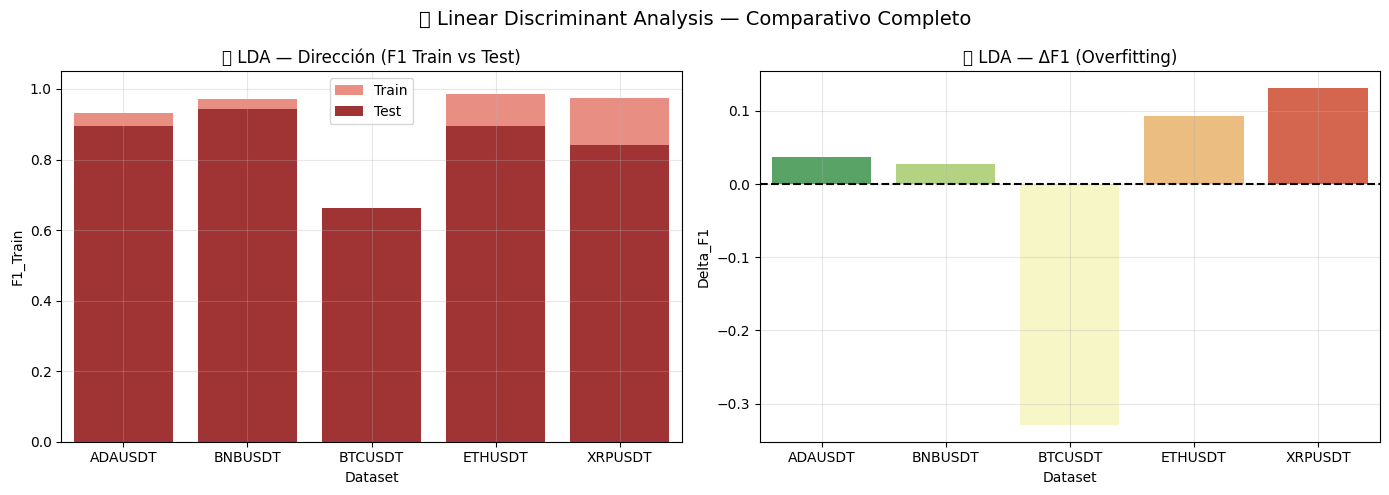

In [45]:
# ===============================================================
# 💥 LDA — CADENA COMPLETA (MOV + DIR)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV, train_test_split
)
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import defaultdict

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================
def crear_preprocesador(df):
    num_vars = list(df.select_dtypes(include=np.number).columns)
    cat_vars = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ])

def ejecutar_busquedas_lda(nombre, X, y, tipo):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para LDA."""
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)
    base_pipe = Pipeline([("preprocessor", preproc), ("model", LinearDiscriminantAnalysis())])

    # --- Espacio de búsqueda base ---
    param_grid = {
        "model__solver": ["svd", "lsqr", "eigen"],
        "model__shrinkage": [None, "auto", 0.1, 0.5, 1.0],
        "model__priors": [None, (0.5, 0.5)],
        "model__tol": [1e-4, 1e-3, 1e-2],
        "model__n_components": [None, 1, 2],
        "model__store_covariance": [False, True]
    }

    # --- Validación de combinaciones válidas ---
    n_classes = len(np.unique(y_train))
    n_features = X_train.shape[1]
    max_components = min(n_features, n_classes - 1)

    def is_valid_combo(params):
        solver, shrinkage = params.get("model__solver"), params.get("model__shrinkage")
        nc = params.get("model__n_components")
        if solver == "svd" and shrinkage not in [None, "auto"]:
            return False
        if solver in ["eigen", "lsqr"] and shrinkage is None:
            return False
        if isinstance(nc, (int, float)) and nc > max_components:
            return False
        if n_classes == 2 and isinstance(nc, (int, float)) and nc != 1:
            return False
        return True

    valid_grid = [p for p in list(__import__('sklearn.model_selection').model_selection.ParameterGrid(param_grid)) if is_valid_combo(p)]
    grid_dict = defaultdict(list)
    for d in valid_grid:
        for k, v in d.items():
            if v not in grid_dict[k]:
                grid_dict[k].append(v)

    resultados, metricas_test = [], []

    # ==========================================================
    # 1️⃣ GRID SEARCH
    grid = GridSearchCV(base_pipe, param_grid=dict(grid_dict), scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RANDOM SEARCH
    rand = RandomizedSearchCV(base_pipe, param_distributions=grid_dict, n_iter=40, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HALVING RANDOM SEARCH
    halv = HalvingRandomSearchCV(base_pipe, param_distributions=grid_dict, scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1)
    try:
        halv.fit(X_train, y_train)
        y_pred = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))
        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - Halving falló: {e}")
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BAYES SEARCH
    param_bayes = {
        "model__solver": Categorical(["lsqr", "eigen"]),
        "model__shrinkage": Real(0.0, 1.0, prior="uniform"),
        "model__tol": Real(1e-4, 1e-2, prior="log-uniform"),
        "model__n_components": Categorical([1]),
        "model__store_covariance": Categorical([False, True])
    }
    try:
        bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=20, scoring=f1_weighted, cv=cv7, n_jobs=-1)
        bayes.fit(X_train, y_train)
        y_pred = bayes.best_estimator_.predict(X_test)
        resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
        metricas_test.append({
            "Metodo": "BayesSearch",
            "F1_Test": f1_score(y_test, y_pred, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - BayesSearch falló: {e}")
        resultados.append(("BayesSearch", "-", np.nan))

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_lda(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_lda(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = LinearDiscriminantAnalysis(**{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items() if not isinstance(v, str) or v != "-"})

    pipe = Pipeline([("preprocessor", preproc), ("model", modelo)])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train, f1_test = f1_score(y_train, y_pred_train, average="weighted"), f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset, "Tipo": tipo, "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4), "F1_Test": round(f1_test, 4), "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — LDA"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — LDA"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="salmon", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="firebrick", label="Test", ax=axes[0])
axes[0].set_title("💥 LDA — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("💥 LDA — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Linear Discriminant Analysis — Comparativo Completo", fontsize=14)
plt.tight_layout()
plt.show()


# Quadratic Discriminant Analysis

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

⚠️ BNBUSDT (Movimiento) - Halving falló: 
All the 399 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
285 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\vaguirre\AppData\Roaming\Python\Python313\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit

,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,BayesSearch,1.000000,0.841200,0.158800
1,ADAUSDT,Movimiento,Halving,0.925100,0.925400,-0.000300
2,BNBUSDT,Dirección,Randomized,0.957100,0.888900,0.068200
3,BNBUSDT,Movimiento,GridSearch,0.932500,0.925400,0.007100
4,BTCUSDT,Dirección,Randomized,0.955800,0.721400,0.234400
5,BTCUSDT,Movimiento,GridSearch,0.931900,0.929500,0.002300
6,ETHUSDT,Dirección,Randomized,0.960000,0.947100,0.012900
7,ETHUSDT,Movimiento,GridSearch,0.922400,0.921300,0.001000
8,XRPUSDT,Dirección,GridSearch,0.960000,0.947100,0.012900
9,XRPUSDT,Movimiento,Halving,0.927400,0.921300,0.006000


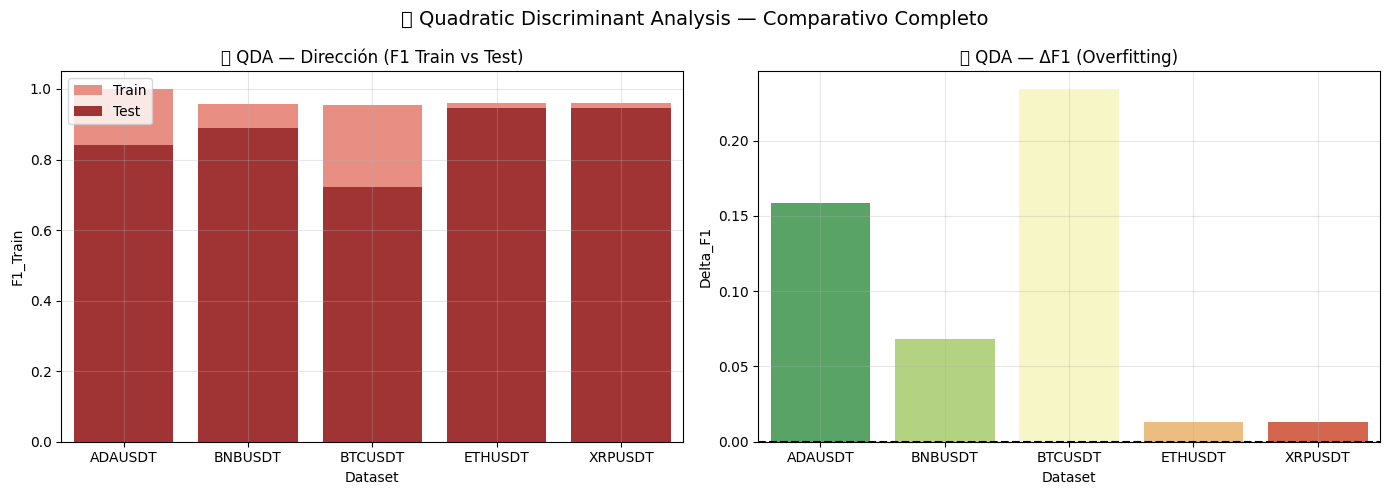

In [46]:
# ===============================================================
# 💥 QDA — CADENA COMPLETA (MOV + DIR)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV, train_test_split
)
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from collections import defaultdict

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================
def crear_preprocesador(df):
    num_vars = list(df.select_dtypes(include=np.number).columns)
    cat_vars = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ])

def ejecutar_busquedas_qda(nombre, X, y, tipo):
    """Ejecuta las 4 estrategias de optimización (Grid, Random, Halving, Bayes) para QDA."""
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)
    base_pipe = Pipeline([("preprocessor", preproc), ("model", QuadraticDiscriminantAnalysis())])

    # ==========================================================
    # Espacio de búsqueda
    # ==========================================================
    param_grid = {
        "model__reg_param": [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
        "model__tol": [1e-4, 1e-3, 1e-2],
        "model__store_covariance": [False, True]
    }
    param_dist = {
        "model__reg_param": np.linspace(0, 0.5, 10),
        "model__tol": np.logspace(-4, -2, 5),
        "model__store_covariance": [False, True]
    }
    param_bayes = {
        "model__reg_param": Real(0.0, 0.5, prior="uniform"),
        "model__tol": Real(1e-4, 1e-2, prior="log-uniform"),
        "model__store_covariance": Categorical([False, True])
    }

    resultados, metricas_test = [], []

    # ==========================================================
    # 1️⃣ GRID SEARCH
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RANDOM SEARCH
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=30,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HALVING RANDOM SEARCH
    try:
        halv = HalvingRandomSearchCV(base_pipe, param_distributions=param_dist,
                                     scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1)
        halv.fit(X_train, y_train)
        y_pred = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))
        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - Halving falló: {e}")
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BAYES SEARCH
    try:
        bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=20,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
        bayes.fit(X_train, y_train)
        y_pred = bayes.best_estimator_.predict(X_test)
        resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
        metricas_test.append({
            "Metodo": "BayesSearch",
            "F1_Test": f1_score(y_test, y_pred, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - BayesSearch falló: {e}")
        resultados.append(("BayesSearch", "-", np.nan))

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_qda(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_qda(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = QuadraticDiscriminantAnalysis(**{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items() if not isinstance(v, str) or v != "-"})

    pipe = Pipeline([("preprocessor", preproc), ("model", modelo)])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train, f1_test = f1_score(y_train, y_pred_train, average="weighted"), f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset, "Tipo": tipo, "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4), "F1_Test": round(f1_test, 4), "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — QDA"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — QDA"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="salmon", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="firebrick", label="Test", ax=axes[0])
axes[0].set_title("💥 QDA — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("💥 QDA — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Quadratic Discriminant Analysis — Comparativo Completo", fontsize=14)
plt.tight_layout()
plt.show()


## Redes Neuronales MPL

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

⚠️ BTCUSDT (Movimiento) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ ETHUSDT (Movimiento) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ ADAUSDT (Movimiento) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ XRPUSDT (Movimiento) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ BNBUSDT (Movimiento) - BayesSearch falló: can only convert an array of size 1 to a Python scalar

🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)

⚠️ BTCUSDT (Dirección) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ ETHUSDT (Dirección) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ ADAUSDT (Dirección) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ XRPUSDT (Dirección) - BayesSearch falló: can only convert an array of size 1 to a Python scalar
⚠️ BNBUSDT (Dirección) - B

,Dataset,Tipo,Metodo,F1_Train,F1_Test,Delta_F1
0,ADAUSDT,Dirección,GridSearch,1.000000,0.788300,0.211700
1,ADAUSDT,Movimiento,GridSearch,1.000000,0.920800,0.079200
2,BNBUSDT,Dirección,Randomized,1.000000,0.944300,0.055700
3,BNBUSDT,Movimiento,GridSearch,1.000000,0.921500,0.078500
4,BTCUSDT,Dirección,GridSearch,1.000000,0.944300,0.055700
5,BTCUSDT,Movimiento,GridSearch,1.000000,0.923900,0.076100
6,ETHUSDT,Dirección,GridSearch,1.000000,1.000000,0.000000
7,ETHUSDT,Movimiento,GridSearch,1.000000,0.918500,0.081500
8,XRPUSDT,Dirección,Randomized,1.000000,0.894200,0.105800
9,XRPUSDT,Movimiento,GridSearch,1.000000,0.939300,0.060700


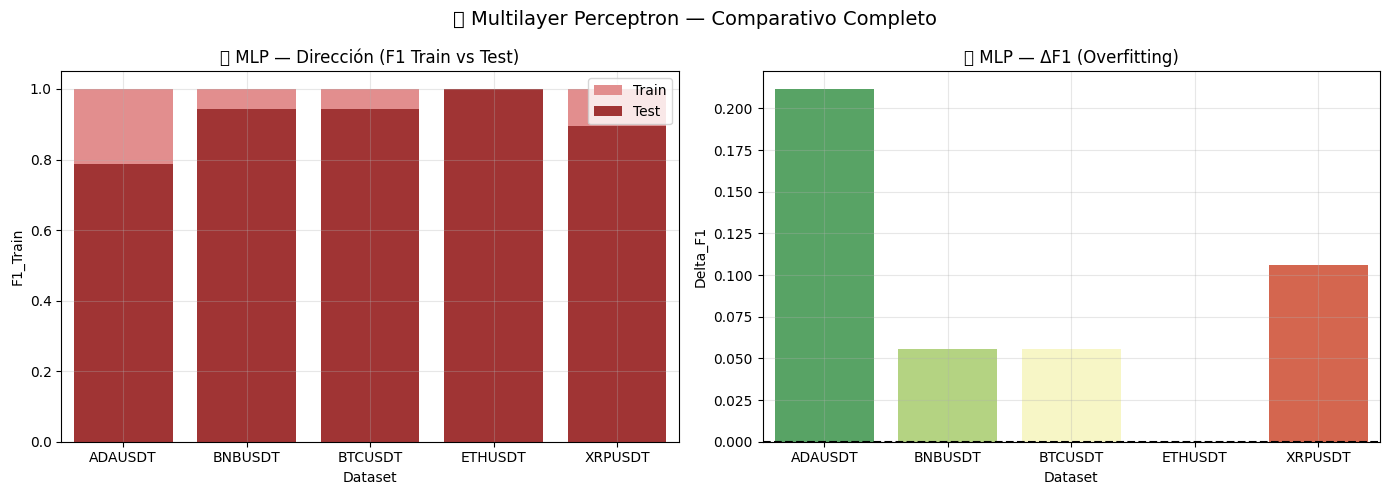

In [47]:
# ===============================================================
# 💥 MLP — CADENA COMPLETA (MOV + DIR)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV, train_test_split
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
f1_weighted = make_scorer(f1_score, average="weighted")
cv7 = StratifiedKFold(n_splits=7)

datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧩 FUNCIÓN DE PREPROCESAMIENTO
# ===============================================================
def crear_preprocesador(df):
    num_vars = list(df.select_dtypes(include=np.number).columns)
    cat_vars = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ])

# ===============================================================
# 🧠 FUNCIÓN PRINCIPAL — MLP OPTIMIZACIÓN COMPLETA
# ===============================================================
def ejecutar_busquedas_mlp(nombre, X, y, tipo):
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return pd.DataFrame()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    preproc = crear_preprocesador(X_train)
    base_pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", MLPClassifier(max_iter=5000))
    ])

    resultados, metricas_test = [], []

    # ==========================================================
    # Espacios de hiperparámetros
    # ==========================================================
    param_grid = {
        "model__hidden_layer_sizes": [(50,), (100,), (50, 25), (100, 50, 25)],
        "model__activation": ["relu", "tanh"],
        "model__solver": ["adam", "lbfgs"],
        "model__alpha": [0.0001, 0.001, 0.01],
        "model__learning_rate": ["constant", "adaptive"]
    }

    param_dist = {
        "model__hidden_layer_sizes": [(50,), (100,), (150,), (50, 25), (100, 50)],
        "model__activation": ["relu", "tanh"],
        "model__solver": ["adam", "lbfgs"],
        "model__alpha": np.logspace(-4, -1, 4),
        "model__learning_rate": ["constant", "adaptive"]
    }

    param_bayes = {
        "model__hidden_layer_sizes": Categorical([(50,), (100,), (100, 50, 25)]),
        "model__activation": Categorical(["relu", "tanh"]),
        "model__solver": Categorical(["adam", "lbfgs"]),
        "model__alpha": Real(1e-4, 1e-2, prior="log-uniform"),
        "model__learning_rate": Categorical(["constant", "adaptive"])
    }

    # ==========================================================
    # 1️⃣ GRID SEARCH
    # ==========================================================
    grid = GridSearchCV(base_pipe, param_grid, scoring=f1_weighted, cv=cv7, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    resultados.append(("GridSearch", grid.best_params_, grid.best_score_))
    metricas_test.append({
        "Metodo": "GridSearch",
        "F1_Test": f1_score(y_test, y_pred, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred, average="weighted")
    })

    # ==========================================================
    # 2️⃣ RANDOM SEARCH
    # ==========================================================
    rand = RandomizedSearchCV(base_pipe, param_distributions=param_dist, n_iter=40,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1)
    rand.fit(X_train, y_train)
    y_pred = rand.best_estimator_.predict(X_test)
    resultados.append(("Randomized", rand.best_params_, rand.best_score_))
    metricas_test.append({
        "Metodo": "Randomized",
        "F1_Test": f1_score(y_test, y_pred, average="weighted"),
        "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
        "Recall_Test": recall_score(y_test, y_pred, average="weighted")
    })

    # ==========================================================
    # 3️⃣ HALVING RANDOM SEARCH
    # ==========================================================
    try:
        halv = HalvingRandomSearchCV(base_pipe, param_distributions=param_dist,
                                     scoring=f1_weighted, cv=cv7, factor=3, n_jobs=-1)
        halv.fit(X_train, y_train)
        y_pred = halv.best_estimator_.predict(X_test)
        resultados.append(("Halving", halv.best_params_, halv.best_score_))
        metricas_test.append({
            "Metodo": "Halving",
            "F1_Test": f1_score(y_test, y_pred, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - Halving falló: {e}")
        resultados.append(("Halving", "-", np.nan))

    # ==========================================================
    # 4️⃣ BAYES SEARCH
    # ==========================================================
    try:
        bayes = BayesSearchCV(base_pipe, search_spaces=param_bayes, n_iter=20,
                              scoring=f1_weighted, cv=cv7, n_jobs=-1, random_state=42)
        bayes.fit(X_train, y_train)
        y_pred = bayes.best_estimator_.predict(X_test)
        resultados.append(("BayesSearch", bayes.best_params_, bayes.best_score_))
        metricas_test.append({
            "Metodo": "BayesSearch",
            "F1_Test": f1_score(y_test, y_pred, average="weighted"),
            "Precision_Test": precision_score(y_test, y_pred, average="weighted"),
            "Recall_Test": recall_score(y_test, y_pred, average="weighted")
        })
    except Exception as e:
        print(f"⚠️ {nombre} ({tipo}) - BayesSearch falló: {e}")
        resultados.append(("BayesSearch", "-", np.nan))

    df = pd.DataFrame(resultados, columns=["Metodo", "Mejores Parámetros", "F1_CV_Promedio"])
    df["Dataset"] = nombre
    df["Tipo"] = tipo
    df_metricas = pd.DataFrame(metricas_test)
    df_metricas["Dataset"] = nombre
    df_metricas["Tipo"] = tipo
    return df.merge(df_metricas, on=["Metodo", "Dataset", "Tipo"], how="left")

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_mov, resultados_dir = [], []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    resultados_mov.append(ejecutar_busquedas_mlp(nombre, X, y, "Movimiento"))

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60: continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    resultados_dir.append(ejecutar_busquedas_mlp(nombre, X, y, "Dirección"))

df_final = pd.concat(resultados_mov + resultados_dir, ignore_index=True)
df_final["F1_CV_Promedio"] = df_final["F1_CV_Promedio"].round(4)
df_best = df_final.loc[df_final.groupby(["Dataset", "Tipo"])["F1_CV_Promedio"].idxmax()].reset_index(drop=True)

# ===============================================================
# 🧠 VALIDACIÓN DE GENERALIZACIÓN
# ===============================================================
resumen_generalizacion = []
for _, fila in df_best.iterrows():
    dataset, tipo = fila["Dataset"], fila["Tipo"]
    df = datasets_raw[dataset].copy()

    if tipo == "Movimiento":
        df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
        X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore"); y = df["Label_Move"]
    else:
        df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
        df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
        X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore"); y = df_dir["Label_Direction"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    preproc = crear_preprocesador(X_train)
    modelo = MLPClassifier(max_iter=5000, **{k.replace("model__", ""): v for k, v in fila["Mejores Parámetros"].items() if not isinstance(v, str) or v != "-"})

    pipe = Pipeline([("preprocessor", preproc), ("model", modelo)])
    pipe.fit(X_train, y_train)

    y_pred_train, y_pred_test = pipe.predict(X_train), pipe.predict(X_test)
    f1_train, f1_test = f1_score(y_train, y_pred_train, average="weighted"), f1_score(y_test, y_pred_test, average="weighted")
    delta_f1 = f1_train - f1_test

    resumen_generalizacion.append({
        "Dataset": dataset, "Tipo": tipo, "Metodo": fila["Metodo"],
        "F1_Train": round(f1_train, 4), "F1_Test": round(f1_test, 4), "Delta_F1": round(delta_f1, 4)
    })

df_generalizacion = pd.DataFrame(resumen_generalizacion)
display(df_generalizacion.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — MLP"))

# ===============================================================
# 📊 VISUALIZACIÓN FINAL
# ===============================================================
df_best["Hiperparámetros"] = df_best["Mejores Parámetros"].apply(lambda x: ", ".join([f"{k.split('__')[-1]}={v}" for k, v in x.items()]))
df_summary = df_best.pivot(index="Dataset", columns="Tipo", values=["Metodo", "F1_CV_Promedio", "Hiperparámetros"])
display(df_summary.style.set_caption("📋 RESUMEN FINAL — MLP"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="lightcoral", label="Train", ax=axes[0])
sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="firebrick", label="Test", ax=axes[0])
axes[0].set_title("💥 MLP — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05); axes[0].legend(); axes[0].grid(alpha=0.3)

sns.barplot(data=df_generalizacion[df_generalizacion["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("💥 MLP — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 Multilayer Perceptron — Comparativo Completo", fontsize=14)
plt.tight_layout(); plt.show()


## Red Neuronal Keras

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 1 — F1_train: 0.9285, F1_val: 0.9295, epochs: 25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 2 — F1_train: 0.9335, F1_val: 0.9295, epochs: 26
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3 — F1_train: 0.9285, F1_val: 0.9295, epochs: 24
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 4 — F1_train: 0.9285, F1_val: 0.9295, epochs: 25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 5 — F1_train: 0.9295, F1_val: 0.9254, epochs: 24
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 1 — F1_train: 0.9213, F1_val: 0.9254, epochs: 25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 2 — F1_train: 0.9274, F1_val: 0.9213, epochs: 27
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 

,Dataset,Tipo,F1_Train,F1_Test,Delta_F1,Epochs_Promedio
0,BTCUSDT,Movimiento,0.929700,0.928700,0.001000,24
1,ETHUSDT,Movimiento,0.923100,0.922200,0.000900,25
2,ADAUSDT,Movimiento,0.925500,0.923800,0.001700,24
3,XRPUSDT,Movimiento,0.936700,0.924000,0.012600,28
4,BNBUSDT,Movimiento,0.929400,0.927100,0.002300,26
5,BTCUSDT,Dirección,0.909400,0.869700,0.039700,30
6,ETHUSDT,Dirección,0.965500,0.880700,0.084800,62
7,ADAUSDT,Dirección,0.953500,0.869900,0.083600,45
8,XRPUSDT,Dirección,0.960200,0.903200,0.057000,44
9,BNBUSDT,Dirección,0.988600,0.910100,0.078500,48


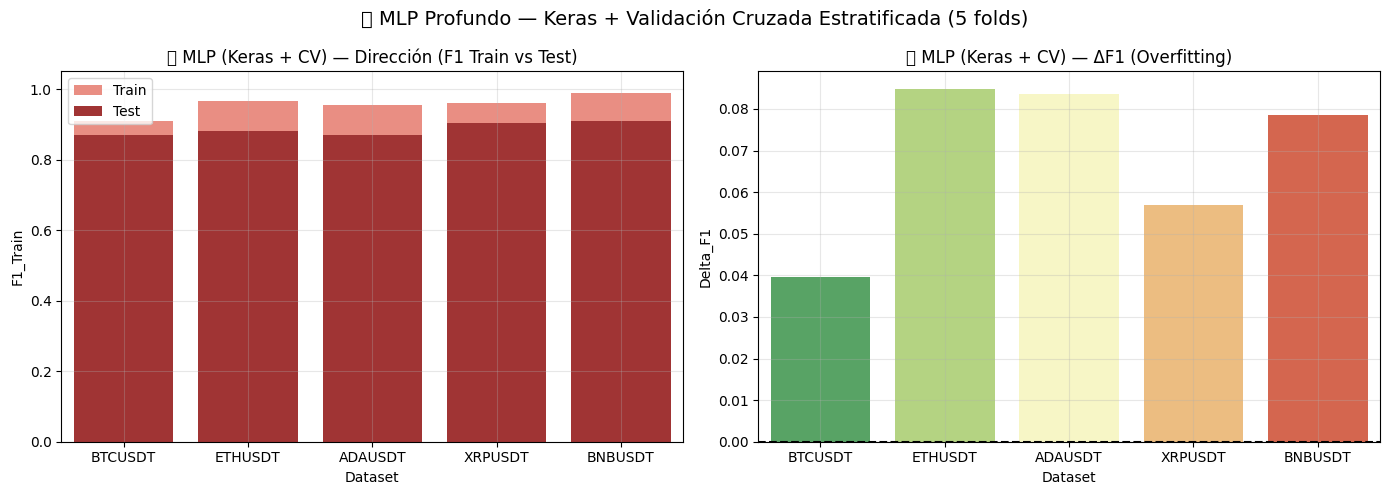

In [49]:
# ===============================================================
# 💥 MLP PROFUNDO — Keras + Validación Cruzada Estratificada
# ===============================================================

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ===============================================================
# ⚙️ CONFIGURACIÓN GENERAL
# ===============================================================
datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 20
KFOLDS = 5

# ===============================================================
# 🧩 FUNCIÓN DE PREPROCESAMIENTO
# ===============================================================
def crear_preprocesador(df):
    num_vars = list(df.select_dtypes(include=np.number).columns)
    cat_vars = list(df.select_dtypes(exclude=np.number).columns)
    return ColumnTransformer([
        ("num", StandardScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ])

# ===============================================================
# 🧠 FUNCIÓN PARA CREAR EL MODELO
# ===============================================================
def crear_modelo_keras(input_dim, capas=[128, 64, 32], dropout_rate=0.2, lr=0.001):
    model = Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for n in capas:
        model.add(layers.Dense(n, activation="relu"))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy")
    return model

# ===============================================================
# 🚀 FUNCIÓN DE VALIDACIÓN CRUZADA
# ===============================================================
def entrenar_cv_keras(nombre, X, y, tipo):
    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}, se omite.")
        return None

    preproc = crear_preprocesador(X)
    X_prep = preproc.fit_transform(X)
    input_dim = X_prep.shape[1]

    skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True)
    f1_train_scores, f1_test_scores = [], []
    epochs_usados = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_prep, y), 1):
        X_train, X_val = X_prep[train_idx], X_prep[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = crear_modelo_keras(input_dim)
        es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[es]
        )

        y_pred_train = (model.predict(X_train) > 0.5).astype(int)
        y_pred_val = (model.predict(X_val) > 0.5).astype(int)

        f1_train = f1_score(y_train, y_pred_train, average="weighted")
        f1_val = f1_score(y_val, y_pred_val, average="weighted")

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_val)
        epochs_usados.append(len(history.history["loss"]))

        print(f"Fold {fold} — F1_train: {f1_train:.4f}, F1_val: {f1_val:.4f}, epochs: {epochs_usados[-1]}")

    return {
        "Dataset": nombre,
        "Tipo": tipo,
        "F1_Train": round(np.mean(f1_train_scores), 4),
        "F1_Test": round(np.mean(f1_test_scores), 4),
        "Delta_F1": round(np.mean(f1_train_scores) - np.mean(f1_test_scores), 4),
        "Epochs_Promedio": int(np.mean(epochs_usados))
    }

# ===============================================================
# 🚀 ENTRENAMIENTO MOVIMIENTO Y DIRECCIÓN
# ===============================================================
resultados_total = []

print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
for nombre, df in datasets_raw.items():
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    if df["Label_Move"].sum() < 20: 
        continue
    X = df.drop(columns=["Manual_Label", "Label_Move"], errors="ignore")
    y = df["Label_Move"]
    res = entrenar_cv_keras(nombre, X, y, "Movimiento")
    if res: resultados_total.append(res)

print("\n🚀 BLOQUE 2 — DIRECCIÓN (BUY vs SELL)\n")
for nombre, df in datasets_raw.items():
    df_dir = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_dir) < 60:
        continue
    df_dir["Label_Direction"] = df_dir["Manual_Label"].map({"B": 1, "S": 0})
    X = df_dir.drop(columns=["Manual_Label", "Label_Direction"], errors="ignore")
    y = df_dir["Label_Direction"]
    res = entrenar_cv_keras(nombre, X, y, "Dirección")
    if res: resultados_total.append(res)

# ===============================================================
# 📊 RESULTADOS FINALES
# ===============================================================
df_cvkeras = pd.DataFrame(resultados_total)
display(df_cvkeras.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r").set_caption("🔎 Evaluación Global — MLP (Keras + CV Estratificada)"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df_cvkeras[df_cvkeras["Tipo"]=="Dirección"], x="Dataset", y="F1_Train", color="salmon", label="Train", ax=axes[0])
sns.barplot(data=df_cvkeras[df_cvkeras["Tipo"]=="Dirección"], x="Dataset", y="F1_Test", color="firebrick", label="Test", ax=axes[0])
axes[0].set_title("💥 MLP (Keras + CV) — Dirección (F1 Train vs Test)")
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(alpha=0.3)

sns.barplot(data=df_cvkeras[df_cvkeras["Tipo"]=="Dirección"], x="Dataset", y="Delta_F1", palette="RdYlGn_r", ax=axes[1])
axes[1].axhline(0, color="black", linestyle="--")
axes[1].set_title("💥 MLP (Keras + CV) — ΔF1 (Overfitting)")
axes[1].grid(alpha=0.3)

plt.suptitle("📈 MLP Profundo — Keras + Validación Cruzada Estratificada (5 folds)", fontsize=14)
plt.tight_layout()
plt.show()


## Optimizacion de MPL con Keras Tuner

In [54]:
# ===============================================================
# ⚡ OPTIMIZACIÓN MLP (KerasTuner) EN PARALELO POR MONEDA — Victor Aguirre
# ===============================================================

import os, warnings, multiprocessing, shutil, glob
import pandas as pd, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

# ===============================================================
# 🧩 CONFIGURACIÓN GLOBAL
# ===============================================================
EPOCHS = 400
PATIENCE = 20
MAX_TRIALS = 25
EXECUTIONS_PER_TRIAL = 1

# (usar tus datasets reales)
datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# ⚙️ FUNCIONES BASE
# ===============================================================
def preprocess(df):
    num_vars = list(df.select_dtypes(include=np.number).columns)
    cat_vars = list(df.select_dtypes(exclude=np.number).columns)
    preproc = ColumnTransformer([
        ("num", StandardScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars)
    ])
    return preproc


def build_model(hp, input_dim):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Capas ocultas (2–6 capas, hasta 512 neuronas cada una)
    for i in range(hp.Int("num_layers", 2, 6)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", 64, 512, step=64),
            activation=hp.Choice(f"activation_{i}", ["relu", "tanh"])
        ))
        if hp.Boolean(f"use_dropout_{i}"):
            model.add(layers.Dropout(hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)))

    model.add(layers.Dense(1, activation="sigmoid"))

    opt_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    if opt_choice == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss="binary_crossentropy")
    return model


def optimizar_keras_tuner(nombre, X, y, tipo):
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # modo silencioso
    tf.keras.backend.clear_session()

    print(f"\n🚀 OPTIMIZACIÓN KERAS — {nombre} ({tipo})")

    if len(np.unique(y)) < 2:
        print(f"⚠️ {nombre}: solo una clase presente en {tipo}.")
        return None

    # División train/test
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y
    )

    preproc = preprocess(X_train)
    X_train_prep = preproc.fit_transform(X_train)
    X_val_prep = preproc.transform(X_val)
    input_dim = X_train_prep.shape[1]

    def model_builder(hp):
        return build_model(hp, input_dim)

    # --- Limpieza y nombre seguro del proyecto (evita errores de codificación)
    safe_name = f"{nombre}_{tipo}".encode("ascii", "ignore").decode().replace(" ", "_")
    safe_name = "".join(c if c.isalnum() or c in "_-" else "_" for c in safe_name)

    # Si ya existe el directorio previo, limpiarlo
    path_log = os.path.join("tuner_logs", safe_name)
    if os.path.exists(path_log):
        shutil.rmtree(path_log, ignore_errors=True)

    tuner = kt.BayesianOptimization(
        model_builder,
        objective="val_loss",
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        overwrite=True,
        directory="tuner_logs",
        project_name=safe_name
    )

    tuner.search_space_summary()
    tuner.oracle.hyperparameters.Choice("batch_size", [16, 32, 64])

    es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

    tuner.search(
        X_train_prep, y_train,
        epochs=EPOCHS,
        validation_data=(X_val_prep, y_val),
        callbacks=[es],
        verbose=0
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    best_model = tuner.hypermodel.build(best_hp)
    batch_size = best_hp.get("batch_size")

    history = best_model.fit(
        X_train_prep, y_train,
        validation_data=(X_val_prep, y_val),
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    y_pred_train = (best_model.predict(X_train_prep, verbose=0) > 0.5).astype(int)
    y_pred_val = (best_model.predict(X_val_prep, verbose=0) > 0.5).astype(int)
    f1_train = f1_score(y_train, y_pred_train, average="weighted")
    f1_val = f1_score(y_val, y_pred_val, average="weighted")

    print(f"✅ {nombre} ({tipo}) — F1_train: {f1_train:.4f}, F1_val: {f1_val:.4f}")

    return {
        "Dataset": nombre,
        "Tipo": tipo,
        "F1_Train": round(f1_train, 4),
        "F1_Test": round(f1_val, 4),
        "Delta_F1": round(f1_train - f1_val, 4),
        "Best_Params": best_hp.values
    }

# ===============================================================
# 🚀 PARALELIZACIÓN TOTAL ENTRE MONEDAS
# ===============================================================
if __name__ == "__main__":
    multiprocessing.set_start_method("spawn", force=True)
    num_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"✅ Paralelización activa con {num_cores} núcleos.\n")

    # MOVIMIENTO
    print("🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)\n")
    resultados_mov = Parallel(n_jobs=num_cores)(
        delayed(optimizar_keras_tuner)(
            nombre,
            df.drop(columns=["Manual_Label"], errors="ignore"),
            df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0),
            "Movimiento"
        )
        for nombre, df in datasets_raw.items()
    )

    # DIRECCIÓN (sin acentos)
    print("\n🚀 BLOQUE 2 — DIRECCION (BUY vs SELL)\n")
    resultados_dir = Parallel(n_jobs=num_cores)(
        delayed(optimizar_keras_tuner)(
            nombre,
            df[df["Manual_Label"].isin(["B", "S"])].drop(columns=["Manual_Label"], errors="ignore"),
            df[df["Manual_Label"].isin(["B", "S"])]["Manual_Label"].map({"B": 1, "S": 0}),
            "Direccion"
        )
        for nombre, df in datasets_raw.items()
    )

    # RESULTADOS FINALES
    df_tuner = pd.DataFrame([r for r in resultados_mov + resultados_dir if r])
    display(df_tuner.style.background_gradient(subset=["Delta_F1"], cmap="RdYlGn_r")
            .set_caption("🔎 Evaluación Global — KerasTuner Paralelizado"))

    for i, fila in df_tuner.iterrows():
        print(f"\n🏆 {fila['Dataset']} ({fila['Tipo']}) — Best Params:")
        for k, v in fila["Best_Params"].items():
            print(f"   {k}: {v}")


✅ Paralelización activa con 55 núcleos.

🚀 BLOQUE 1 — MOVIMIENTO (B/S vs HOLD)


🚀 BLOQUE 2 — DIRECCION (BUY vs SELL)



,Dataset,Tipo,F1_Train,F1_Test,Delta_F1,Best_Params
0,BTCUSDT,Movimiento,1.000000,1.000000,0.000000,"{'num_layers': 5, 'units_0': 256, 'activation_0': 'tanh', 'use_dropout_0': False, 'units_1': 192, 'activation_1': 'relu', 'use_dropout_1': False, 'optimizer': 'adam', 'learning_rate': 0.004981736647877477, 'batch_size': 16, 'dropout_0': 0.4, 'dropout_1': 0.2, 'units_2': 64, 'activation_2': 'tanh', 'use_dropout_2': False, 'units_3': 192, 'activation_3': 'tanh', 'use_dropout_3': False, 'units_4': 256, 'activation_4': 'relu', 'use_dropout_4': False, 'dropout_2': 0.4, 'dropout_3': 0.1, 'units_5': 448, 'activation_5': 'tanh', 'use_dropout_5': True, 'dropout_4': 0.5, 'dropout_5': 0.1}"
1,ETHUSDT,Movimiento,1.000000,1.000000,0.000000,"{'num_layers': 4, 'units_0': 512, 'activation_0': 'relu', 'use_dropout_0': False, 'units_1': 512, 'activation_1': 'tanh', 'use_dropout_1': True, 'optimizer': 'adam', 'learning_rate': 0.00511185911937983, 'batch_size': 32, 'dropout_0': 0.30000000000000004, 'units_2': 192, 'activation_2': 'relu', 'use_dropout_2': True, 'units_3': 448, 'activation_3': 'relu', 'use_dropout_3': False, 'dropout_1': 0.2, 'dropout_2': 0.2, 'dropout_3': 0.30000000000000004, 'units_4': 128, 'activation_4': 'tanh', 'use_dropout_4': True, 'units_5': 384, 'activation_5': 'relu', 'use_dropout_5': True, 'dropout_4': 0.1, 'dropout_5': 0.5}"
2,ADAUSDT,Movimiento,1.000000,1.000000,0.000000,"{'num_layers': 4, 'units_0': 448, 'activation_0': 'relu', 'use_dropout_0': False, 'units_1': 192, 'activation_1': 'relu', 'use_dropout_1': True, 'optimizer': 'adam', 'learning_rate': 0.0008474082490627714, 'batch_size': 64, 'dropout_0': 0.1, 'units_2': 128, 'activation_2': 'relu', 'use_dropout_2': False, 'units_3': 512, 'activation_3': 'relu', 'use_dropout_3': False, 'dropout_1': 0.30000000000000004, 'units_4': 320, 'activation_4': 'relu', 'use_dropout_4': True, 'units_5': 128, 'activation_5': 'relu', 'use_dropout_5': False, 'dropout_5': 0.2, 'dropout_2': 0.30000000000000004, 'dropout_4': 0.1, 'dropout_3': 0.4}"
3,XRPUSDT,Movimiento,1.000000,1.000000,0.000000,"{'num_layers': 6, 'units_0': 128, 'activation_0': 'tanh', 'use_dropout_0': True, 'units_1': 512, 'activation_1': 'tanh', 'use_dropout_1': True, 'optimizer': 'rmsprop', 'learning_rate': 0.006371363958944976, 'batch_size': 16, 'dropout_0': 0.2, 'dropout_1': 0.30000000000000004, 'units_2': 128, 'activation_2': 'tanh', 'use_dropout_2': True, 'units_3': 192, 'activation_3': 'relu', 'use_dropout_3': True, 'units_4': 192, 'activation_4': 'relu', 'use_dropout_4': True, 'dropout_3': 0.4, 'dropout_4': 0.2, 'units_5': 64, 'activation_5': 'relu', 'use_dropout_5': True, 'dropout_2': 0.5, 'dropout_5': 0.5}"
4,BNBUSDT,Movimiento,1.000000,0.997200,0.002800,"{'num_layers': 6, 'units_0': 448, 'activation_0': 'relu', 'use_dropout_0': True, 'units_1': 320, 'activation_1': 'relu', 'use_dropout_1': True, 'optimizer': 'rmsprop', 'learning_rate': 0.0003050774916361882, 'batch_size': 64, 'dropout_0': 0.2, 'dropout_1': 0.2, 'units_2': 64, 'activation_2': 'relu', 'use_dropout_2': False, 'units_3': 320, 'activation_3': 'relu', 'use_dropout_3': False, 'dropout_2': 0.2, 'dropout_3': 0.4, 'units_4': 320, 'activation_4': 'relu', 'use_dropout_4': False, 'units_5': 128, 'activation_5': 'relu', 'use_dropout_5': True, 'dropout_5': 0.1, 'dropout_4': 0.2}"
5,BTCUSDT,Direccion,0.896500,0.888900,0.007600,"{'num_layers': 6, 'units_0': 192, 'activation_0': 'tanh', 'use_dropout_0': False, 'units_1': 128, 'activation_1': 'relu', 'use_dropout_1': False, 'optimizer': 'rmsprop', 'learning_rate': 0.003974209356331356, 'batch_size': 64, 'dropout_0': 0.2, 'dropout_1': 0.30000000000000004, 'units_2': 256, 'activation_2': 'relu', 'use_dropout_2': False, 'units_3': 192, 'activation_3': 'tanh', 'use_dropout_3': False, 'units_4': 128, 'activation_4': 'tanh', 'use_dropout_4': True, 'dropout_3': 0.4, 'units_5': 320, 'activation_5': 'relu', 'use_dropout_5': True, 'dropout_2': 0.1, 'dropout_4': 0.5, 'dropout_5': 0.4}"
6,ETHUSDT,Direccion,1.000000,0.89470


🏆 BTCUSDT (Movimiento) — Best Params:
   num_layers: 5
   units_0: 256
   activation_0: tanh
   use_dropout_0: False
   units_1: 192
   activation_1: relu
   use_dropout_1: False
   optimizer: adam
   learning_rate: 0.004981736647877477
   batch_size: 16
   dropout_0: 0.4
   dropout_1: 0.2
   units_2: 64
   activation_2: tanh
   use_dropout_2: False
   units_3: 192
   activation_3: tanh
   use_dropout_3: False
   units_4: 256
   activation_4: relu
   use_dropout_4: False
   dropout_2: 0.4
   dropout_3: 0.1
   units_5: 448
   activation_5: tanh
   use_dropout_5: True
   dropout_4: 0.5
   dropout_5: 0.1

🏆 ETHUSDT (Movimiento) — Best Params:
   num_layers: 4
   units_0: 512
   activation_0: relu
   use_dropout_0: False
   units_1: 512
   activation_1: tanh
   use_dropout_1: True
   optimizer: adam
   learning_rate: 0.00511185911937983
   batch_size: 32
   dropout_0: 0.30000000000000004
   units_2: 192
   activation_2: relu
   use_dropout_2: True
   units_3: 448
   activation_3: relu
   

## Red Neuronales LSTM y GRU

In [57]:
# ===============================================================
# 🔮 PREDICCIÓN DE MOVIMIENTO + DIRECCIÓN — Victor Aguirre
# ===============================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

tf.keras.backend.clear_session()

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================

def generar_label_movimiento(df, ventana=5):
    """
    Genera una etiqueta de movimiento futuro:
    1 si en las próximas `ventana` velas ocurre B o S.
    0 si no ocurre nada (H).
    """
    manual = df["Manual_Label"].fillna("H").values
    label = np.zeros(len(manual))
    for i in range(len(manual) - ventana):
        if any(l in ["B", "S"] for l in manual[i+1:i+1+ventana]):
            label[i] = 1
    return label


def crear_secuencias(df, target_col, window_size=20):
    """Transforma el dataset en formato secuencial para LSTM/GRU."""
    X, y = [], []
    data = df.drop(columns=[target_col]).values
    labels = df[target_col].values
    for i in range(window_size, len(df)):
        X.append(data[i - window_size:i])
        y.append(labels[i])
    return np.array(X), np.array(y)


def crear_modelo_rnn(input_shape, tipo="LSTM"):
    """Construye una red recurrente (LSTM o GRU) con dropout."""
    model = Sequential()
    if tipo == "LSTM":
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(LSTM(64))
    elif tipo == "GRU":
        model.add(GRU(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(GRU(64))
    else:
        raise ValueError("tipo debe ser 'LSTM' o 'GRU'")

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


def entrenar_rnn_temporal(nombre, df, target_col, tipo="LSTM", window_size=20):
    """Entrena una RNN (LSTM o GRU) con validación cruzada temporal."""
    print(f"\n🚀 Entrenando {tipo} para {nombre} ({target_col})")

    X, y = crear_secuencias(df, target_col=target_col, window_size=window_size)
    print(f"📊 {nombre} — Shape: {X.shape}, {y.shape}")

    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = crear_modelo_rnn(X_train.shape[1:], tipo=tipo)
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=150,
            batch_size=32,
            callbacks=[es],
            verbose=0
        )

        y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        f1_scores.append(f1)
        print(f"   Fold {fold+1}: F1 = {f1:.4f}")

    avg_f1 = np.mean(f1_scores)
    print(f"✅ {nombre} ({tipo}) — F1 promedio: {avg_f1:.4f}")
    return avg_f1


# ===============================================================
# 📦 CONFIGURACIÓN DE DATASETS
# ===============================================================
datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧪 BLOQUE 1 — DETECCIÓN DE MOVIMIENTO FUTURO (HOLD vs MOV)
# ===============================================================
resultados_mov = []

for nombre, df in datasets_raw.items():
    if "Manual_Label" not in df.columns:
        continue

    df_temp = df.copy()
    df_temp["Label_Move"] = generar_label_movimiento(df_temp, ventana=5)
    df_temp = df_temp.dropna().select_dtypes(include=[np.number])
    if df_temp["Label_Move"].nunique() < 2:
        print(f"⚠️ {nombre}: solo una clase en Label_Move, se omite.")
        continue

    f1_lstm = entrenar_rnn_temporal(nombre, df_temp, "Label_Move", tipo="LSTM")
    f1_gru = entrenar_rnn_temporal(nombre, df_temp, "Label_Move", tipo="GRU")

    resultados_mov.append({
        "Dataset": nombre,
        "Tipo": "Movimiento (Predictivo)",
        "LSTM_F1": round(f1_lstm, 4),
        "GRU_F1": round(f1_gru, 4)
    })


# ===============================================================
# 🧭 BLOQUE 2 — DIRECCIÓN DEL MOVIMIENTO (BUY vs SELL)
# ===============================================================
resultados_dir = []

for nombre, df in datasets_raw.items():
    if "Manual_Label" not in df.columns:
        continue

    df_bin = df[df["Manual_Label"].isin(["B", "S"])].copy()
    if len(df_bin) < 40:
        print(f"⚠️ {nombre}: pocos registros con B/S, se omite.")
        continue

    df_bin["Label_BS"] = df_bin["Manual_Label"].map({"B": 1, "S": 0})
    df_limpio = df_bin.dropna().select_dtypes(include=[np.number])
    df_limpio["Label_BS"] = df_bin["Label_BS"]

    f1_lstm = entrenar_rnn_temporal(nombre, df_limpio, "Label_BS", tipo="LSTM")
    f1_gru = entrenar_rnn_temporal(nombre, df_limpio, "Label_BS", tipo="GRU")

    resultados_dir.append({
        "Dataset": nombre,
        "Tipo": "Dirección (B/S)",
        "LSTM_F1": round(f1_lstm, 4),
        "GRU_F1": round(f1_gru, 4)
    })


# ===============================================================
# 📊 RESUMEN FINAL
# ===============================================================
df_rnn = pd.DataFrame(resultados_mov + resultados_dir)
df_rnn = df_rnn.sort_values(["Tipo", "Dataset"]).reset_index(drop=True)
display(df_rnn.style.set_caption("📈 LSTM vs GRU — Movimiento y Dirección Predictiva")
        .background_gradient(subset=["LSTM_F1", "GRU_F1"], cmap="YlGnBu"))

print("\n🏁 Evaluación Final:")
print(df_rnn.to_string(index=False))



🚀 Entrenando LSTM para BTCUSDT (Label_Move)
📊 BTCUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.0000
   Fold 2: F1 = 0.0000
   Fold 3: F1 = 0.0000
   Fold 4: F1 = 0.0000
   Fold 5: F1 = 0.0000
✅ BTCUSDT (LSTM) — F1 promedio: 0.0000

🚀 Entrenando GRU para BTCUSDT (Label_Move)
📊 BTCUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.0000
   Fold 2: F1 = 0.0000
   Fold 3: F1 = 0.0000
   Fold 4: F1 = 0.0000
   Fold 5: F1 = 0.0000
✅ BTCUSDT (GRU) — F1 promedio: 0.0000

🚀 Entrenando LSTM para ETHUSDT (Label_Move)
📊 ETHUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.0000
   Fold 2: F1 = 0.0000
   Fold 3: F1 = 0.0000
   Fold 4: F1 = 0.0000
   Fold 5: F1 = 0.0000
✅ ETHUSDT (LSTM) — F1 promedio: 0.0000

🚀 Entrenando GRU para ETHUSDT (Label_Move)
📊 ETHUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.0000
   Fold 2: F1 = 0.0000
   Fold 3: F1 = 0.0000
   Fold 4: F1 = 0.1593
   Fold 5: F1 = 0.0000
✅ ETHUSDT (GRU) — F1 promedio: 0.0319

🚀 Entrenando LSTM para ADAUSDT 

,Dataset,Tipo,LSTM_F1,GRU_F1
0,ADAUSDT,Dirección (B/S),0.504100,0.253800
1,BNBUSDT,Dirección (B/S),0.523100,0.575000
2,BTCUSDT,Dirección (B/S),0.732400,0.684000
3,ETHUSDT,Dirección (B/S),0.333300,0.328200
4,XRPUSDT,Dirección (B/S),0.418200,0.493300
5,ADAUSDT,Movimiento (Predictivo),0.000000,0.000000
6,BNBUSDT,Movimiento (Predictivo),0.000000,0.000000
7,BTCUSDT,Movimiento (Predictivo),0.000000,0.000000
8,ETHUSDT,Movimiento (Predictivo),0.000000,0.031900
9,XRPUSDT,Movimiento (Predictivo),0.000000,0.000000



🏁 Evaluación Final:
Dataset                    Tipo  LSTM_F1  GRU_F1
ADAUSDT         Dirección (B/S)   0.5041  0.2538
BNBUSDT         Dirección (B/S)   0.5231  0.5750
BTCUSDT         Dirección (B/S)   0.7324  0.6840
ETHUSDT         Dirección (B/S)   0.3333  0.3282
XRPUSDT         Dirección (B/S)   0.4182  0.4933
ADAUSDT Movimiento (Predictivo)   0.0000  0.0000
BNBUSDT Movimiento (Predictivo)   0.0000  0.0000
BTCUSDT Movimiento (Predictivo)   0.0000  0.0000
ETHUSDT Movimiento (Predictivo)   0.0000  0.0319
XRPUSDT Movimiento (Predictivo)   0.0000  0.0000


## Red Neuronal CNN + LSTM

In [58]:
# ===============================================================
# 🔮 DETECCIÓN DE MOVIMIENTOS — CNN + LSTM con balanceo
# ===============================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

tf.keras.backend.clear_session()

# ===============================================================
# 🧩 FUNCIONES AUXILIARES
# ===============================================================

def generar_label_movimiento(df, ventana=15):
    """
    Etiqueta predictiva: 1 si en las próximas `ventana` velas ocurre B o S.
    """
    manual = df["Manual_Label"].fillna("H").values
    label = np.zeros(len(manual))
    for i in range(len(manual) - ventana):
        futuro = manual[i+1:i+1+ventana]
        if any(l in ["B", "S"] for l in futuro):
            label[i] = 1
    return label


def crear_secuencias(df, target_col, window_size=20):
    """Transforma el dataset en formato secuencial (para LSTM/CNN)."""
    X, y = [], []
    data = df.drop(columns=[target_col]).values
    labels = df[target_col].values
    for i in range(window_size, len(df)):
        X.append(data[i - window_size:i])
        y.append(labels[i])
    return np.array(X), np.array(y)


def balancear_df(df, target_col):
    """
    Balanceo simple: undersampling de clase mayoritaria (0) para
    igualar o triplicar el número de positivos.
    """
    pos = df[df[target_col] == 1]
    neg = df[df[target_col] == 0]
    if len(pos) == 0 or len(neg) == 0:
        return df
    neg_sample = neg.sample(n=min(len(neg), len(pos)*3), replace=False, random_state=None)
    df_bal = pd.concat([pos, neg_sample]).sample(frac=1)
    return df_bal


# ===============================================================
# 🧠 MODELOS CNN-LSTM Y GRU-CNN-LSTM
# ===============================================================

def crear_modelo_cnn_lstm(input_shape, tipo="LSTM"):
    """Crea una red híbrida CNN + LSTM o CNN + GRU."""
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    if tipo == "LSTM":
        model.add(LSTM(64, return_sequences=False))
    elif tipo == "GRU":
        model.add(GRU(64, return_sequences=False))
    else:
        raise ValueError("tipo debe ser 'LSTM' o 'GRU'")

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ===============================================================
# 🚀 FUNCIÓN DE ENTRENAMIENTO TEMPORAL
# ===============================================================

def entrenar_cnn_lstm_temporal(nombre, df, target_col, tipo="LSTM", window_size=20):
    print(f"\n🚀 Entrenando {tipo} para {nombre} ({target_col})")

    X, y = crear_secuencias(df, target_col=target_col, window_size=window_size)
    print(f"📊 {nombre} — Shape: {X.shape}, {y.shape}")

    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = crear_modelo_cnn_lstm(X_train.shape[1:], tipo=tipo)
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=200,
            batch_size=32,
            callbacks=[es],
            verbose=0
        )

        y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        f1_scores.append(f1)
        print(f"   Fold {fold+1}: F1 = {f1:.4f}")

    avg_f1 = np.mean(f1_scores)
    print(f"✅ {nombre} ({tipo}) — F1 promedio: {avg_f1:.4f}")
    return avg_f1


# ===============================================================
# 📦 CONFIGURACIÓN DE DATASETS
# ===============================================================
datasets_raw = {
    "BTCUSDT": df_btc,
    "ETHUSDT": df_eth,
    "ADAUSDT": df_ada,
    "XRPUSDT": df_xrp,
    "BNBUSDT": df_bnb
}

# ===============================================================
# 🧪 BLOQUE — DETECCIÓN PREDICTIVA DE MOVIMIENTOS
# ===============================================================
resultados_mov_cnn = []

for nombre, df in datasets_raw.items():
    if "Manual_Label" not in df.columns:
        continue

    df_temp = df.copy()
    df_temp["Label_Move"] = generar_label_movimiento(df_temp, ventana=15)
    df_temp = df_temp.dropna().select_dtypes(include=[np.number])

    if df_temp["Label_Move"].nunique() < 2:
        print(f"⚠️ {nombre}: solo una clase en Label_Move, se omite.")
        continue

    # --- Balanceo
    df_bal = balancear_df(df_temp, "Label_Move")

    # --- Entrenamiento CNN-LSTM y CNN-GRU
    f1_cnn_lstm = entrenar_cnn_lstm_temporal(nombre, df_bal, "Label_Move", tipo="LSTM")
    f1_cnn_gru = entrenar_cnn_lstm_temporal(nombre, df_bal, "Label_Move", tipo="GRU")

    resultados_mov_cnn.append({
        "Dataset": nombre,
        "Tipo": "Movimiento (CNN-LSTM Predictivo)",
        "CNN_LSTM_F1": round(f1_cnn_lstm, 4),
        "CNN_GRU_F1": round(f1_cnn_gru, 4)
    })


# ===============================================================
# 📊 RESULTADOS FINALES
# ===============================================================
df_cnn_rnn = pd.DataFrame(resultados_mov_cnn)
display(df_cnn_rnn.style.set_caption("📈 CNN-LSTM vs CNN-GRU — Movimiento Predictivo")
        .background_gradient(subset=["CNN_LSTM_F1", "CNN_GRU_F1"], cmap="YlGnBu"))

print("\n🏁 Evaluación Final:")
print(df_cnn_rnn.to_string(index=False))



🚀 Entrenando LSTM para BTCUSDT (Label_Move)
📊 BTCUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.6812
   Fold 2: F1 = 0.7446
   Fold 3: F1 = 0.6734
   Fold 4: F1 = 0.7489
   Fold 5: F1 = 0.7605
✅ BTCUSDT (LSTM) — F1 promedio: 0.7217

🚀 Entrenando GRU para BTCUSDT (Label_Move)
📊 BTCUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.6514
   Fold 2: F1 = 0.7473
   Fold 3: F1 = 0.7447
   Fold 4: F1 = 0.7321
   Fold 5: F1 = 0.7605
✅ BTCUSDT (GRU) — F1 promedio: 0.7272

🚀 Entrenando LSTM para ETHUSDT (Label_Move)
📊 ETHUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.7738
   Fold 2: F1 = 0.7984
   Fold 3: F1 = 0.7935
   Fold 4: F1 = 0.7663
   Fold 5: F1 = 0.7810
✅ ETHUSDT (LSTM) — F1 promedio: 0.7826

🚀 Entrenando GRU para ETHUSDT (Label_Move)
📊 ETHUSDT — Shape: (1775, 20, 106), (1775,)
   Fold 1: F1 = 0.7860
   Fold 2: F1 = 0.7967
   Fold 3: F1 = 0.7935
   Fold 4: F1 = 0.7708
   Fold 5: F1 = 0.7715
✅ ETHUSDT (GRU) — F1 promedio: 0.7837

🚀 Entrenando LSTM para ADAUSDT 

,Dataset,Tipo,CNN_LSTM_F1,CNN_GRU_F1
0,BTCUSDT,Movimiento (CNN-LSTM Predictivo),0.721700,0.727200
1,ETHUSDT,Movimiento (CNN-LSTM Predictivo),0.782600,0.783700
2,ADAUSDT,Movimiento (CNN-LSTM Predictivo),0.741100,0.694200
3,XRPUSDT,Movimiento (CNN-LSTM Predictivo),0.768100,0.769000
4,BNBUSDT,Movimiento (CNN-LSTM Predictivo),0.718400,0.712800



🏁 Evaluación Final:
Dataset                             Tipo  CNN_LSTM_F1  CNN_GRU_F1
BTCUSDT Movimiento (CNN-LSTM Predictivo)       0.7217      0.7272
ETHUSDT Movimiento (CNN-LSTM Predictivo)       0.7826      0.7837
ADAUSDT Movimiento (CNN-LSTM Predictivo)       0.7411      0.6942
XRPUSDT Movimiento (CNN-LSTM Predictivo)       0.7681      0.7690
BNBUSDT Movimiento (CNN-LSTM Predictivo)       0.7184      0.7128


### optimizacion ya que vimos que funciona para movimiento

In [62]:
import os
os.makedirs("data", exist_ok=True)


In [65]:
# ===============================================================
# 💾 PREPARAR Y GUARDAR DATASETS PARA OPTIMIZACIÓN PARALELA
# ===============================================================
import os
import numpy as np
os.makedirs("data", exist_ok=True)

window_size = 20
ventana_futuro = 15

for nombre, df in datasets_raw.items():
    print(f"⚙️ Procesando {nombre}...")

    # Verificamos columna de etiqueta
    if "Manual_Label" not in df.columns:
        print(f"   ⚠️ {nombre} sin columna Manual_Label, se omite.")
        continue

    # --- Crear etiqueta predictiva
    df_temp = df.copy()
    df_temp["Label_Move"] = generar_label_movimiento(df_temp, ventana=ventana_futuro)

    # --- Solo columnas numéricas y sin nulos
    df_temp = df_temp.dropna().select_dtypes(include=[np.number])

    # --- Verificar que haya ambas clases
    if df_temp["Label_Move"].nunique() < 2:
        print(f"   ⚠️ {nombre}: solo una clase, se omite.")
        continue

    # --- Balancear
    df_bal = balancear_df(df_temp, "Label_Move")

    # --- Crear secuencias para red temporal
    X, y = crear_secuencias(df_bal, target_col="Label_Move", window_size=window_size)
    print(f"   ✅ Shape final: X={X.shape}, y={y.shape}")

    # --- Guardar arrays en carpeta local
    np.save(f"data/{nombre}_X.npy", X)
    np.save(f"data/{nombre}_y.npy", y)

print("\n💾 Todos los datasets han sido generados y guardados en ./data/")


⚙️ Procesando BTCUSDT...
   ✅ Shape final: X=(1775, 20, 106), y=(1775,)
⚙️ Procesando ETHUSDT...
   ✅ Shape final: X=(1775, 20, 106), y=(1775,)
⚙️ Procesando ADAUSDT...
   ✅ Shape final: X=(1775, 20, 106), y=(1775,)
⚙️ Procesando XRPUSDT...
   ✅ Shape final: X=(1775, 20, 106), y=(1775,)
⚙️ Procesando BNBUSDT...
   ✅ Shape final: X=(1775, 20, 106), y=(1775,)

💾 Todos los datasets han sido generados y guardados en ./data/


## 🧩 Preparación y Serialización de Datasets (`.npy`)

Con el fin de **ejecutar la optimización de hiperparámetros en paralelo** sin tener que recalcular o mantener en memoria los `DataFrames` originales (`df_btc`, `df_eth`, `df_ada`, `df_xrp`, `df_bnb`), se generaron y guardaron los datasets en formato binario `.npy` dentro de la carpeta `./data`.

Este paso tiene **tres propósitos principales**:

1. **Aislar el proceso de entrenamiento de los datos originales**, garantizando que los modelos puedan cargarse y ejecutarse en procesos paralelos independientes.  
   > Cada subproceso de `joblib.Parallel` corre su propio intérprete de Python, por lo que no puede acceder directamente a las variables (`df_btc`, etc.) en memoria.

2. **Optimizar el rendimiento y la reproducibilidad**:  
   - Al usar archivos `.npy`, los datasets se leen directamente desde disco en formato binario, evitando overhead de parsing (como ocurre con CSV o pickle).  
   - Los archivos pueden reutilizarse en ejecuciones futuras sin recalcular la etiqueta `Label_Move` ni rearmar las secuencias de entrada.

3. **Establecer un pipeline modular y autoreproducible**:
   - Si se modifica el tamaño de la ventana temporal (`window_size`) o el horizonte de predicción (`ventana_futuro`), basta con regenerar los archivos con este bloque.  
   - Cualquier entorno o máquina que contenga la carpeta `data/` puede reproducir exactamente el mismo flujo experimental sin depender de la memoria previa del notebook.

En resumen, esta etapa nos permite desacoplar el **preprocesamiento temporal y balanceo** del **entrenamiento y optimización**, habilitando la ejecución eficiente y reproducible de la red CNN–LSTM/GRU bajo validación cruzada temporal y optimización paralela.


In [71]:
# ===============================================================
# 🔥 OPTIMIZACIÓN COMPLETA CNN-LSTM — MOVIMIENTO PREDICTIVO
# ===============================================================
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

tf.keras.backend.clear_session()

# ===============================================================
# 1️⃣ CONSTRUCTOR DEL MODELO CNN-LSTM
# ===============================================================
def build_cnn_lstm(hp):
    INPUT_SHAPE = (20, 106)

    model = keras.Sequential(name="CNN_LSTM_Model")
    model.add(layers.Conv1D(
        filters=hp.Int("filters", 32, 128, step=32),
        kernel_size=hp.Choice("kernel_size", [2, 3, 5]),
        activation="relu",
        input_shape=INPUT_SHAPE
    ))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(
        units=hp.Int("units_rnn", 32, 256, step=32),
        return_sequences=False,
        dropout=hp.Float("dropout_rnn", 0.0, 0.5, step=0.1)
    ))
    model.add(layers.Dense(
        units=hp.Int("dense_units", 32, 128, step=32),
        activation="relu"
    ))
    model.add(layers.Dropout(hp.Float("dropout_dense", 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ===============================================================
# 2️⃣ FUNCIÓN DE OPTIMIZACIÓN Y EVALUACIÓN F1 POR TUNER
# ===============================================================
def optimizar_y_evaluar(symbol, X, y, tuner_name, tuner_class):
    print(f"\n🚀 Optimizando {symbol} con {tuner_name}")

    directory = f"tuning_results/{symbol}/{tuner_name}"
    os.makedirs(directory, exist_ok=True)

    # Configurar tuner
    if tuner_name == "Hyperband":
        tuner = tuner_class(
            build_cnn_lstm,
            objective="val_accuracy",
            max_epochs=200,
            factor=3,
            directory=directory,
            project_name="cnn_lstm_optimization"
        )
    else:
        tuner = tuner_class(
            build_cnn_lstm,
            objective="val_accuracy",
            max_trials=20,
            directory=directory,
            project_name="cnn_lstm_optimization"
        )

    # Búsqueda
    tuner.search(
        X, y,
        validation_split=0.2,
        epochs=60,
        batch_size=16,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)],
        verbose=0
    )

    # Guardar hiperparámetros
    best_hp = tuner.get_best_hyperparameters(1)[0]
    best_params = {k: v for k, v in best_hp.values.items() if isinstance(v, (int, float, str))}
    with open(f"{directory}/best_params.json", "w") as f:
        json.dump(best_params, f, indent=4)

    # Crear modelo con mejores hiperparámetros
    model = tuner.hypermodel.build(best_hp)

    # Evaluación con TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=80,
            batch_size=32,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)]
        )

        y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        f1_scores.append(f1)
        print(f"   Fold {fold+1}: F1 = {f1:.4f}")

    avg_f1 = np.mean(f1_scores)
    print(f"✅ {symbol} — {tuner_name} — F1 promedio: {avg_f1:.4f}")

    # Guardar resultado
    result = {"Dataset": symbol, "Tuner": tuner_name, "F1_Promedio": round(avg_f1, 4), **best_params}
    df_temp = pd.DataFrame([result])
    df_temp.to_csv("tuning_results/partial_results.csv",
                   mode="a", index=False,
                   header=not os.path.exists("tuning_results/partial_results.csv"))

    return result


# ===============================================================
# 3️⃣ EJECUCIÓN PARA TODAS LAS MONEDAS Y TUNERS
# ===============================================================
symbols = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]
tuners = {
    "RandomSearch": kt.RandomSearch,
    "BayesianOptimization": kt.BayesianOptimization,
    "Hyperband": kt.Hyperband
}

final_results = []

for symbol in symbols:
    try:
        X = np.load(f"data/{symbol}_X.npy")
        y = np.load(f"data/{symbol}_y.npy")
        for tuner_name, tuner_class in tuners.items():
            result = optimizar_y_evaluar(symbol, X, y, tuner_name, tuner_class)
            final_results.append(result)
    except Exception as e:
        print(f"⚠️ Error con {symbol}: {e}")


# ===============================================================
# 4️⃣ TABLA FINAL DE RESULTADOS
# ===============================================================
df_results = pd.DataFrame(final_results)
df_results.to_csv("tuning_results/final_summary.csv", index=False)

display(
    df_results.style
    .set_caption("📈 Resultados CNN-LSTM — Movimiento Predictivo (Optimización Completa)")
    .background_gradient(subset=["F1_Promedio"], cmap="YlGnBu")
    .format("{:.4f}", subset=["F1_Promedio"])
)

print("\n🏁 Evaluación Final:")
print(df_results.to_string(index=False))



🚀 Optimizando BTCUSDT con RandomSearch
Reloading Tuner from tuning_results/BTCUSDT/RandomSearch\cnn_lstm_optimization\tuner0.json
   Fold 1: F1 = 0.7516
   Fold 2: F1 = 0.6998
   Fold 3: F1 = 0.7542
   Fold 4: F1 = 0.7446
   Fold 5: F1 = 0.7229
✅ BTCUSDT — RandomSearch — F1 promedio: 0.7346

🚀 Optimizando BTCUSDT con BayesianOptimization
Reloading Tuner from tuning_results/BTCUSDT/BayesianOptimization\cnn_lstm_optimization\tuner0.json
   Fold 1: F1 = 0.7579
   Fold 2: F1 = 0.7257
   Fold 3: F1 = 0.7683
   Fold 4: F1 = 0.7526
   Fold 5: F1 = 0.7229
✅ BTCUSDT — BayesianOptimization — F1 promedio: 0.7455

🚀 Optimizando BTCUSDT con Hyperband
Reloading Tuner from tuning_results/BTCUSDT/Hyperband\cnn_lstm_optimization\tuner0.json
   Fold 1: F1 = 0.6535
   Fold 2: F1 = 0.7026
   Fold 3: F1 = 0.6927
   Fold 4: F1 = 0.6684
   Fold 5: F1 = 0.6564
✅ BTCUSDT — Hyperband — F1 promedio: 0.6747

🚀 Optimizando ETHUSDT con RandomSearch
Reloading Tuner from tuning_results/ETHUSDT/RandomSearch\cnn_lstm_

,Dataset,Tuner,F1_Promedio,filters,kernel_size,units_rnn,dropout_rnn,dense_units,dropout_dense,learning_rate,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,tuner/trial_id
0,BTCUSDT,RandomSearch,0.7346,96,2,96,0.100000,32,0.000000,0.000921,nan,nan,nan,nan,nan
1,BTCUSDT,BayesianOptimization,0.7455,64,5,96,0.200000,64,0.100000,0.000226,nan,nan,nan,nan,nan
2,BTCUSDT,Hyperband,0.6747,64,2,192,0.000000,128,0.300000,0.000428,400.000000,134.000000,5.000000,5.000000,0423
3,ETHUSDT,RandomSearch,0.7761,32,5,160,0.200000,32,0.100000,0.000493,nan,nan,nan,nan,nan
4,ETHUSDT,BayesianOptimization,0.7773,64,3,32,0.200000,64,0.200000,0.000588,nan,nan,nan,nan,nan
5,ETHUSDT,Hyperband,0.7773,128,3,160,0.200000,32,0.100000,0.000122,5.000000,0.000000,4.000000,0.000000,nan
6,ADAUSDT,RandomSearch,0.7429,96,5,224,0.400000,32,0.200000,0.002031,nan,nan,nan,nan,nan
7,ADAUSDT,BayesianOptimization,0.7311,128,2,128,0.300000,64,0.400000,0.000564,nan,nan,nan,nan,nan
8,ADAUSDT,Hyperband,0.7063,32,2,64,0.000000,96,0.400000,0.008944,400.000000,134.000000,5.000000,5.000000,0422
9,XRPUSDT,RandomSearch,0.7696,128,2,32,0.200000,96,0.200000,0.003760,nan,nan,nan,nan,nan



🏁 Evaluación Final:
Dataset                Tuner  F1_Promedio  filters  kernel_size  units_rnn  dropout_rnn  dense_units  dropout_dense  learning_rate  tuner/epochs  tuner/initial_epoch  tuner/bracket  tuner/round tuner/trial_id
BTCUSDT         RandomSearch       0.7346       96            2         96          0.1           32            0.0       0.000921           NaN                  NaN            NaN          NaN            NaN
BTCUSDT BayesianOptimization       0.7455       64            5         96          0.2           64            0.1       0.000226           NaN                  NaN            NaN          NaN            NaN
BTCUSDT            Hyperband       0.6747       64            2        192          0.0          128            0.3       0.000428         400.0                134.0            5.0          5.0           0423
ETHUSDT         RandomSearch       0.7761       32            5        160          0.2           32            0.1       0.000493           Na

## Termina Hiperparametrizacion

# Compentencia entre metodos y seleccion del mejor modelo con mejores hiperparametros

In [112]:
### ============================================================
### 1.📁 CARGA DE DATOS + RECONSTRUCCIÓN TABULAR/SECUENCIAL
### ============================================================

# -> datasets_raw viene desde tu pipeline previo

symbols = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]

# ---------- TABULAR: MOVIMIENTO ----------
data_tab_mov = {}
for symbol, df in datasets_raw.items():
    df = df.copy()
    df["Label_Move"] = df["Manual_Label"].map(lambda x: 1 if x in ["B", "S"] else 0)
    X = df.drop(columns=["Manual_Label", "Label_Move"])
    y = df["Label_Move"].values
    data_tab_mov[symbol] = (X.values, y)

# ---------- TABULAR: DIRECCIÓN ----------
data_tab_dir = {}
for symbol, df in datasets_raw.items():
    df = df[df["Manual_Label"].isin(["B","S"])].copy()
    if len(df) < 50: 
        continue
    df["Label_Direction"] = df["Manual_Label"].map({"B":1,"S":0})
    X = df.drop(columns=["Manual_Label","Label_Direction"])
    y = df["Label_Direction"].values
    data_tab_dir[symbol] = (X.values, y)

# ---------- SECUENCIAL ----------
def load_seq(symbol):
    return (
        np.load(f"data/{symbol}_X.npy"),
        np.load(f"data/{symbol}_y.npy")
    )

data_seq_mov = {s: load_seq(s) for s in symbols}


### Diccionario de hiperparámetros

In [113]:
### ============================================================
### 2.📦 DICCIONARIO MAESTRO DE HIPERPARÁMETROS

#    - Por símbolo
#    - Por tipo de target: "direccion" / "movimiento"
#    - Por modelo clásico
#    - Incluye CNN-LSTM por símbolo (mismo para ambos targets)
### ============================================================

best_params = {
    # ========================================================
    # 🟠 BTCUSDT
    # ========================================================
    "BTCUSDT": {
        "direccion": {
            # ---------------- KNN ----------------
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 7,
                "p": 3
            },
            # ---------------- SVM ----------------
            "svm": {
                "C": 1.0,
                "kernel": "sigmoid",
                "gamma": 0.01,
                "coef0": 0.0
            },
            # --------- Árbol de Decisión ---------
            "dt": {
                "criterion": "entropy",
                "max_depth": 6,
                "max_features": "sqrt",
                "min_samples_leaf": 9,
                "min_samples_split": 9
            },
            # -------------- Random Forest --------
            "rf": {
                "criterion": "log_loss",
                "max_depth": 5,
                "max_features": "log2",
                "min_samples_leaf": 1,
                "min_samples_split": 9,
                "n_estimators": 150
            },
            # -------------- AdaBoost -------------
            # max_depth se refiere al árbol base
            "ada": {
                "base_max_depth": 2,
                "n_estimators": 50,
                "learning_rate": 0.01,
                "algorithm": "SAMME.R"
            },
            # ----------- Gradient Boosting -------
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.1,
                "max_depth": 1,
                "n_estimators": 50,
                "subsample": 0.8
            },
            # --------------- XGBoost -------------
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.5,
                "learning_rate": 0.1,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 1.0
            },
            # ---------------- LDA ----------------
            "lda": {
                "solver": "lsqr",
                "priors": (0.5, 0.5)
                # shrinkage=None (default), n_components=None
            },
            # ---------------- QDA ----------------
            "qda": {
                "reg_param": 0.3333333333333333
            },
            # ---------------- MLP ----------------
            "mlp": {
                "activation": "relu",
                "alpha": 0.0001,
                "hidden_layer_sizes": (100, 50, 25),
                "learning_rate": "adaptive",
                "solver": "adam"
            },
            # -------------- CNN-LSTM -------------
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 5,
                "units_rnn": 96,
                "dropout_rnn": 0.2,
                "dense_units": 64,
                "dropout_dense": 0.1,
                "learning_rate": 0.000226
            }
        },

        "movimiento": {
            # ---------------- KNN ----------------
            "knn": {
                "algorithm": "brute",
                "n_neighbors": 5,
                "p": 3
            },
            # ---------------- SVM ----------------
            "svm": {
                "C": 0.1,
                "kernel": "linear"
            },
            # --------- Árbol de Decisión ---------
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            # -------------- Random Forest --------
            "rf": {
                "criterion": "entropy",
                "max_depth": 5,
                "max_features": "sqrt",
                "min_samples_leaf": 1,
                "min_samples_split": 10,
                "n_estimators": 100
            },
            # -------------- AdaBoost -------------
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 0.01,
                "algorithm": "SAMME.R"
            },
            # ----------- Gradient Boosting -------
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 1,
                "n_estimators": 50,
                "subsample": 0.8
            },
            # --------------- XGBoost -------------
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.0,
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            # ---------------- LDA ----------------
            "lda": {
                "solver": "svd"
            },
            # ---------------- QDA ----------------
            "qda": {
                "reg_param": 0.01
            },
            # ---------------- MLP ----------------
            "mlp": {
                "activation": "tanh",
                "alpha": 0.001,
                "hidden_layer_sizes": (50,),
                "learning_rate": "adaptive",
                "solver": "adam"
            },
            # -------------- CNN-LSTM -------------
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 5,
                "units_rnn": 96,
                "dropout_rnn": 0.2,
                "dense_units": 64,
                "dropout_dense": 0.1,
                "learning_rate": 0.000226
            }
        }
    },

    # ========================================================
    # 🔵 ETHUSDT
    # ========================================================
    "ETHUSDT": {
        "direccion": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 4,
                "p": 3
            },
            "svm": {
                "C": 1.0,
                "kernel": "poly",
                "degree": 2,
                "coef0": 0.5
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 2,
                "min_samples_split": 10
            },
            "rf": {
                "criterion": "gini",
                "max_depth": 5,
                "max_features": "log2",
                "min_samples_leaf": 1,
                "min_samples_split": 2,
                "n_estimators": 100
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 0.1,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 1,
                "n_estimators": 200,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 1.0,
                "gamma": 0.0,
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            "lda": {
                "solver": "lsqr",
                "shrinkage": 0.5
            },
            "qda": {
                "reg_param": 0.5
            },
            "mlp": {
                "activation": "tanh",
                "alpha": 0.001,
                "hidden_layer_sizes": (100,),
                "learning_rate": "constant",
                "solver": "adam"
            },
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 3,
                "units_rnn": 32,
                "dropout_rnn": 0.2,
                "dense_units": 64,
                "dropout_dense": 0.2,
                "learning_rate": 0.000588
            }
        },

        "movimiento": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 4,
                "p": 2
            },
            "svm": {
                "C": 0.1,
                "kernel": "linear"
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "gini",
                "max_depth": 11,
                "max_features": "sqrt",
                "min_samples_leaf": 1,
                "min_samples_split": 2,
                "n_estimators": 400
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 0.01,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 1,
                "n_estimators": 50,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.0,
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            "lda": {
                "solver": "lsqr",
                "shrinkage": 0.1,
                "n_components": 1
            },
            "qda": {
                "reg_param": 0.01
            },
            "mlp": {
                "activation": "tanh",
                "alpha": 0.001,
                "hidden_layer_sizes": (100,),
                "learning_rate": "adaptive",
                "solver": "adam"
            },
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 3,
                "units_rnn": 32,
                "dropout_rnn": 0.2,
                "dense_units": 64,
                "dropout_dense": 0.2,
                "learning_rate": 0.000588
            }
        }
    },

    # ========================================================
    # 🟢 ADAUSDT
    # ========================================================
    "ADAUSDT": {
        "direccion": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 7,
                "p": 3
            },
            "svm": {
                "C": 50.0,
                "kernel": "sigmoid",
                "gamma": "scale",
                "coef0": -1.0
            },
            "dt": {
                "criterion": "entropy",
                "max_depth": 3,
                "min_samples_leaf": 8,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "entropy",
                "max_depth": 5,
                "max_features": "sqrt",
                "min_samples_leaf": 4,
                "min_samples_split": 2,
                "n_estimators": 200
            },
            "ada": {
                "base_max_depth": 2,
                "n_estimators": 400,
                "learning_rate": 0.5,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.5,
                "learning_rate": 0.1,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 2.0,
                "subsample": 1.0
            },
            "lda": {
                "solver": "lsqr",
                "shrinkage": 0.5
            },
            "qda": {
                "reg_param": 0.4186941777766422
            },
            "mlp": {
                "activation": "relu",
                "alpha": 0.01,
                "hidden_layer_sizes": (50,),
                "learning_rate": "constant",
                "solver": "adam"
            },
            "cnn_lstm": {
                "filters": 96,
                "kernel_size": 5,
                "units_rnn": 224,
                "dropout_rnn": 0.4,
                "dense_units": 32,
                "dropout_dense": 0.2,
                "learning_rate": 0.002031
            }
        },

        "movimiento": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 6,
                "p": 2
            },
            "svm": {
                "C": 0.1,
                "kernel": "linear"
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "gini",
                "max_depth": 7,
                "max_features": "sqrt",
                "min_samples_leaf": 1,
                "min_samples_split": 2,
                "n_estimators": 200
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 0.01,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 1,
                "n_estimators": 50,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.0,
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            "lda": {
                "solver": "lsqr",
                "shrinkage": "auto"
            },
            "qda": {
                # reg_param=0.0 -> default, no afecta
            },
            "mlp": {
                "activation": "tanh",
                "alpha": 0.001,
                "hidden_layer_sizes": (100,),
                "learning_rate": "constant",
                "solver": "adam"
            },
            "cnn_lstm": {
                "filters": 96,
                "kernel_size": 5,
                "units_rnn": 224,
                "dropout_rnn": 0.4,
                "dense_units": 32,
                "dropout_dense": 0.2,
                "learning_rate": 0.002031
            }
        }
    },

    # ========================================================
    # 🟣 XRPUSDT
    # ========================================================
    "XRPUSDT": {
        "direccion": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 15,
                "p": 1
            },
            "svm": {
                "C": 50.0,
                "kernel": "sigmoid",
                "gamma": 0.001,
                "coef0": 1.0
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "gini",
                "max_depth": 5,
                "max_features": "log2",
                "min_samples_leaf": 1,
                "min_samples_split": 2,
                "n_estimators": 200
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 1.0,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "squared_error",
                "learning_rate": 0.042222222222222223,
                "max_depth": 4,
                "n_estimators": 50,
                "subsample": 0.9
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 1.0,
                "gamma": 0.0,
                "learning_rate": 0.05,
                "max_depth": 2,
                "n_estimators": 200,
                "reg_lambda": 2.0,
                "subsample": 1.0
            },
            "lda": {
                "solver": "lsqr",
                "shrinkage": "auto"
            },
            "qda": {
                "reg_param": 0.2
            },
            "mlp": {
                "activation": "relu",
                "alpha": 0.0001,
                "hidden_layer_sizes": (100, 50),
                "learning_rate": "constant",
                "solver": "lbfgs"
            },
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 3,
                "units_rnn": 64,
                "dropout_rnn": 0.3,
                "dense_units": 32,
                "dropout_dense": 0.3,
                "learning_rate": 0.000714
            }
        },

        "movimiento": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 3,
                "p": 2
            },
            "svm": {
                "C": 0.1,
                "kernel": "linear"
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "entropy",
                "max_depth": 5,
                "max_features": "sqrt",
                "min_samples_leaf": 1,
                "min_samples_split": 5,
                "n_estimators": 200
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 0.01,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 1,
                "n_estimators": 50,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.0,
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            "lda": {
                "solver": "svd"
            },
            "qda": {
                "reg_param": 0.05555555555555555
            },
            "mlp": {
                "activation": "relu",
                "alpha": 0.001,
                "hidden_layer_sizes": (50, 25),
                "learning_rate": "constant",
                "solver": "adam"
            },
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 3,
                "units_rnn": 64,
                "dropout_rnn": 0.3,
                "dense_units": 32,
                "dropout_dense": 0.3,
                "learning_rate": 0.000714
            }
        }
    },

    # ========================================================
    # 🟡 BNBUSDT
    # ========================================================
    "BNBUSDT": {
        "direccion": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 9,
                "p": 2
            },
            "svm": {
                "C": 1.0,
                "kernel": "sigmoid",
                "gamma": 0.01,
                "coef0": -1.0
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 5,
                "max_features": "log2",
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "log_loss",
                "max_depth": 13,
                "max_features": "sqrt",
                "min_samples_leaf": 10,
                "min_samples_split": 17,
                "n_estimators": 200
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 200,
                "learning_rate": 0.2,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.05,
                "max_depth": 1,
                "n_estimators": 200,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.5,
                "learning_rate": 0.05,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            "lda": {
                "solver": "eigen",
                "shrinkage": 0.23946905787465925,
                "n_components": 1
            },
            "qda": {
                "reg_param": 0.3333333333333333
            },
            "mlp": {
                "activation": "relu",
                "alpha": 0.001,
                "hidden_layer_sizes": (100, 50),
                "learning_rate": "adaptive",
                "solver": "adam"
            },
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 3,
                "units_rnn": 160,
                "dropout_rnn": 0.3,
                "dense_units": 96,
                "dropout_dense": 0.1,
                "learning_rate": 0.002496
            }
        },

        "movimiento": {
            "knn": {
                "algorithm": "ball_tree",
                "n_neighbors": 4,
                "p": 2
            },
            "svm": {
                "C": 0.1,
                "kernel": "linear"
            },
            "dt": {
                "criterion": "gini",
                "max_depth": 3,
                "min_samples_leaf": 1,
                "min_samples_split": 2
            },
            "rf": {
                "criterion": "gini",
                "max_depth": 5,
                "max_features": "sqrt",
                "min_samples_leaf": 2,
                "min_samples_split": 2,
                "n_estimators": 300
            },
            "ada": {
                "base_max_depth": 1,
                "n_estimators": 50,
                "learning_rate": 0.01,
                "algorithm": "SAMME.R"
            },
            "gb": {
                "loss": "log_loss",
                "criterion": "friedman_mse",
                "learning_rate": 0.01,
                "max_depth": 1,
                "n_estimators": 50,
                "subsample": 0.8
            },
            "xgb": {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "colsample_bytree": 0.7,
                "gamma": 0.0,
                "learning_rate": 0.01,
                "max_depth": 2,
                "n_estimators": 100,
                "reg_lambda": 0.5,
                "subsample": 0.7
            },
            "lda": {
                "solver": "lsqr",
                "shrinkage": 0.1,
                "n_components": 1
            },
            "qda": {
                "reg_param": 0.001
            },
            "mlp": {
                "activation": "tanh",
                "alpha": 0.01,
                "hidden_layer_sizes": (50,),
                "learning_rate": "constant",
                "solver": "lbfgs"
            },
            "cnn_lstm": {
                "filters": 64,
                "kernel_size": 3,
                "units_rnn": 160,
                "dropout_rnn": 0.3,
                "dense_units": 96,
                "dropout_dense": 0.1,
                "learning_rate": 0.002496
            }
        }
    }
}


In [125]:
# ============================================================
# 🔵 BLOQUE 3 — FUNCIONES AUXILIARES DE PREPROCESAMIENTO Y MODELOS
# ============================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline as SklearnPipeline

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


# ============================================================
# 1) PREPROCESADOR GENERAL (num + cat + bool)
# ============================================================

def build_preprocessor(X_df):
    num_cols  = X_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    cat_cols  = X_df.select_dtypes(include=["category", "object"]).columns.tolist()
    bool_cols = X_df.select_dtypes(include=["bool"]).columns.tolist()

    # Bool se tratan como categorías
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols + bool_cols)
    ])

    return preprocessor


# ============================================================
# 2) CONSTRUCTOR CNN-LSTM (usa hiperparámetros fijos)
# ============================================================

def build_cnn_lstm_fixed(hp):

    model = models.Sequential()

    # CNN
    model.add(layers.Conv1D(
        filters=hp["filters"],
        kernel_size=hp["kernel_size"],
        activation="relu",
        padding="same"
    ))
    model.add(layers.MaxPooling1D(pool_size=2))

    # LSTM
    model.add(layers.LSTM(
        hp["units_rnn"],
        return_sequences=False,
        dropout=hp["dropout_rnn"]
    ))

    # Dense
    model.add(layers.Dense(hp["dense_units"], activation="relu"))
    model.add(layers.Dropout(hp["dropout_dense"]))

    # Output
    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = optimizers.Adam(learning_rate=hp["learning_rate"])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model


# ============================================================
# 3) INSTANTIACIÓN DE MODELOS SKLEARN
# ============================================================

def instantiate_model(model_name, params):

    if model_name == "knn":
        return KNeighborsClassifier(**params)

    elif model_name == "svm":
        return SVC(**params)

    elif model_name == "dt":
        return DecisionTreeClassifier(**params)

    elif model_name == "rf":
        return RandomForestClassifier(**params)

    elif model_name == "ada":
        # AdaBoost exige un árbol base
        max_depth = params.get("max_depth", 1)
        weak = DecisionTreeClassifier(max_depth=max_depth)

        return AdaBoostClassifier(
            estimator=weak,
            n_estimators=params.get("n_estimators", 50),
            learning_rate=params.get("learning_rate", 0.1)
        )

    elif model_name == "gb":
        return GradientBoostingClassifier(**params)

    elif model_name == "xgb":
        from xgboost import XGBClassifier
        clean_params = params.copy()
        clean_params.pop("eval_metric", None)

        return XGBClassifier(
            eval_metric=params.get("eval_metric", "logloss"),
            use_label_encoder=False,
            **clean_params
        )

    elif model_name == "lda":
        return LinearDiscriminantAnalysis(**params)

    elif model_name == "qda":
        return QuadraticDiscriminantAnalysis(**params)

    elif model_name == "mlp":
        return MLPClassifier(**params)

    else:
        raise ValueError(f"Modelo desconocido: {model_name}")


# ============================================================
# 4) OBTENER MODELOS POR SÍMBOLO Y OBJETIVO
# ============================================================

def get_models_for_symbol(symbol, objetivo, include_cnn=True):

    modelos = []
    params_dict = best_params[symbol][objetivo]

    # Modelos sklearn
    for m, p in params_dict.items():
        if m == "cnn_lstm":
            continue
        modelos.append((m, instantiate_model(m, p)))

    # CNN-LSTM
    if include_cnn:
        hp = best_params[symbol]["direccion"]["cnn_lstm"]  # se usa el mismo
        modelos.append(("cnn_lstm", hp))

    return modelos


In [126]:
# ============================================================
# 🔵 BLOQUE 4 — VALIDACIÓN CRUZADA GLOBAL
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from joblib import Parallel, delayed


# ============================================================
# ENTRENAR MODELO SKLEARN EN PARALELO
# ============================================================

def train_sklearn_model(name, model, X_tr, y_tr, X_te, y_te, X_columns):

    # reconstruimos DataFrames
    X_tr_df = pd.DataFrame(X_tr, columns=X_columns)
    X_te_df = pd.DataFrame(X_te, columns=X_columns)

    # preprocesador según columnas
    pre = build_preprocessor(X_tr_df)

    pipe = SklearnPipeline([
        ("pre", pre),
        ("clf", model)
    ])

    try:
        pipe.fit(X_tr_df, y_tr)
        pred = pipe.predict(X_te_df)

        f1 = f1_score(y_te, pred, average="macro")
        cm = confusion_matrix(y_te, pred, labels=[0,1])

        return name, f1, cm

    except Exception as e:
        print(f"⚠️ Error entrenando {name}: {e}")
        return name, None, np.zeros((2,2), dtype=int)


# ============================================================
# VALIDACIÓN CRUZADA SKLEARN
# ============================================================

def crossval_sklearn(symbol, X_tab, y_tab, modelos_sklearn, X_columns):

    kfold = StratifiedKFold(n_splits=5, shuffle=True)

    f1_scores = {m: [] for m in modelos_sklearn.keys()}
    mc_global  = {m: np.zeros((2,2), dtype=int) for m in modelos_sklearn.keys()}

    for train_idx, test_idx in kfold.split(X_tab, y_tab):

        X_tr, X_te = X_tab[train_idx], X_tab[test_idx]
        y_tr, y_te = y_tab[train_idx], y_tab[test_idx]

        resultados = Parallel(n_jobs=-1)(
            delayed(train_sklearn_model)(
                name, modelos_sklearn[name], X_tr, y_tr, X_te, y_te, X_columns
            )
            for name in modelos_sklearn.keys()
        )

        for name, f1, cm in resultados:
            if f1 is None:
                continue
            f1_scores[name].append(f1)
            mc_global[name] += cm

    filas = [
        [symbol, m, np.mean(f1_scores[m]), np.std(f1_scores[m])]
        for m in modelos_sklearn.keys()
    ]

    df = pd.DataFrame(filas, columns=["Symbol","Modelo","F1_Promedio","F1_Std"])
    return df, mc_global


# ============================================================
# VALIDACIÓN CRUZADA CNN-LSTM
# ============================================================

def crossval_cnn_lstm(symbol, X_seq, y_seq, hp):

    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    f1_scores = []
    mc = np.zeros((2,2), dtype=int)

    for train_idx, test_idx in kfold.split(X_seq, y_seq):

        X_tr, X_te = X_seq[train_idx], X_seq[test_idx]
        y_tr, y_te = y_seq[train_idx], y_seq[test_idx]

        model = build_cnn_lstm_fixed(hp)

        model.fit(
            X_tr, y_tr,
            validation_split=0.1,
            epochs=50,
            batch_size=64,
            verbose=0,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
        )

        pred = (model.predict(X_te).ravel() > 0.5).astype(int)

        f1_scores.append(f1_score(y_te, pred, average="macro"))
        mc += confusion_matrix(y_te, pred, labels=[0,1])

    df = pd.DataFrame([[symbol, "cnn_lstm", np.mean(f1_scores), np.std(f1_scores)]],
                      columns=["Symbol","Modelo","F1_Promedio","F1_Std"])

    return df, mc


# ============================================================
# FUNCIÓN MAESTRA crossval_global
# ============================================================

def crossval_global(symbol, X_tab, y_tab, modelos_sklearn,
                    X_seq=None, y_seq=None, hp_cnn=None, include_cnn=False,
                    X_columns=None):

    print(f"\n🚀 VALIDACIÓN GLOBAL — {symbol}")

    # 1) SKLEARN
    df_skl, mc_skl = crossval_sklearn(
        symbol, X_tab, y_tab, modelos_sklearn, X_columns
    )

    df_list = [df_skl]
    matrices = {"sklearn": mc_skl}

    # 2) CNN-LSTM
    if include_cnn and X_seq is not None and y_seq is not None:
        df_cnn, mc_cnn = crossval_cnn_lstm(symbol, X_seq, y_seq, hp_cnn)
        df_list.append(df_cnn)
        matrices["cnn_lstm"] = mc_cnn

    df_final = pd.concat(df_list, ignore_index=True)
    return df_final, matrices


In [128]:
# ================================================================
# 🔥 BLOQUE 5 — LOOP MAESTRO: MOVIMIENTO + DIRECCIÓN
# ================================================================

resultados_finales = []

for symbol in symbols:

    print("\n===================================================")
    print(f"🏁 PROCESANDO {symbol}")
    print("===================================================\n")

    # ============================================================
    # 🔹 1) MOVIMIENTO — usa tabular + secuencias + CNN-LSTM
    # ============================================================

    # --- Datos tabulares
    X_tab_mov, y_mov = data_tab_mov[symbol]

    # --- Datos secuenciales
    X_seq_mov, y_seq_mov = data_seq_mov[symbol]

    # --- Modelos tabulares preconstruidos
    modelos_skl_mov = modelos_tab_mov[symbol]

    # --- Hiperparámetros CNN-LSTM
    hp_cnn_mov = best_params[symbol]["direccion"]["cnn_lstm"]

    # --- Ejecutar cross-validation combinada
    df_mov, mc_mov = crossval_global(
        symbol=symbol,
        X_tab=X_tab_mov,
        y_tab=y_mov,
        modelos_sklearn=modelos_skl_mov,
        X_seq=X_seq_mov,
        y_seq=y_seq_mov,
        hp_cnn=hp_cnn_mov,
        include_cnn=True     # ← CNN-LSTM SÍ entra en MOVIMIENTO
    )

    df_mov["Task"] = "Movimiento"
    resultados_finales.append(df_mov)



    # ============================================================
    # 🔸 2) DIRECCIÓN — solo tabular (sin CNN-LSTM)
    # ============================================================

    if symbol in data_tab_dir:

        print(f"   ✔ Direccion disponible para {symbol}")

        # --- Datos tabulares
        X_tab_dir, y_dir = data_tab_dir[symbol]

        # --- Modelos tabulares preconstruidos
        modelos_skl_dir = modelos_tab_dir[symbol]

        # --- Cross-validation solo sklearn
        df_dir, mc_dir = crossval_global(
            symbol=symbol,
            X_tab=X_tab_dir,
            y_tab=y_dir,
            modelos_sklearn=modelos_skl_dir,
            include_cnn=False   # ← CNN-LSTM NO entra en DIRECCIÓN
        )

        df_dir["Task"] = "Dirección"
        resultados_finales.append(df_dir)

    else:
        print(f"   ⚠️ Dirección NO disponible (muy pocas muestras)\n")



# ================================================================
# 📊 CONSOLIDADO FINAL DE TODOS LOS RESULTADOS
# ================================================================
df_total = pd.concat(resultados_finales, ignore_index=True)

display(
    df_total[
        ["Symbol", "Task", "Modelo", "F1_Promedio", "F1_Std"]
    ].style.set_caption("🏆 RESULTADOS GLOBALES — MOVIMIENTO + DIRECCIÓN")
      .format({"F1_Promedio": "{:.4f}", "F1_Std": "{:.4f}"})
)



🏁 PROCESANDO BTCUSDT


🚀 VALIDACIÓN GLOBAL — BTCUSDT
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
   ✔ Direccion disponible para BTCUSDT

🚀 VALIDACIÓN GLOBAL — BTCUSDT

🏁 PROCESANDO ETHUSDT


🚀 VALIDACIÓN GLOBAL — ETHUSDT
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
   ✔ Direccion disponible para ETHUSDT

🚀 VALIDACIÓN GLOBAL — ETHUSDT

🏁 PROCESANDO ADAUSDT


🚀 VALIDACIÓN GLOBAL — ADAUSDT
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
   ✔ Direccion disponible para ADAUSDT

🚀 VALIDACIÓN GLOBAL — ADAUSDT

🏁 PROCESANDO XRPUSDT


🚀 VA

,Symbol,Task,Modelo,F1_Promedio,F1_Std
0,BTCUSDT,Movimiento,knn,nan,nan
1,BTCUSDT,Movimiento,svm,0.4877,0.0003
2,BTCUSDT,Movimiento,dt,0.4877,0.0003
3,BTCUSDT,Movimiento,rf,0.4877,0.0003
4,BTCUSDT,Movimiento,ada,0.4877,0.0003
5,BTCUSDT,Movimiento,gb,0.4877,0.0003
6,BTCUSDT,Movimiento,xgb,0.4877,0.0003
7,BTCUSDT,Movimiento,lda,nan,nan
8,BTCUSDT,Movimiento,qda,nan,nan
9,BTCUSDT,Movimiento,mlp,0.4877,0.0003


In [129]:
for symbol, (X, y) in data_tab_mov.items():
    print(symbol, " → proporción de 1s:", y.mean())


BTCUSDT  → proporción de 1s: 0.0479108635097493
ETHUSDT  → proporción de 1s: 0.05236768802228412
ADAUSDT  → proporción de 1s: 0.05125348189415042
XRPUSDT  → proporción de 1s: 0.05236768802228412
BNBUSDT  → proporción de 1s: 0.04902506963788301


Los resultados no son muy buenos, vamoas a intenter usar probabilidad de corte entre otras cosas pues los el problema es muy edsbalanceado

In [130]:
def build_market_movement_target(df, threshold=0.01, horizon=8):
    """
    Crea el target Movimiento basado en variación futura del precio.
    df debe tener la columna 'Close'.
    """

    df = df.copy()
    df["Close_Future"] = df["Close"].shift(-horizon)

    df["Return_Future"] = (df["Close_Future"] - df["Close"]) / df["Close"]

    df["Target_Move"] = (df["Return_Future"].abs() >= threshold).astype(int)

    return df.dropna()


In [131]:
data_tab_mov = {}

for symbol, df in datasets_raw.items():

    print(f"⚙ Construyendo Movimiento basado en mercado para {symbol}")

    df2 = build_market_movement_target(df)

    X = df2.drop(columns=["Target_Move", "Close_Future", "Return_Future"], errors="ignore")
    y = df2["Target_Move"].values

    print(f"   ✔ X={X.shape} | positivos={(y==1).mean():.2%}")

    data_tab_mov[symbol] = (X.values, y)


⚙ Construyendo Movimiento basado en mercado para BTCUSDT
   ✔ X=(1787, 114) | positivos=58.48%
⚙ Construyendo Movimiento basado en mercado para ETHUSDT
   ✔ X=(1787, 114) | positivos=74.43%
⚙ Construyendo Movimiento basado en mercado para ADAUSDT
   ✔ X=(1787, 114) | positivos=81.65%
⚙ Construyendo Movimiento basado en mercado para XRPUSDT
   ✔ X=(1787, 114) | positivos=76.78%
⚙ Construyendo Movimiento basado en mercado para BNBUSDT
   ✔ X=(1787, 114) | positivos=65.81%


In [132]:
def build_seq_dataset(df, horizon=8, threshold=0.01, window=64):
    df = build_market_movement_target(df, threshold, horizon)

    X_seq = []
    y_seq = df["Target_Move"].values

    values = df.drop(columns=["Target_Move","Close_Future","Return_Future"]).values

    for i in range(len(values) - window):
        X_seq.append(values[i:i+window])

    y_seq = y_seq[window:]
    return np.array(X_seq), np.array(y_seq)


In [137]:
# ============================================================
# 🔵 BLOQUE 4 — VALIDACIÓN CRUZADA GLOBAL (CORREGIDO)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from joblib import Parallel, delayed
from imblearn.over_sampling import RandomOverSampler


# ============================================================
# 🔧 ENTRENAR MODELO SKLEARN (PARALELO)
# ============================================================

def train_sklearn_model(name, model, X_tr, y_tr, X_te, y_te, X_columns):

    # Convertimos a DataFrame (para usar el ColumnTransformer)
    X_tr_df = pd.DataFrame(X_tr, columns=X_columns)
    X_te_df = pd.DataFrame(X_te, columns=X_columns)

    # Preprocesamiento consistente
    pre = build_preprocessor(X_tr_df)

    pipe = SklearnPipeline([
        ("pre", pre),
        ("clf", model)
    ])

    try:
        pipe.fit(X_tr_df, y_tr)
        pred = pipe.predict(X_te_df)

        f1 = f1_score(y_te, pred, average="macro")
        cm = confusion_matrix(y_te, pred, labels=[0, 1])

        return name, f1, cm

    except Exception as e:
        print(f"⚠️ Error entrenando {name}: {e}")
        return name, None, np.zeros((2,2), dtype=int)



# ============================================================
# 🔹 VALIDACIÓN CRUZADA PARA MODELOS SKLEARN
# ============================================================

def crossval_sklearn(symbol, X_tab, y_tab, modelos_sklearn, X_columns):

    kfold = StratifiedKFold(n_splits=5, shuffle=True)

    f1_scores = {m: [] for m in modelos_sklearn.keys()}
    mc_global  = {m: np.zeros((2,2), dtype=int) for m in modelos_sklearn.keys()}

    for train_idx, test_idx in kfold.split(X_tab, y_tab):

        # Split
        X_tr, X_te = X_tab[train_idx], X_tab[test_idx]
        y_tr, y_te = y_tab[train_idx], y_tab[test_idx]

        # ------------------------------------------------------
        # 🔥 OVERSAMPLING EN EL CONJUNTO ENTRENAMIENTO
        # ------------------------------------------------------
        ros = RandomOverSampler()
        X_tr, y_tr = ros.fit_resample(X_tr, y_tr)
        # ------------------------------------------------------

        # Paralelización
        resultados = Parallel(n_jobs=-1)(
            delayed(train_sklearn_model)(
                name,
                modelos_sklearn[name],
                X_tr, y_tr,
                X_te, y_te,
                X_columns
            )
            for name in modelos_sklearn.keys()
        )

        # Guardar resultados
        for name, f1, cm in resultados:
            if f1 is None:
                continue
            f1_scores[name].append(f1)
            mc_global[name] += cm

    # Consolidar tabla
    filas = [
        [symbol, m, np.mean(f1_scores[m]), np.std(f1_scores[m])]
        for m in modelos_sklearn.keys()
    ]

    df = pd.DataFrame(filas,
                      columns=["Symbol", "Modelo", "F1_Promedio", "F1_Std"])

    return df, mc_global



# ============================================================
# 🔹 VALIDACIÓN CRUZADA PARA CNN-LSTM
# ============================================================

def crossval_cnn_lstm(symbol, X_seq, y_seq, hp):

    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    f1_scores = []
    mc = np.zeros((2,2), dtype=int)

    for train_idx, test_idx in kfold.split(X_seq, y_seq):

        X_tr, X_te = X_seq[train_idx], X_seq[test_idx]
        y_tr, y_te = y_seq[train_idx], y_seq[test_idx]

        # ------------------------------------------------------
        # 🔥 OVERSAMPLING SECUENCIAL (balanceo por índice)
        # ------------------------------------------------------
        ros = RandomOverSampler()
        idx_bal, y_bal = ros.fit_resample(
            np.arange(len(X_tr)).reshape(-1,1),
            y_tr
        )
        X_tr = X_tr[idx_bal.ravel()]
        y_tr = y_bal
        # ------------------------------------------------------

        # Model CNN
        model = build_cnn_lstm_fixed(hp)

        model.fit(
            X_tr, y_tr,
            validation_split=0.1,
            epochs=50,
            batch_size=64,
            verbose=0,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
        )

        pred = (model.predict(X_te).ravel() > 0.5).astype(int)

        f1_scores.append(f1_score(y_te, pred, average="macro"))
        mc += confusion_matrix(y_te, pred, labels=[0,1])

    df = pd.DataFrame(
        [[symbol, "cnn_lstm", np.mean(f1_scores), np.std(f1_scores)]],
        columns=["Symbol","Modelo","F1_Promedio","F1_Std"]
    )

    return df, mc



# ============================================================
# 🔵 FUNCIÓN MAESTRA crossval_global
# ============================================================

def crossval_global(symbol, X_tab, y_tab, modelos_sklearn,
                    X_seq=None, y_seq=None, hp_cnn=None, include_cnn=False,
                    X_columns=None):

    print(f"\n🚀 VALIDACIÓN GLOBAL — {symbol}")

    # 1) Modelos clásicos
    df_skl, mc_skl = crossval_sklearn(
        symbol,
        X_tab, y_tab,
        modelos_sklearn,
        X_columns
    )

    df_list = [df_skl]
    matrices = {"sklearn": mc_skl}

    # 2) CNN-LSTM (opcional)
    if include_cnn and X_seq is not None and y_seq is not None and hp_cnn is not None:
        df_cnn, mc_cnn = crossval_cnn_lstm(symbol, X_seq, y_seq, hp_cnn)
        df_list.append(df_cnn)
        matrices["cnn_lstm"] = mc_cnn

    df_final = pd.concat(df_list, ignore_index=True)
    return df_final, matrices


In [136]:
print("=== DEBUG SHAPES ===")
for symbol in symbols:
    X_tab_mov, y_mov = data_tab_mov[symbol]
    print(symbol, "X_tab_mov shape:", X_tab_mov.shape)


=== DEBUG SHAPES ===
BTCUSDT X_tab_mov shape: (1787, 114)
ETHUSDT X_tab_mov shape: (1787, 114)
ADAUSDT X_tab_mov shape: (1787, 114)
XRPUSDT X_tab_mov shape: (1787, 114)
BNBUSDT X_tab_mov shape: (1787, 114)


In [ ]:
# ============================================================
# 🔵 BLOQUE 5 — LOOP MAESTRO DE VALIDACIÓN GLOBAL
# ============================================================

resultados_finales = []

symbols = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "XRPUSDT", "BNBUSDT"]


# ============================================================
# 1) VALIDACIÓN — MOVIMIENTO
# ============================================================

for symbol in symbols:

    print(f"\n\n========== {symbol} — MOVIMIENTO ==========")

    # --- Cargar tabular & secuencial
    X_tab_mov, y_mov = data_tab_mov[symbol]
    X_seq_mov, y_seq_mov = data_seq_mov[symbol]

    # --- CORRECCIÓN IMPORTANTE: columnas iguales al X_tab real
    X_columns = [f"col_{i}" for i in range(X_tab_mov.shape[1])]

    # --- Modelos sklearn (la CNN se maneja por separado)
    modelos_mov = {
        m: instantiate_model(m, best_params[symbol]["movimiento"][m])
        for m in best_params[symbol]["movimiento"]
        if m != "cnn_lstm"
    }

    # --- Validación global
    df_mov, mc_mov = crossval_global(
        symbol,
        X_tab=X_tab_mov,
        y_tab=y_mov,
        modelos_sklearn=modelos_mov,
        X_seq=X_seq_mov,
        y_seq=y_seq_mov,
        hp_cnn=best_params[symbol]["movimiento"]["cnn_lstm"],
        include_cnn=True,                 # CNN-LSTM SÍ va en movimiento
        X_columns=X_columns
    )

    df_mov["Task"] = "Movimiento"
    resultados_finales.append(df_mov)



# ============================================================
# 2) VALIDACIÓN — DIRECCIÓN
# ============================================================

if symbol in data_tab_dir:

    print(f"\n📘 DIRECCIÓN — {symbol}")

    # --- Tabular
    X_tab_dir, y_dir = data_tab_dir[symbol]

    # --- Dirección NO usa secuencias
    X_seq_dir, y_seq_dir = None, None

    # --- Columnas
    X_columns = [f"col_{i}" for i in range(X_tab_dir.shape[1])]

    # --- Modelos sklearn
    modelos_dir = {
        m: instantiate_model(m, best_params[symbol]["direccion"][m])
        for m in best_params[symbol]["direccion"]
        if m != "cnn_lstm"
    }

    # --- Validación
    df_dir, mc_dir = crossval_global(
        symbol,
        X_tab=X_tab_dir,
        y_tab=y_dir,
        modelos_sklearn=modelos_dir,
        include_cnn=False,
        X_columns=X_columns
    )

    df_dir["Task"] = "Dirección"
    resultados_finales.append(df_dir)




# ============================================================
# 3) UNIR RESULTADOS DE TODAS LAS TAREAS Y SIMBOLOS
# ============================================================

df_resultados = pd.concat(resultados_finales, ignore_index=True)

print("\n\n===============================================")
print("🏆 RESULTADOS GLOBALES — MOVIMIENTO + DIRECCIÓN")
print("===============================================\n")
print(df_resultados)




========== BTCUSDT — MOVIMIENTO ==========

🚀 VALIDACIÓN GLOBAL — BTCUSDT
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


========== ETHUSDT — MOVIMIENTO ==========

🚀 VALIDACIÓN GLOBAL — ETHUSDT
